# Orbital Traction Rod Pump Unit Control System Testing - Data Processing
---
xxxx Tests - Texas Tech University  
Test Dates: Feb 21st, 2023

Written By: Joel McClurkin  
Date: February 21, 2023


## Objective 
This notebook will:
1. Read in all data files from this series of tests
2. Evaluate each file for missing data, correctly named headers, and other anomalies
3. Combine all files into a single datafile
4. Identify and label individual pumping strokes
5. Calculate pumping rate for each stroke and create groups
6. Calculate torque, power, and efficiencies based on RPU characteristics, system configuration, etc...
7. Simplify, resample, and aggregate data for future analysis
8. Output results of Step 7 to CSV files
9. ???

In [27]:
# import pacakges and libraries
import os
import re
import sys
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import integrate, interpolate
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.ticker as ticker
import xlwings as xw


In [2]:
# insert the path that contains the functions and RPU geometry definitions
sys.path.insert(1,"/Users/joel/github_repositories/OrbitalTraction/" \
                +"RPU_Tests_2022/Field_Testing_TTU/01_Data_Processing")

In [3]:

# import the RPU configuration dimensions and properties
from RPU_Config_Variables import *
import Data_Proc_Fcns as dpf

## Variables Specific to this Series of Tests

In [4]:
# define variables unique to this test
# prime mover sheave diameter
D_pm = 6        # inches

#Test_Name = "Series E"

# set directory for reading Rapidlogger raw data
RL_Path = '/Users/joel/Library/CloudStorage/OneDrive-Personal/McClurkin Consulting/Orbital Traction/Rod Pump Unit Project/Data/RPU_Raw_Data_2023/TTU_Data/'

# set directory for writing processed data to
#Write_Path = '/Users/joel/Library/CloudStorage/OneDrive-Personal/McClurkin Consulting/Orbital Traction/Rod Pump Unit Project/Data/RPU_Processed_Data_2022/TTU_Data/' + \
#    Test_Name + '/'

from Thirty_HP_NEMA_D_config import *

/Users/joel/github_repositories/OrbitalTraction/RPU_Tests_2022/Field_Testing_TTU/01_Data_Processing/Thirty_HP_NEMA_D_config.py:41: RuntimeWarning: invalid value encountered in double_scalars
  eff_v_output_data["power_in"] = [p / e for p,e in zip(eff_v_output_data["power"], eff_v_output_data["efficiency"])]


## Read Data Files

In [5]:
# read each file in the directory and add to a list
RL_file_list = []

for entry in os.scandir(RL_Path):
    if not (entry.is_dir() or entry.name.startswith(".")) \
        and "Dyna" not in entry.name:
        
        RL_file_list.append(entry.name)

In [6]:
RL_file_list

['24Feb23jh.TXT', '02Mar23B.TXT', '21Feb23e.TXT']

### Evaluate each file for data integrity

In [7]:
# iterate through the file list, check for date stamp rows, header rows, and number of columns for each file
# create list objects to hold line numbers and lines

date_headers = []
column_headers = []
sheave_list =[]

# create a list of the number of columns in each file
num_col = []

# read through all lines in the file, evaluate for the following conditions
for i, file in enumerate(RL_file_list):

    # create a new list to hold the rows, making a list of lists
    # each list in the list will have the date and column headers
    # for each file
    date_headers.append([])
    column_headers.append([])

    num_lines = []
    data_lines = []

    # determine sheave size from file name (if applicable)
    # otherwise, set to the default prime mover sheave diameter
    # sh_Dia = file.split("_")[-2]

    # if sh_Dia == "12in":
    #     sheave_list.append(12)
    # elif sh_Dia == "8-5in":
    #     sheave_list.append(8.5)
    # else:
    #     sheave_list.append(10)

    sheave_list.append(D_pm)

    with open(RL_Path + file, "r") as myfile:
        mylines = myfile.readlines()

        num_lines.append(len(mylines))

        isDate = False
        isHeader = False
        #isBad = False

        for idx, line in enumerate(mylines):

            # if it has the "#" as the leading character, this is the date.
            #   Make a list of all dates found so we can see if they're all the same
            if "#" in line:
                isDate = True
                if "," in line:
                    dateVal=line.split(",")[0][1:].rstrip("\n")
                else:
                    dateVal=line[1:].rstrip("\n")
                
                date_headers[i].append([idx, dateVal])

            # if it starts with "AcqTime", then this is a header row, make a list of the row numbers,
            #   along with the number of columns
            if "AcqTime,Angle" in line:
                isHeader = True
                column_headers[i].append([idx, len(line.split(",")), line.rstrip("\n")])
                #num_col.append(column_headers[i][0][1])
                
            # let's also make a list of all the "data lines". These will be used to create the dataframe.
            if not (isDate or isHeader):
                data_lines.append([idx, line.rstrip("\n")])

        # if a date or header line has not been found, then iterate through the data
        # lines and make sure the number of columns is consistent
        if not (isDate or isHeader):
            for line in data_lines:
                # if the length of the list of number of columns is less than the file number,
                # then add this first number of columns to the list
                if len(num_col) <= i:
                    num_col.append(len(line[1].split(",")))
                # if there is already a column number for this file, then make sure the number
                # of columns in the current line matches it.
                elif len(line[1].split(",")) != num_col[i]:
                    nc = len(line[1].split(","))
                    print("Inconsistent number of columns in file" + file)
                    badfile = file
                    print(f"{nc} columns found at row {line[0]}. Typical number of columns is {num_col[i]}.")
                    
        # if there are date or header lines, then loop through the list of column headers,
        # check the number of columns to make sure they are the same, if they are,
        # assign that value to num_col
        else:
            nc = None
            for line in column_headers[i]:
                if not nc:
                    nc = line[1]
                elif line[1] != nc:
                    print("diff num of columns found")

            num_col.append(nc)


## Evaluate Files

In [8]:
# list out all the header columns we found across all files
df_headers = pd.DataFrame([list(y[2].split(",")) for x in column_headers if len(x)>0 for y in x]).T
df_headers

0                1                2
0           AcqTime          AcqTime          AcqTime
1             Angle            Angle            Angle
2      CVT2SpeedOut     CVT2SpeedOut     CVT2SpeedOut
3        CVTSpeedIn       CVTSpeedIn       CVTSpeedIn
4       CVTSpeedOut      CVTSpeedOut      CVTSpeedOut
..              ...              ...              ...
69      Temperature      Temperature      Temperature
70  INDInclinometer  INDInclinometer  INDInclinometer
71    SplitLoadcell    SplitLoadcell    SplitLoadcell
72      IndLoadcell      IndLoadcell      IndLoadcell
73          CANFlag          CANFlag          CANFlag

[74 rows x 3 columns]

For the data files that have column headers, it looks like they all have 74 values that are the same

In [9]:
# create a list of the header row values
hdr_list = [list(y[2].split(",")) for x in column_headers if len(x)>0 for y in x]

# compare all headers to the first header and see if they match
if all(hdr == hdr_list[0] for hdr in hdr_list):
    header_row = hdr_list[0]
else:
    print("Not all header rows are the same!")

In [10]:
header_row

['AcqTime',
 'Angle',
 'CVT2SpeedOut',
 'CVTSpeedIn',
 'CVTSpeedOut',
 'TorqueTransducer',
 'OpticalSpeedSensor',
 'CVTSpeedOutSp2PID',
 'CVTCoolPres',
 'CVTTempInlet',
 'CVTCtrlPress',
 'CVTTempOutletRes',
 'CVT2Temp',
 'CVTRatioErr',
 'CVTLowCtrlPreErr',
 'CVTLowCoolPreErr',
 'CVTSpdRatioOutRangeErr',
 'NSDSpdRatioOutRangeErr',
 'SysNoStopErr',
 'SpdOutLowErr',
 'OpModCVTRatioOutRangeErr',
 'TorqueOutRangeErr',
 'PIDErrorInRange',
 'LowOilLVL',
 'DebrisSensor',
 'StrokePeriod',
 'FailureControlMode',
 'CurrentLoad',
 'CurrentPosition',
 'CurrentRPM',
 'CurrentTorque',
 'CurrentHP',
 'StrokesPerMinute',
 'OutputFrequency',
 'OutputVoltage',
 'OutputCurrent',
 'DriveLoad',
 'DCBusVoltage',
 'OutputTorque',
 'Status1',
 'Status3',
 'DigitalInputStatus',
 'DigitalOutputStatus',
 'OutputPower',
 'OutputRPM',
 'InputPowerMonitor',
 'PercentMotorTorque',
 'PumpAvgSPM',
 'MotorRPM',
 'MotorPowerHP',
 'OutputCurrent',
 'OutputVoltage',
 'RodLoadMonitor',
 'RodPosMonitor',
 'RodPosPredicted',


In [11]:
# check for duplicate values in header row list and rename if found
dup_idxs = {header_row.index(x) for x in header_row if header_row.count(x) > 1}

for i in dup_idxs:
    header_row[i] = header_row[i] +"_"

In [12]:
header_row

['AcqTime',
 'Angle',
 'CVT2SpeedOut',
 'CVTSpeedIn',
 'CVTSpeedOut',
 'TorqueTransducer',
 'OpticalSpeedSensor',
 'CVTSpeedOutSp2PID',
 'CVTCoolPres',
 'CVTTempInlet',
 'CVTCtrlPress',
 'CVTTempOutletRes',
 'CVT2Temp',
 'CVTRatioErr',
 'CVTLowCtrlPreErr',
 'CVTLowCoolPreErr',
 'CVTSpdRatioOutRangeErr',
 'NSDSpdRatioOutRangeErr',
 'SysNoStopErr',
 'SpdOutLowErr',
 'OpModCVTRatioOutRangeErr',
 'TorqueOutRangeErr',
 'PIDErrorInRange',
 'LowOilLVL',
 'DebrisSensor',
 'StrokePeriod',
 'FailureControlMode',
 'CurrentLoad',
 'CurrentPosition',
 'CurrentRPM',
 'CurrentTorque',
 'CurrentHP',
 'StrokesPerMinute',
 'OutputFrequency',
 'OutputVoltage_',
 'OutputCurrent_',
 'DriveLoad',
 'DCBusVoltage',
 'OutputTorque',
 'Status1',
 'Status3',
 'DigitalInputStatus',
 'DigitalOutputStatus',
 'OutputPower',
 'OutputRPM',
 'InputPowerMonitor',
 'PercentMotorTorque',
 'PumpAvgSPM',
 'MotorRPM',
 'MotorPowerHP',
 'OutputCurrent',
 'OutputVoltage',
 'RodLoadMonitor',
 'RodPosMonitor',
 'RodPosPredicted'

In [13]:
# create a list of the header row values
num_col_list = [y[1] for x in column_headers if len(x)>0 for y in x]

# compare all headers to the first header and see if they match
if all(col == num_col_list[0] for col in num_col_list):
    num_cols = num_col_list[0]
else:
    print("Not all rows have the same number of columns!")

In [14]:
date_headers

[[[0, '24:02:2023']], [[0, '02:03:2023']], [[0, '21:02:2023']]]

Read all files, drop out the header rows, add in columns for clock time, and delta Time

In [15]:
df_RL = pd.DataFrame()
df_Files = []

# iterate through all the files and 
for i, myFile in enumerate(RL_file_list):

    myFile = RL_Path + myFile

    df_Temp = pd.DataFrame()

    # All files in Series D have date headers
    if len(date_headers[i]) > 0:
        for vals in date_headers[i]:
            dV = vals[1]
    else:
        dV = '01:01:2022'

    # convert the date from a string to a datetime64 type
    dateVal = datetime.strptime(dV, "%d:%m:%Y")

    # let's make a dataframe out of all the good lines in the file and assign the column names to the
    # header row defined above. We'll call this RL for RapidLogger.
    df_Temp = pd.read_csv(myFile, header = None, names=header_row)
    # date and column headers will be in here. Need to drop them out
    df_Temp = df_Temp.apply(pd.to_numeric, errors="coerce")
    # drop the rows with the newly written NaNs from the numeric conversion
    df_Temp.drop(list(df_Temp[df_Temp["AcqTime"].isna()].index), inplace=True)
    # now drop out the columns that have all values that are equal to nan or 0.
    # They are of no value to us.
    df_Temp = df_Temp.loc[:,((~df_Temp.isna()) & (df_Temp != 0)).any(axis=0)]
    # now, let's drop out the rows where the Voltage is nan
    df_Temp.drop(list(df_Temp[df_Temp["VoltageL1L2"].isna()].index), inplace=True)
    # create column for ClockTime and insert it to the right of AcqTime
    clock_time = pd.to_timedelta(df_Temp["AcqTime"].astype('float'), unit="S") + dateVal
    df_Temp.insert(1, "ClockTime", clock_time)
    df_Temp.insert(2, "Date", dateVal)
    df_Temp.insert(3, "PM Sheave Dia", sheave_list[i])
    
    # append this dataframe to the list of dataframes to be concatenated later
    df_Files.append(df_Temp)
    

/var/folders/8b/tk8pv9k55073qxbxy0_mdnlc0000gn/T/ipykernel_46066/2974354018.py:23: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df_Temp = pd.read_csv(myFile, header = None, names=header_row)
/var/folders/8b/tk8pv9k55073qxbxy0_mdnlc0000gn/T/ipykernel_46066/2974354018.py:23: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df_Temp = pd.read_csv(myFile, header = None, names=header_row)
/var/folders/8b/tk8pv9k55073qxbxy0_mdnlc0000gn/T/ipykernel_46066/2974354018.py:23: DtypeWa

## Combine Files

In [16]:
# concatenate all dataframes from the files into a single dataframe
# call it RL for Rapidlogger
df_RL = pd.concat(df_Files).sort_values("ClockTime").reset_index(drop=True)
df_RL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359482 entries, 0 to 359481
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   AcqTime                   359482 non-null  float64       
 1   ClockTime                 359482 non-null  datetime64[ns]
 2   Date                      359482 non-null  datetime64[ns]
 3   PM Sheave Dia             359482 non-null  int64         
 4   Angle                     359482 non-null  float64       
 5   CVT2SpeedOut              359482 non-null  float64       
 6   CVTSpeedIn                359482 non-null  float64       
 7   CVTSpeedOut               359482 non-null  float64       
 8   CVTSpeedOutSp2PID         5704 non-null    float64       
 9   CVTCoolPres               5704 non-null    float64       
 10  CVTTempInlet              5704 non-null    float64       
 11  CVTCtrlPress              5704 non-null    float64       
 12  CV

Drop out unnecessary columns and rows

In [17]:
# drop the rows where the CVTSpeedOut signal is 0
df_RL = df_RL[df_RL["CVT2SpeedOut"] != 0].reset_index(drop=True)

# Add columns for average current and average voltage
df_RL["Average Current"] = (df_RL["CurrentPhaseL1"] + df_RL["CurrentPhaseL2"] + df_RL["CurrentPhaseL3"])/3
df_RL["Average Voltage"] = (df_RL["VoltageL1L2"] + df_RL["VoltageL2L3"] + df_RL["VoltageL3L1"])/3

# add a series for time increments (delta T)
df_RL["delta T"] = (df_RL["ClockTime"] - df_RL["ClockTime"].shift(1)).dt.total_seconds()

In [18]:
# for Series E tests, the motor shaft speed / prime mover
# sheave speed is captured in column "CVTSpeedOut"
df_RL.rename({"CVT2SpeedOut":"PM RPM"}, axis=1, inplace=True)

In [19]:
# create variables for the start and end time of this dataframe
stTime = df_RL.iloc[0]["ClockTime"]
endTime = df_RL.iloc[-1]["ClockTime"]

strStart = stTime.strftime("%H%M%S")
strEnd = endTime.strftime("%H%M%S")

<AxesSubplot:xlabel='ClockTime'>

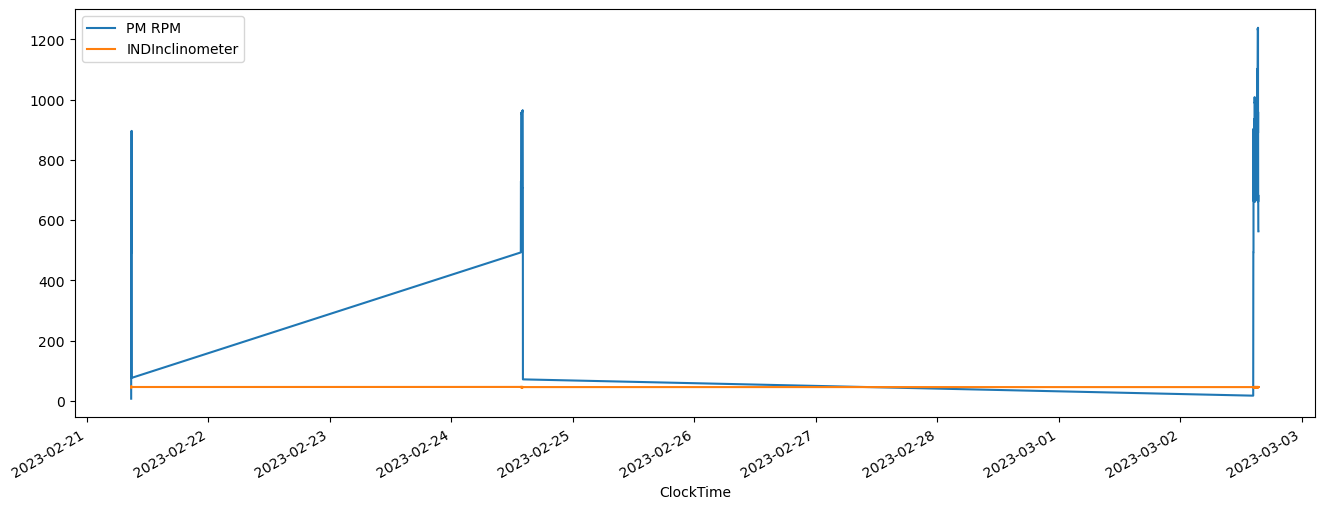

In [20]:
# let's get a quick overview of the test by looking at the PM RPM and inclinomter
# in Series C tests, an independent inclinomter signal was added.
df_RL.plot(x="ClockTime", y=["PM RPM","INDInclinometer"], figsize=(16,6))

In [31]:
xw.view(df_RL[df_RL["Date"] == pd.to_datetime("2023-03-02")])

In [30]:
df_RL[df_RL["Date"] == pd.to_datetime("2023-03-02")]

AcqTime               ClockTime       Date  PM Sheave Dia   Angle  \
118068  51882.295 2023-03-02 14:24:42.295 2023-03-02              6  113.07   
118069  51882.311 2023-03-02 14:24:42.311 2023-03-02              6  113.07   
118070  51882.327 2023-03-02 14:24:42.327 2023-03-02              6  112.99   
118071  51882.343 2023-03-02 14:24:42.343 2023-03-02              6  113.16   
118072  51882.359 2023-03-02 14:24:42.359 2023-03-02              6  113.07   
...           ...                     ...        ...            ...     ...   
350078  55602.983 2023-03-02 15:26:42.983 2023-03-02              6   91.51   
350079  55602.999 2023-03-02 15:26:42.999 2023-03-02              6   91.51   
350080  55603.015 2023-03-02 15:26:43.015 2023-03-02              6   91.60   
350081  55603.031 2023-03-02 15:26:43.031 2023-03-02              6   91.60   
350082  55603.047 2023-03-02 15:26:43.047 2023-03-02              6   91.51   

        PM RPM  CVTSpeedIn  CVTSpeedOut  CVTSpeedOutSp2PID  CVTCoolPres  ...  \
118068    18.0        99.0        113.0                NaN          NaN  ...   
118069    19.0       104.0        119.0                NaN          NaN  ...   
118070    20.0       109.0        126.0                NaN          NaN  ...   
118071    21.0       114.0        133.0                NaN          NaN  ...   
118072    22.0       119.0        140.0                NaN          NaN  ...   
...        ...         ...          ...                ...          ...  ...   
350078   563.0      1195.0       2193.0                NaN          NaN  ...   
350079   563.0      1195.0       2192.0                NaN          NaN  ...   
350080   563.0      1195.0       2193.0                NaN          NaN  ...   
350081   563.0      1195.0       2193.0                NaN          NaN  ...   
350082   563.0      1195.0       2193.0                NaN          NaN  ...   

        OutputVoltage  RodLoadMonitor  RodPosMonitor  RodPosPredicted  \
118068            NaN             NaN            NaN              NaN   
118069            NaN             NaN            NaN              NaN   
118070            NaN             NaN            NaN              NaN   
118071            NaN             NaN            NaN              NaN   
118072            NaN             NaN            NaN              NaN   
...               ...             ...            ...              ...   
350078            NaN             NaN            NaN              NaN   
350079            NaN             NaN            NaN              NaN   
350080            NaN             NaN            NaN              NaN   
350081            NaN             NaN            NaN              NaN   
350082            NaN             NaN            NaN              NaN   

        PumpLoadInferred  MotorAvgPowerMonitor  PumpSPMMonitor  \
118068               NaN                   NaN             NaN   
118069               NaN                   NaN             NaN   
118070               NaN                   NaN             NaN   
118071               NaN                   NaN             NaN   
118072               NaN                   NaN             NaN   
...                  ...                   ...             ...   
350078               NaN                   NaN             NaN   
350079               NaN                   NaN             NaN   
350080               NaN                   NaN             NaN   
350081               NaN                   NaN             NaN   
350082               NaN                   NaN             NaN   

        Average Current  Average Voltage     delta T  
118068        58.040000       485.683333  519395.728  
118069        58.300000       485.620000       0.016  
118070        58.493333       485.520000       0.016  
118071        58.993333       485.573333       0.016  
118072        58.993333       485.573333       0.016  
...                 ...              ...         ...  
350078        15.580000       483.170000     

In [29]:
df_RL[df_RL["Date"] == pd.to_datetime("2023-03-02")].dropna()

AcqTime               ClockTime       Date  PM Sheave Dia   Angle  \
196298  53141.959 2023-03-02 14:45:41.959 2023-03-02              6  112.46   
205368  53287.111 2023-03-02 14:48:07.111 2023-03-02              6  130.67   
207065  53314.327 2023-03-02 14:48:34.327 2023-03-02              6 -159.02   
207380  53319.367 2023-03-02 14:48:39.367 2023-03-02              6  -39.96   
265706  54252.775 2023-03-02 15:04:12.775 2023-03-02              6  101.11   
273074  54370.711 2023-03-02 15:06:10.711 2023-03-02              6   58.95   
274775  54397.927 2023-03-02 15:06:37.927 2023-03-02              6  145.19   
276853  54431.191 2023-03-02 15:07:11.191 2023-03-02              6   65.03   
278680  54460.423 2023-03-02 15:07:40.423 2023-03-02              6 -141.60   
286491  54585.415 2023-03-02 15:09:45.415 2023-03-02              6   98.99   
290271  54645.895 2023-03-02 15:10:45.895 2023-03-02              6  116.95   
297516  54761.815 2023-03-02 15:12:41.815 2023-03-02              6  105.07   
305075  54882.775 2023-03-02 15:14:42.775 2023-03-02              6  145.11   
305138  54883.783 2023-03-02 15:14:43.783 2023-03-02              6  163.06   
307343  54919.063 2023-03-02 15:15:19.063 2023-03-02              6   82.10   
309296  54950.311 2023-03-02 15:15:50.311 2023-03-02              6  126.10   
327813  55246.663 2023-03-02 15:20:46.663 2023-03-02              6   76.20   
327876  55247.671 2023-03-02 15:20:47.671 2023-03-02              6   99.61   
339592  55435.159 2023-03-02 15:23:55.159 2023-03-02              6  -22.71   
341418  55464.391 2023-03-02 15:24:24.391 2023-03-02              6  136.48   
343182  55492.615 2023-03-02 15:24:52.615 2023-03-02              6 -145.91   
343308  55494.631 2023-03-02 15:24:54.631 2023-03-02              6 -108.86   

        PM RPM  CVTSpeedIn  CVTSpeedOut  CVTSpeedOutSp2PID  CVTCoolPres  ...  \
196298   992.0      1194.0       3857.0              701.0        11.47  ...   
205368   693.0      1196.0       2695.0              702.0        11.48  ...   
207065   692.0      1195.0       2696.0              701.0        11.02  ...   
207380   693.0      1196.0       2695.0              702.0        11.09  ...   
265706   667.0      1195.0       2594.0              701.0        10.95  ...   
273074   686.0      1196.0       2668.0              701.0        10.84  ...   
274775   686.0      1195.0       2669.0              701.0        11.01  ...   
276853   686.0      1195.0       2668.0              701.0        10.84  ...   
278680   990.0      1194.0       3846.0              957.0        10.95  ...   
286491   992.0      1194.0       3861.0              957.0        11.28  ...   
290271   992.0      1193.0       3861.0              958.0        11.08  ...   
297516  1097.0      1194.0       4265.0             1086.0        10.87  ...   
305075  1100.0      1193.0       4277.0             1085.0        11.18  ...   
305138  1100.0      1193.0       4277.0             1085.0        11.01  ...   
307343  1100.0      1194.0       4281.0             1086.0        10.82  ...   
309296   949.0      1195.0       3692.0              958.0        11.33  ...   
327813  1235.0      1193.0       4804.0             1221.0        11.46  ...   
327876  1236.0      1193.0       4805.0             1221.0        10.71  ...   
339592   683.0      1195.0       2657.0              701.0        10.96  ...   
341418   682.0      1195.0       2653.0              702.0        11.34  ...   
343182   682.0      1196.0       2651.0              702.0        10.79  ...   
343308   681.0      1195.0       2652.0              702.0        11.34  ...   

        OutputVoltage  RodLoadMonitor  RodPosMonitor  RodPosPredicted  \
196298           92.0          8454.0          61.35            61.73   
205368          100.0          8516.0          71.10            71.42   
207065          100.0          8200.0          87.18            87.09   
207380          347.0          5417.0          39.38       

# Read in Dyne Card Data

In [19]:
DC_File_List = []

for entry in os.scandir(RL_Path):
    if not ((entry.is_dir() or entry.name.startswith("."))) \
        and "Dyna" in entry.name:
       
        DC_File_List.append(entry.name)


In [48]:
DC_File_List

['24Feb23-Dyna.TXT', '24Feb23-Dynajh.TXT']

In [49]:
DC_File_List[1]

'24Feb23-Dynajh.TXT'

In [50]:
# create lists for each type of row we see in a dyne card
DC_skiprowlist = []
DC_datelist = []
DC_date_rows = []
DC_header_rows = []
DC_newcard_start = []

In [51]:
mylines = []
# read in all lines from all files and sort the rows into lists by type
for i,f in enumerate(DC_File_List):
    with open(RL_Path + f,"r") as myfile:
        mylines.extend(myfile.readlines())


In [52]:
# mylines = []
# # read in all lines from all files and sort the rows into lists by type

# with open(RL_Path + DC_File_List[1],"r") as myfile:
#     mylines.extend(myfile.readlines())


In [53]:
for idx, line in enumerate(mylines):
# check for the date and record, if found, mark for skipping
# check for the header row "AcqTime,X,Y", if found, mark for skipping
# check for "#points=200.00" this indicates a new card, if found, mark for skipping

    if re.search("#\d\d:\d\d:\d\d\d\d", line):
        DC_skiprowlist.append(idx)
        DC_date_rows.append(idx)
        line = line.split(",")[0]
        DC_datelist.append(line.rstrip("\n"))
    if re.search("AcqTime*", line):
        DC_skiprowlist.append(idx)
        DC_header_rows.append(idx)
        DC_newcard_start.append(idx+1)
        DC_header = line.rstrip("\n")

DC_header = DC_header.split(",")

In [54]:
DC_header

['AcqTime', 'X', 'Y']

In [55]:
# now build a list of Dyne Card DataFrames
DC_List = []

for l in DC_newcard_start:
    df = pd.DataFrame([l.rstrip("\n").split(",") for l in mylines[l:l+200]], columns=DC_header)
    DC_List.append(df)
    
# Sort the dyne cards by acquistion time
DC_List.sort(key=lambda x: x.loc[0,"AcqTime"])

# convert all values to floating point numbers
for i in range(len(DC_List)):
    DC_List[i] = DC_List[i].apply(pd.to_numeric)

In [56]:
DC_List[-1].loc[0,"AcqTime"]

50795.888

## Process Dyne Card Data

In [57]:
# see if any of the dyne cards are actually different

# define a placeholder for the previous dataframe to be used as a comparison
df_prev = pd.DataFrame()

DC_unique_list = []

count = 0

for idx, df in enumerate(DC_List):
    if not df_prev.empty:
        delt_Pos = df.iloc[:,1] - df_prev.iloc[:,1]
        delt_Load = df.iloc[:,2] - df_prev.iloc[:,2]

        dRow = DC_date_rows[idx]
        strDate = mylines[dRow].split(",")[0].lstrip("#")
        dateVal = datetime.strptime(strDate,"%d:%m:%Y")
        t = (dateVal + pd.to_timedelta(df.iloc[0,0], unit="S")).time()

        if delt_Pos.sum() == 0 and delt_Load.sum() == 0:
            print("Dyne Card: " + str(idx) + " at time: " + str(t) + " is not unique")
            count += 1
        else:
            DC_unique_list.append(idx)

        #print(t, delt_Pos.sum(), delt_Load.sum())
    
    df_prev = df.copy()

print(str(count) + " duplicate dyne cards, out of " + str(len(DC_List))) 

Dyne Card: 1 at time: 08:38:14.174000 is not unique
Dyne Card: 2 at time: 08:38:14.188000 is not unique
Dyne Card: 3 at time: 08:38:14.188000 is not unique
Dyne Card: 4 at time: 08:40:25.232000 is not unique
Dyne Card: 5 at time: 08:40:25.232000 is not unique
Dyne Card: 6 at time: 08:42:45.248000 is not unique
Dyne Card: 7 at time: 08:42:45.248000 is not unique
Dyne Card: 8 at time: 08:44:53.176000 is not unique
Dyne Card: 9 at time: 08:44:53.176000 is not unique
Dyne Card: 10 at time: 08:47:00.305000 is not unique
Dyne Card: 11 at time: 08:47:00.305000 is not unique
Dyne Card: 12 at time: 08:49:19.259000 is not unique
Dyne Card: 13 at time: 08:49:19.259000 is not unique
Dyne Card: 14 at time: 08:51:24.251000 is not unique
Dyne Card: 15 at time: 08:51:24.251000 is not unique
Dyne Card: 16 at time: 08:53:41.291000 is not unique
Dyne Card: 17 at time: 08:53:41.291000 is not unique
Dyne Card: 18 at time: 08:55:48.249000 is not unique
Dyne Card: 19 at time: 08:55:48.249000 is not unique
Dy

In [58]:
# create a new dataframe for each unique dyne card
# create a new list of dataframes

ls_dfDC = []

for idx in DC_unique_list:
    # drop duplicate values
    DC_Temp = DC_List[idx].copy()
    DC_Temp.columns = DC_header
    DC_Temp = DC_Temp.drop_duplicates(subset=["X"]).reset_index(drop=True)

    # after dropping duplicate values, if the dyne card has more than 100 points, then
    # add it to the list
    if len(DC_Temp) > 100:     
        #DC_Temp["X"] = DC_Temp["X"] / 100
        DC_Temp = DC_Temp.rename(columns={"X":"Position","Y":"Load"})
        DC_Temp["AcqTime"] = dateVal + pd.to_timedelta(DC_Temp["AcqTime"], unit="S")
        ls_dfDC.append(DC_Temp)
        
# create a list to hold the acquisition times of each of the
# unique dyne cards
DC_AcqTimes = [dc.loc[0,"AcqTime"] for dc in ls_dfDC]


In [59]:
len(ls_dfDC)

92

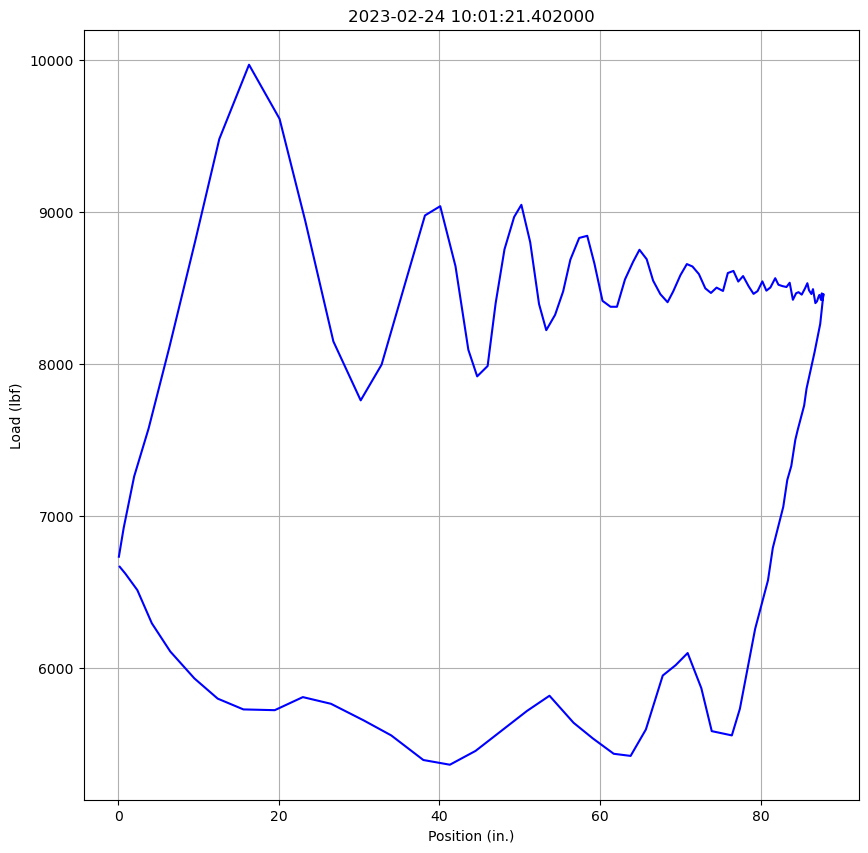

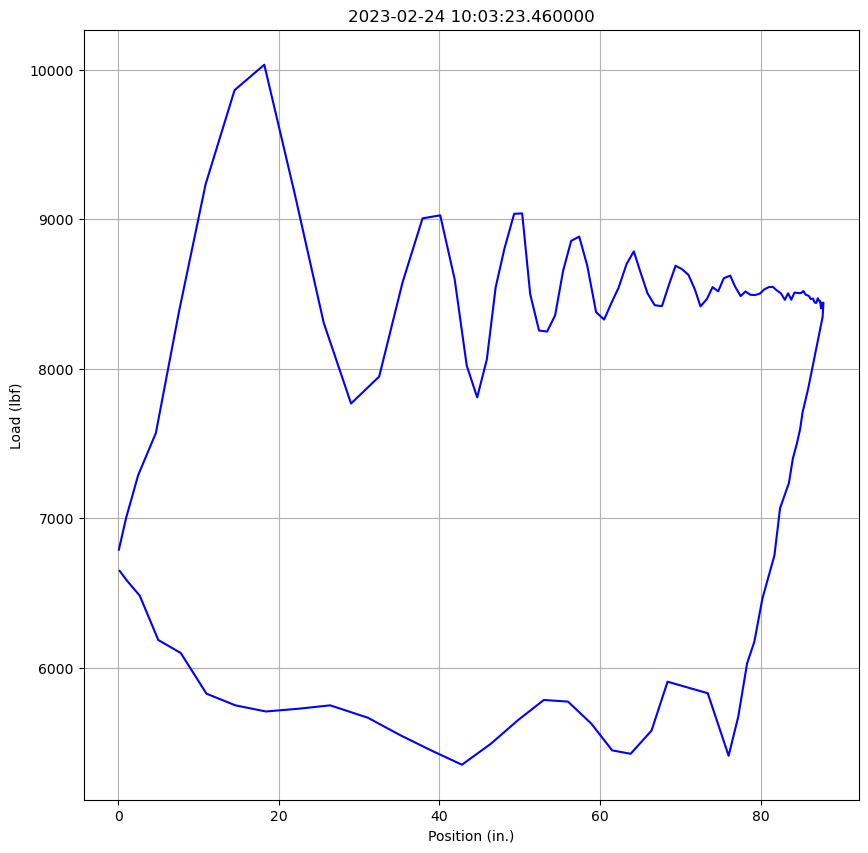

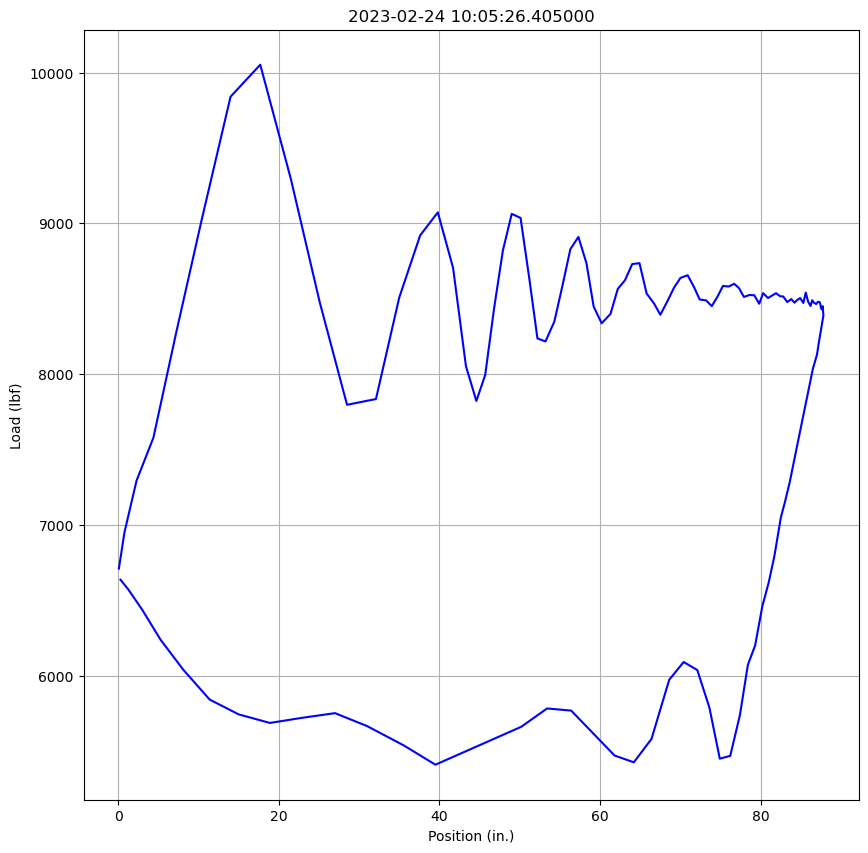

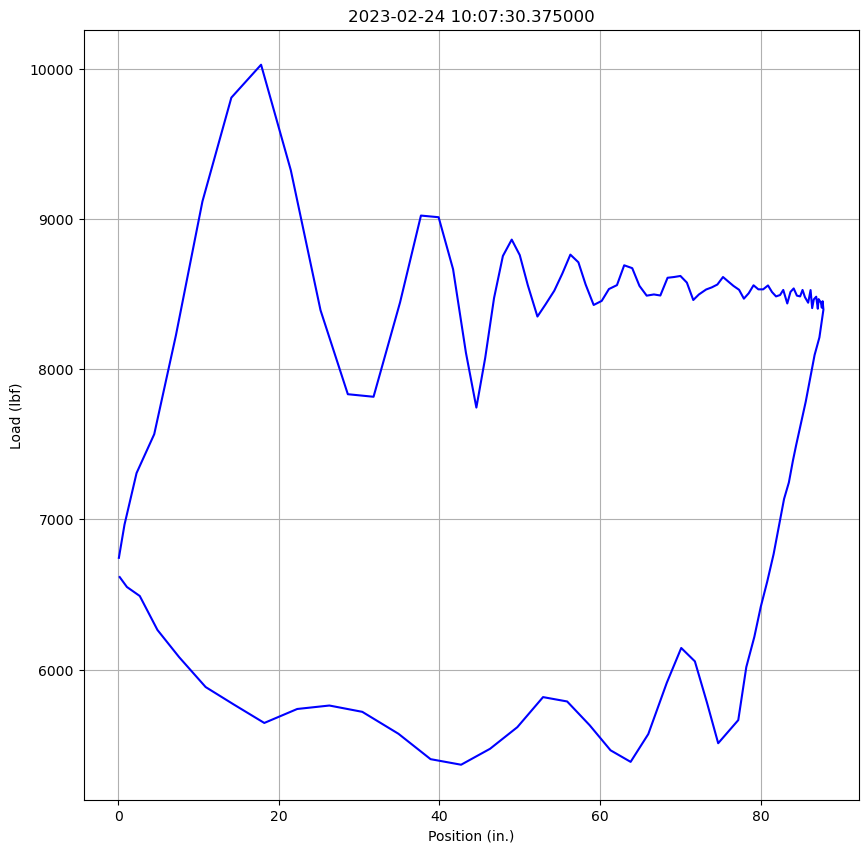

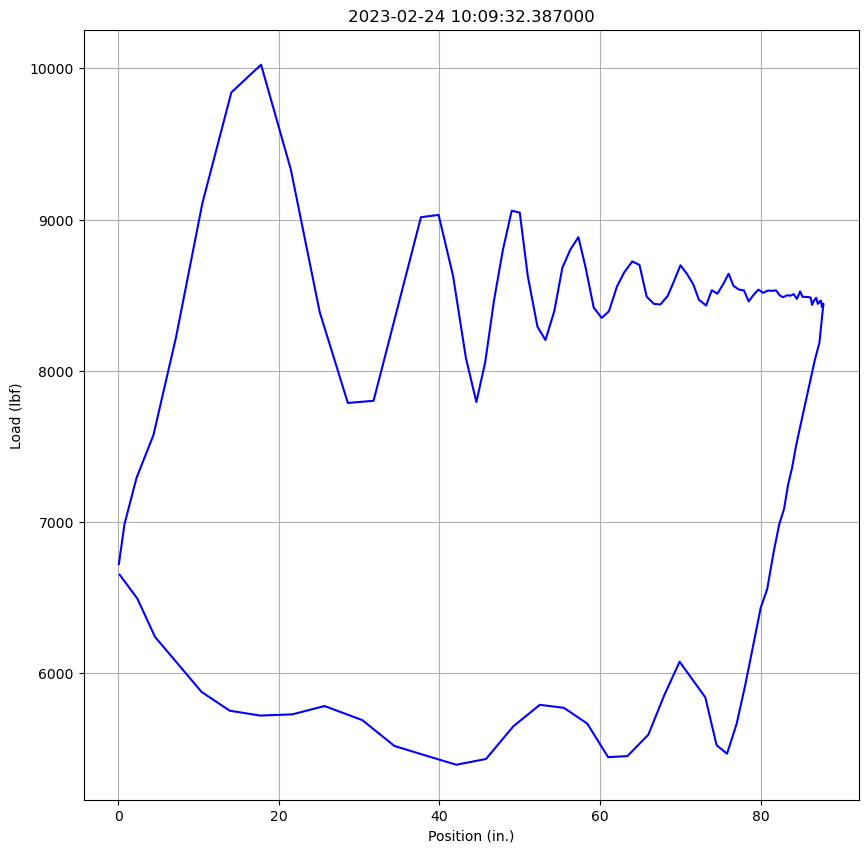

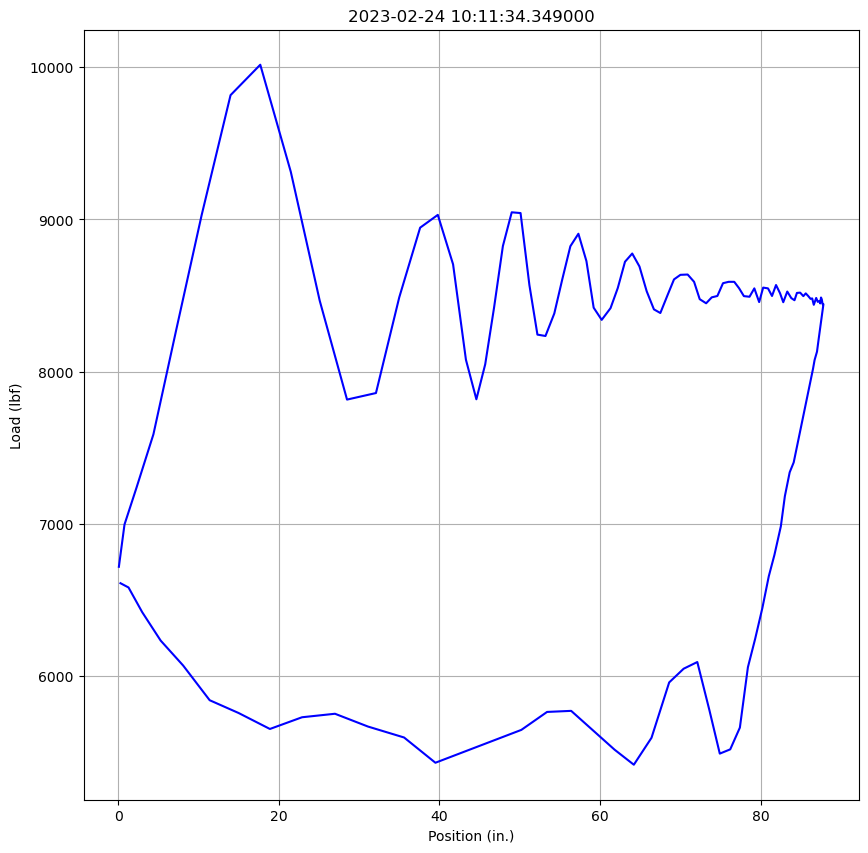

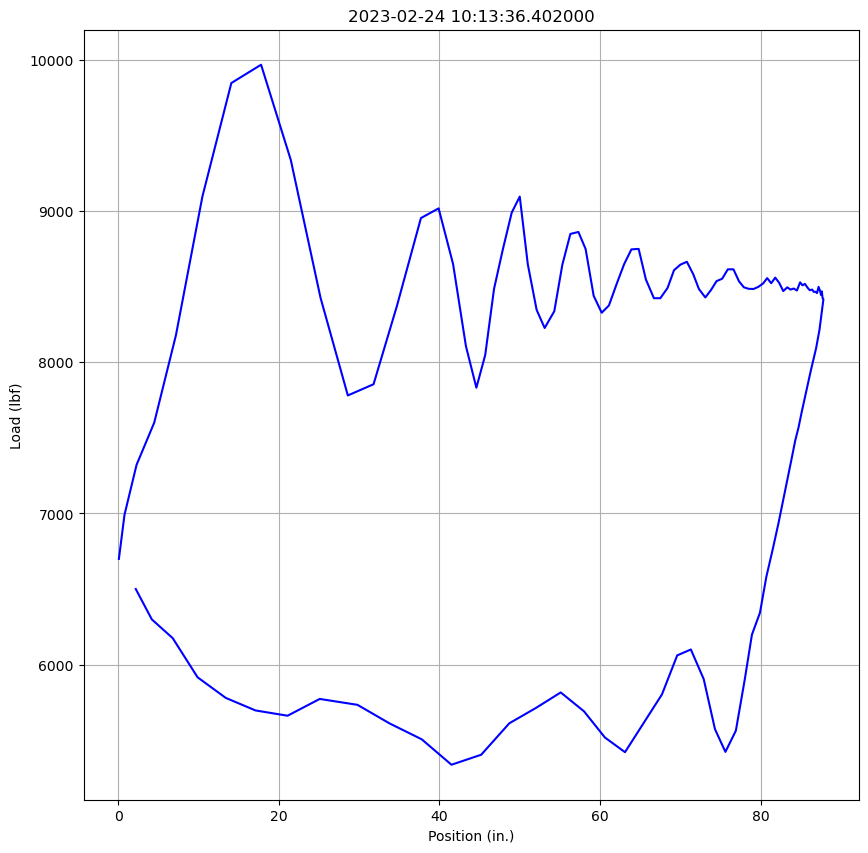

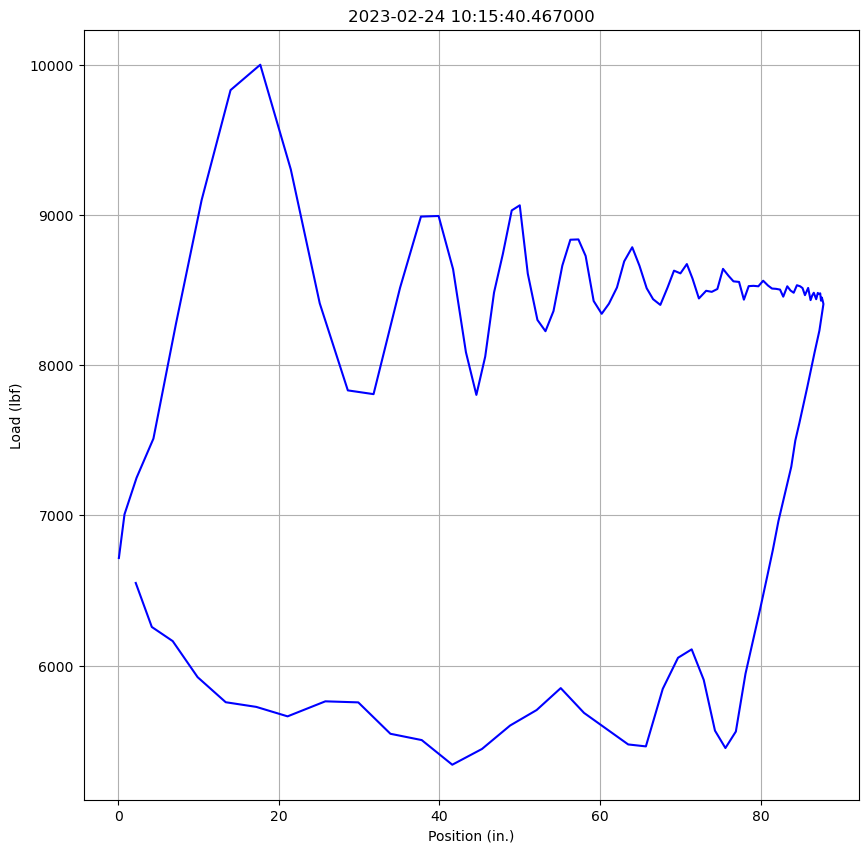

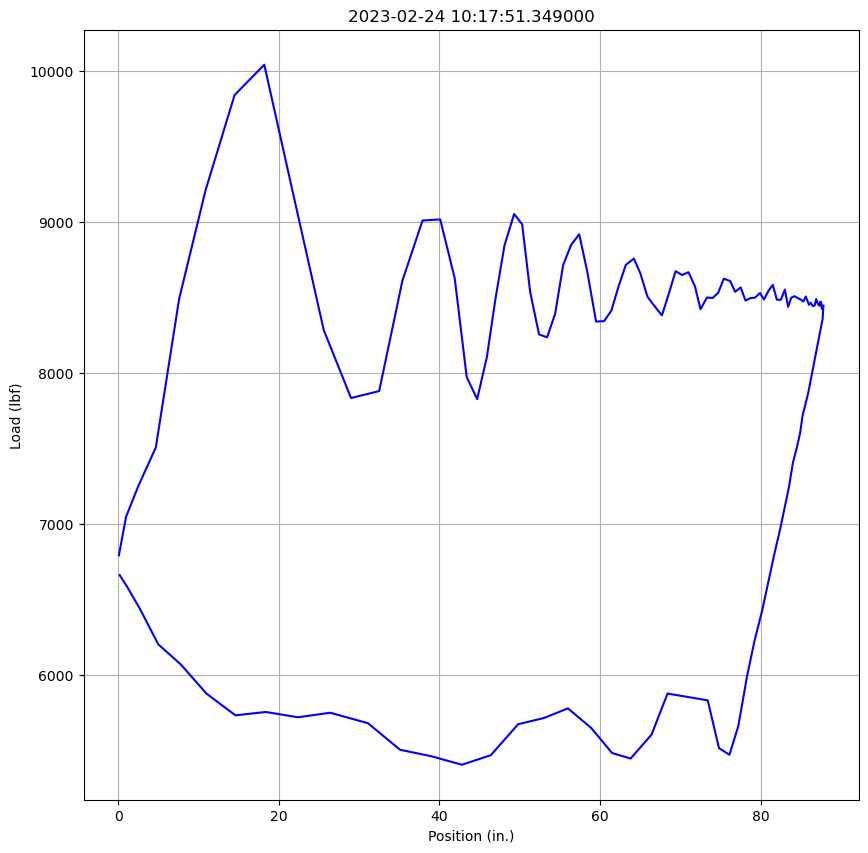

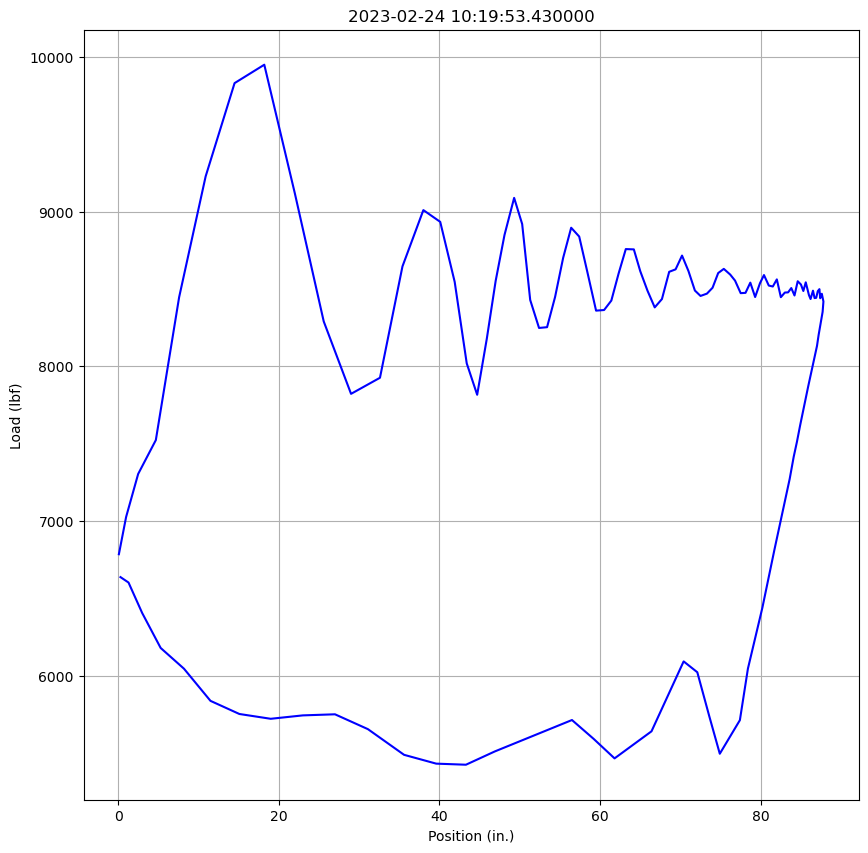

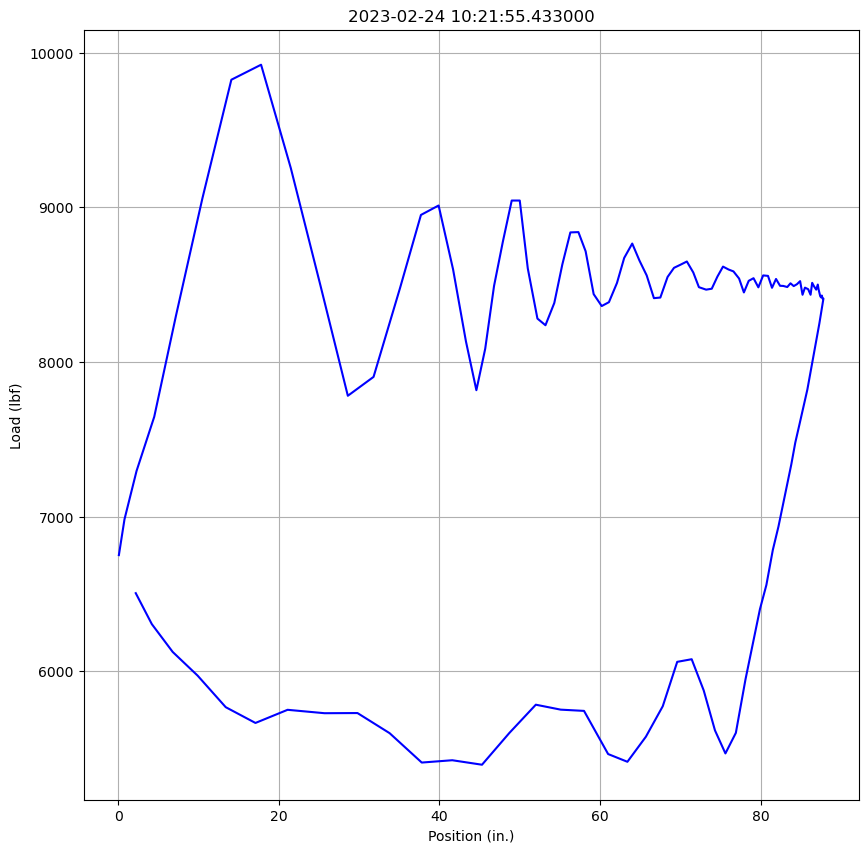

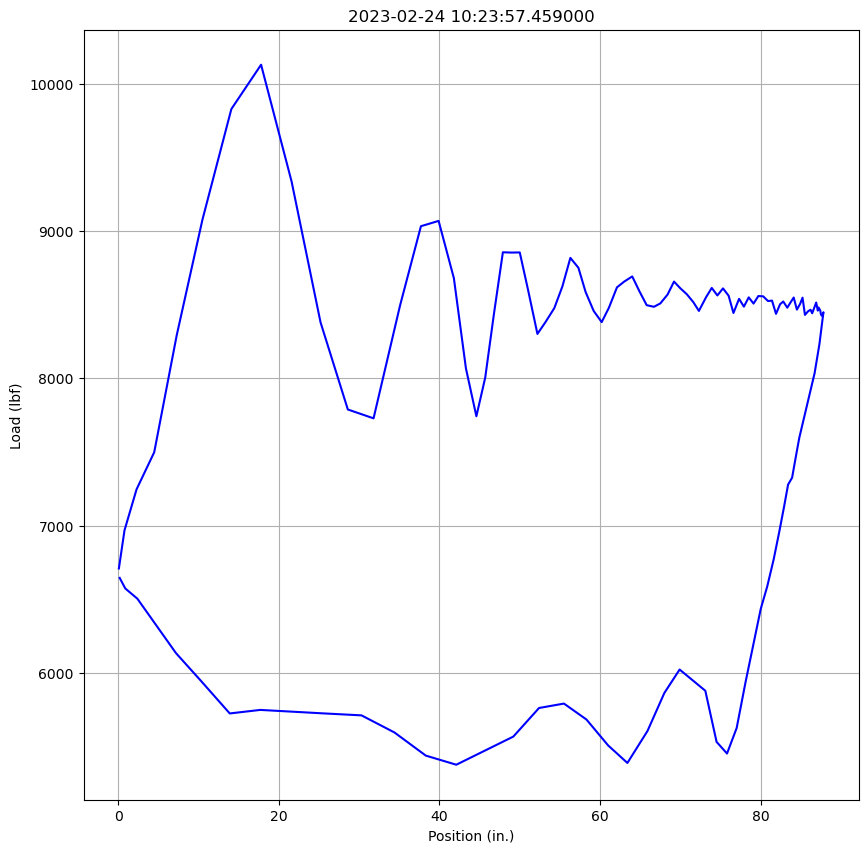

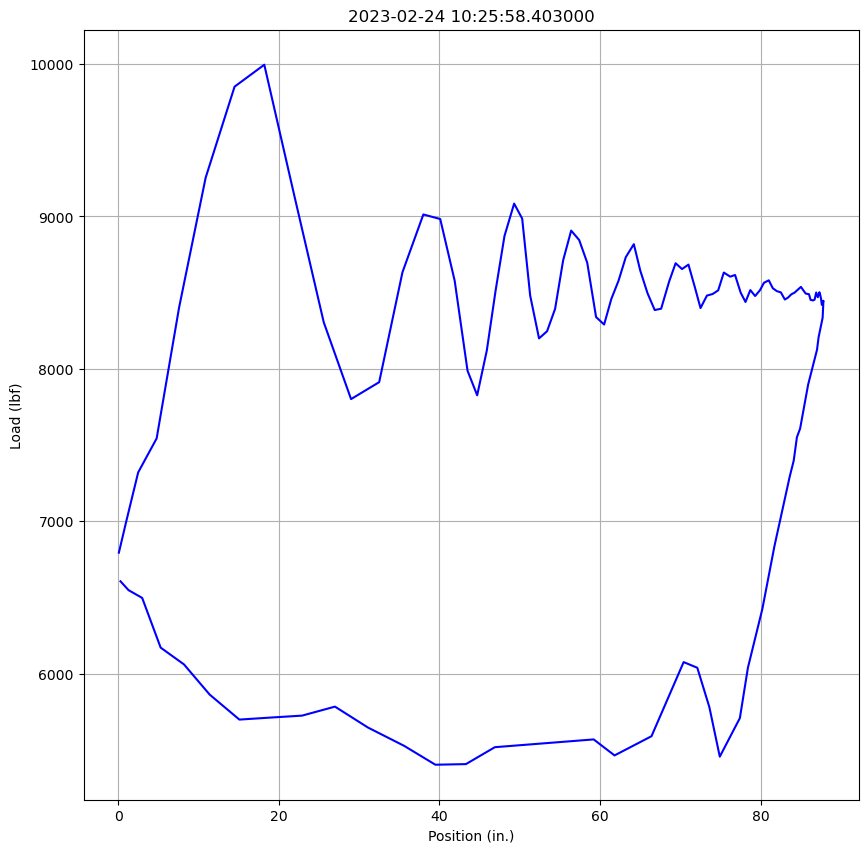

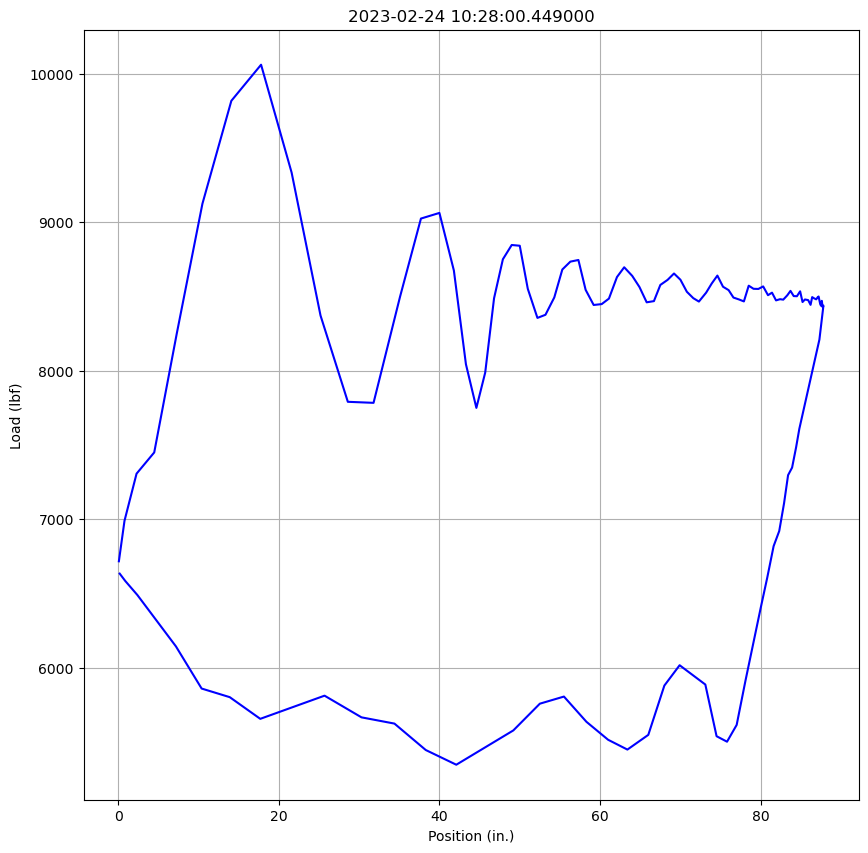

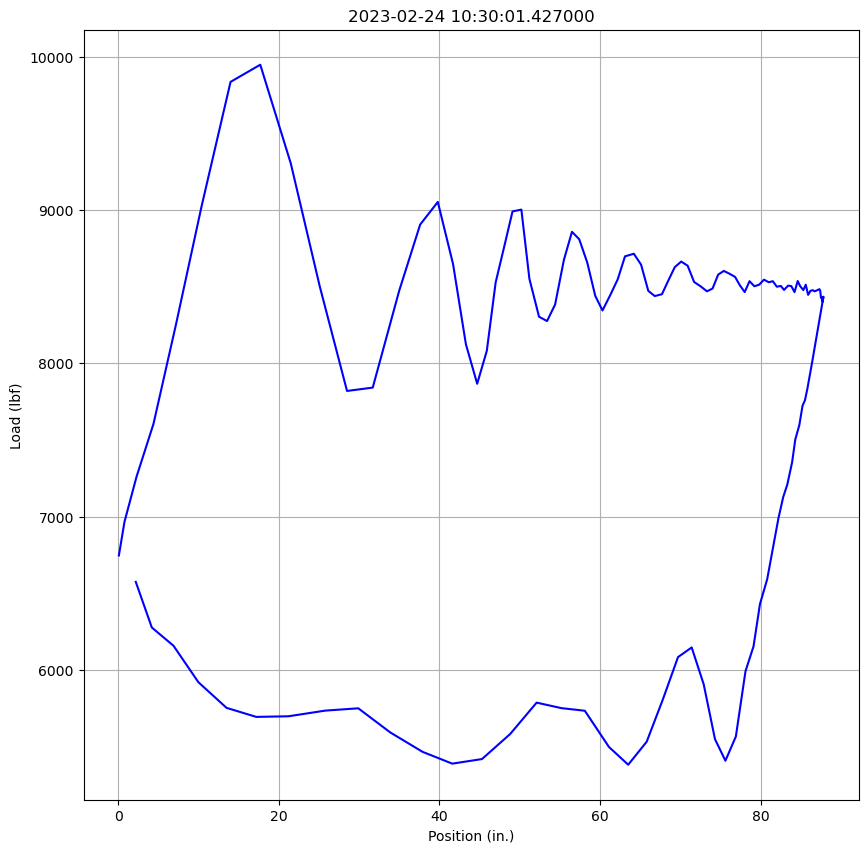

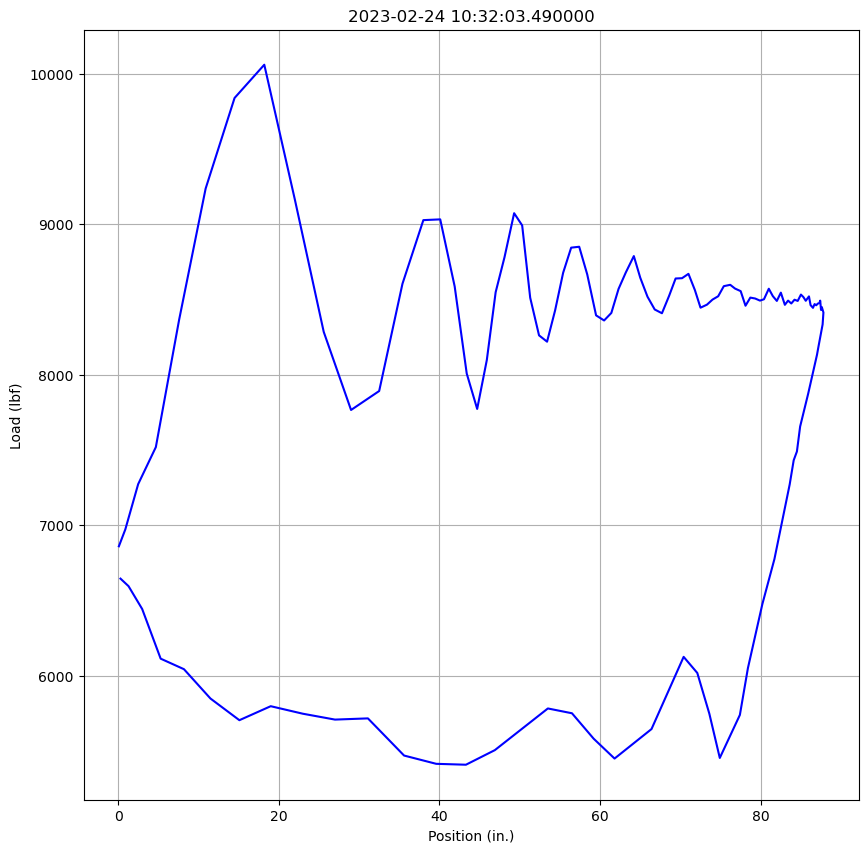

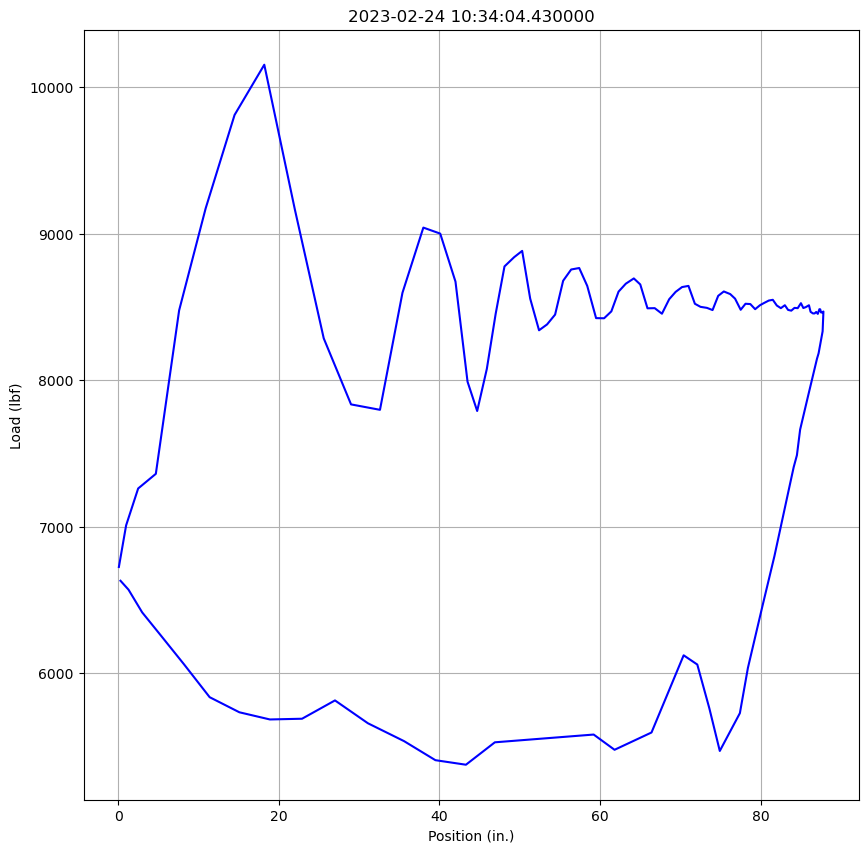

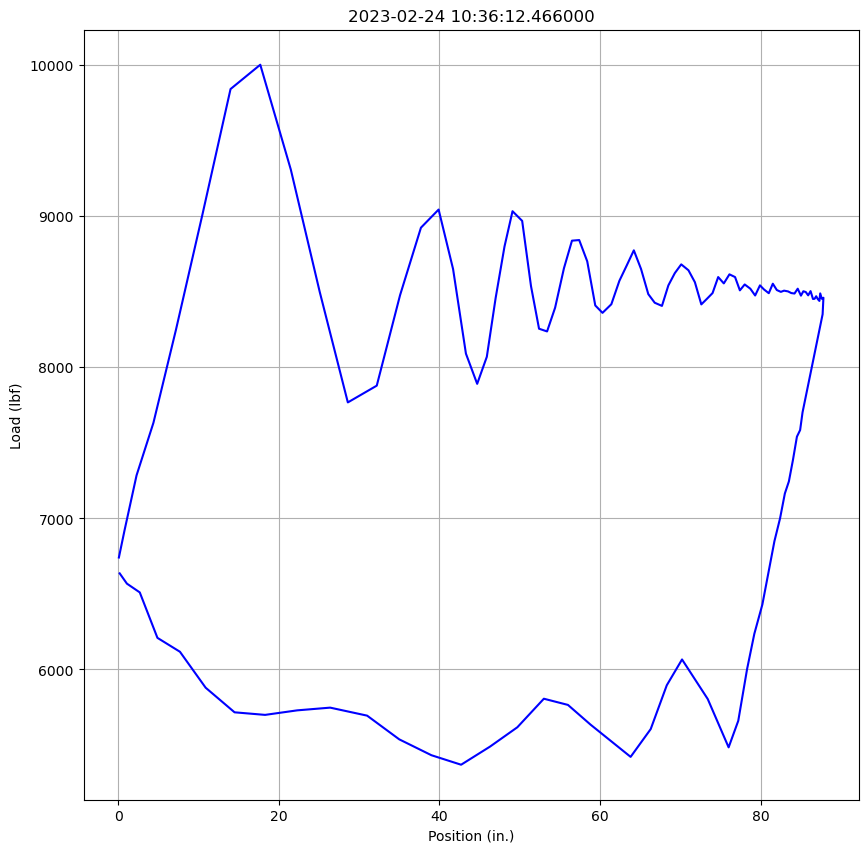

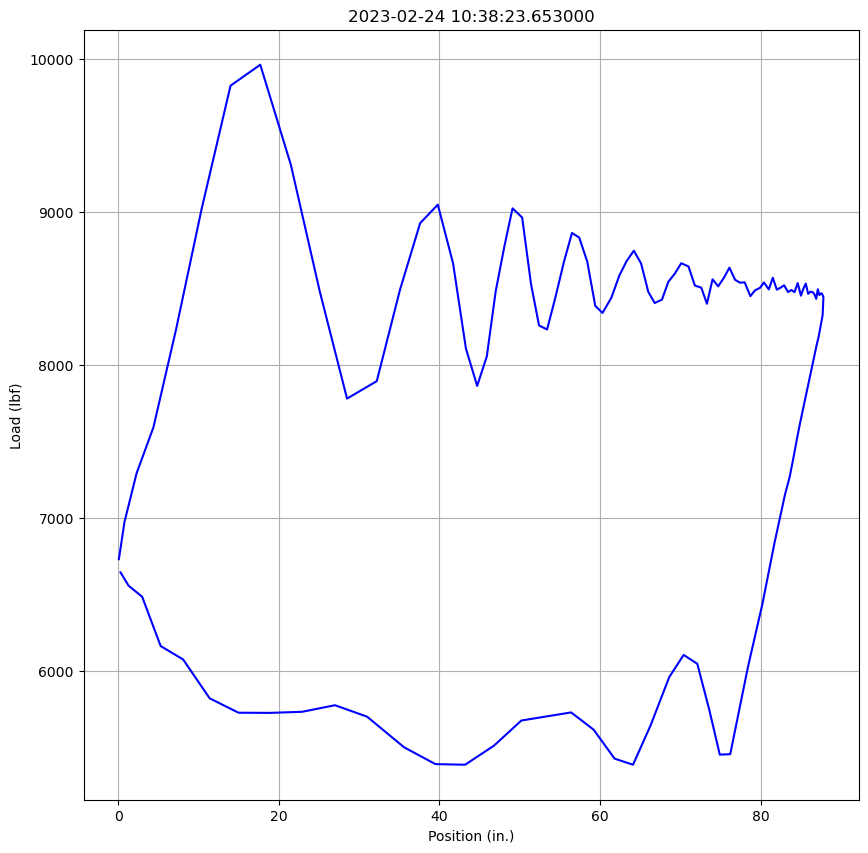

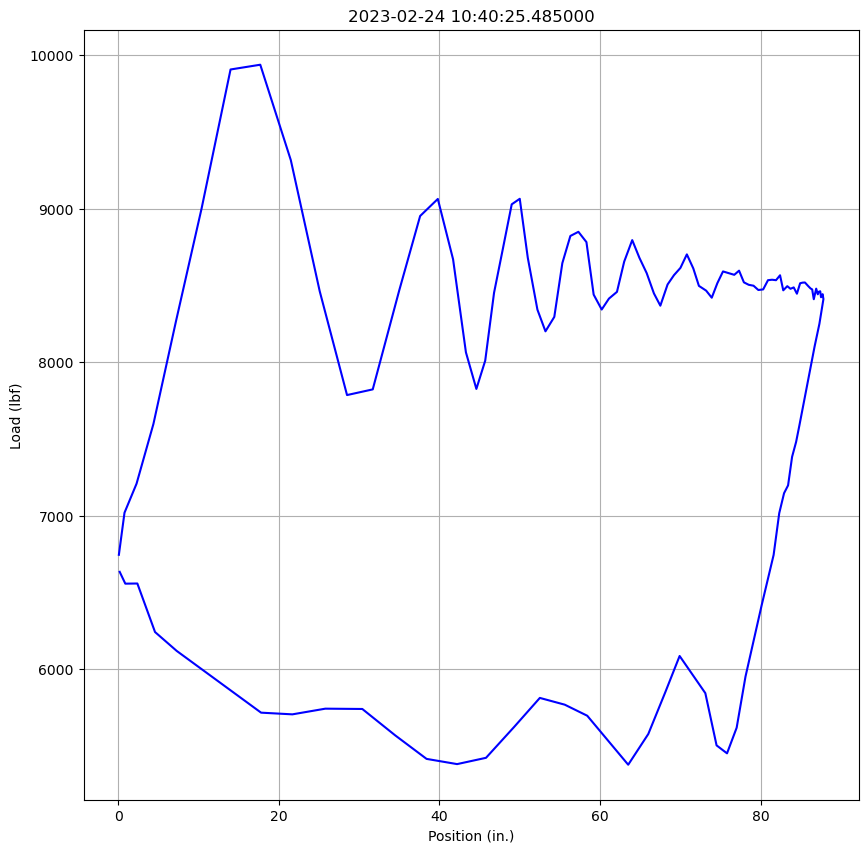

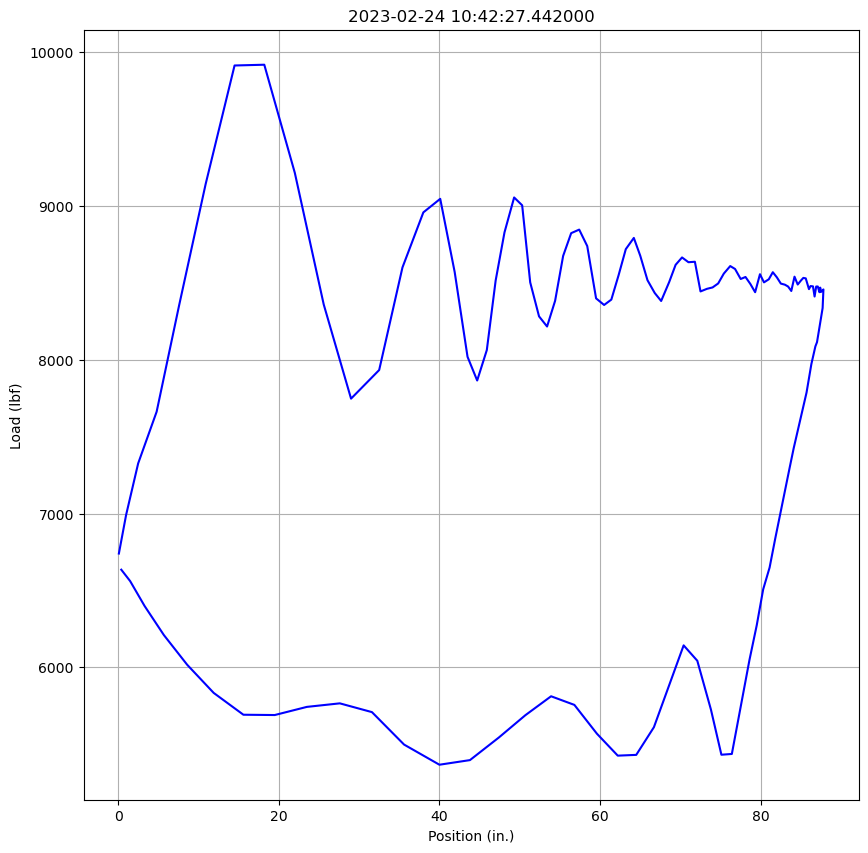

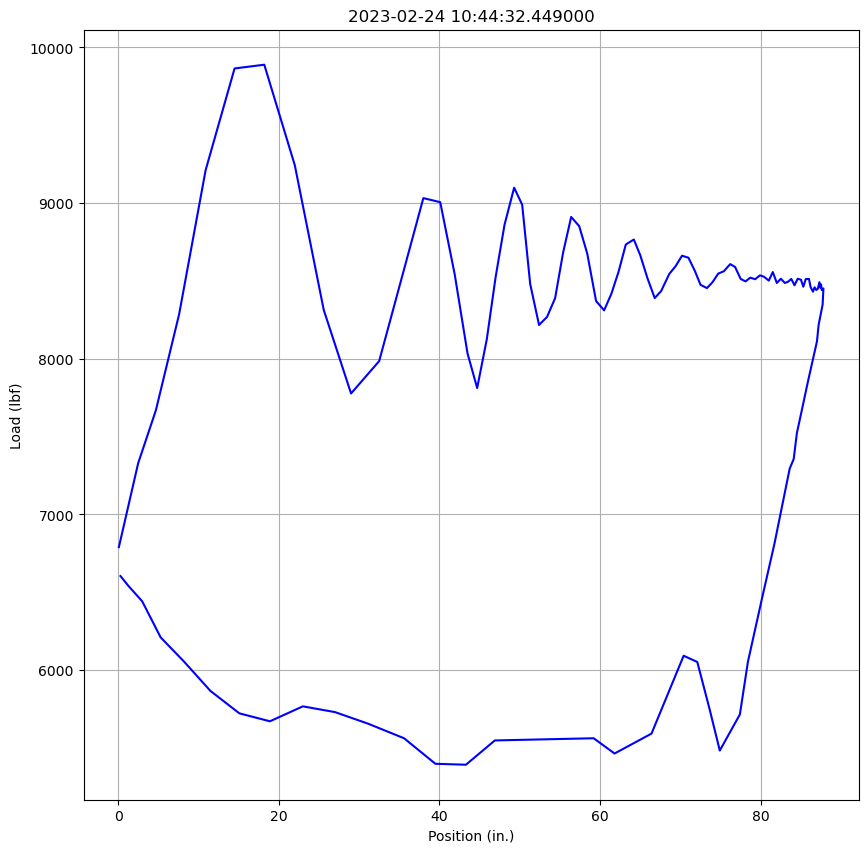

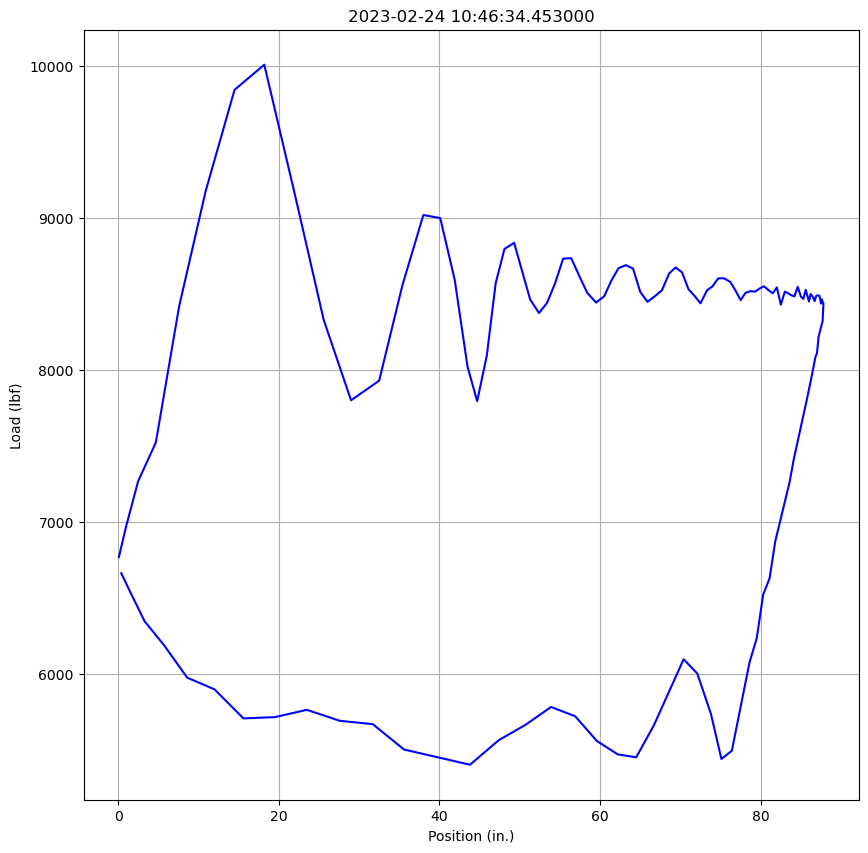

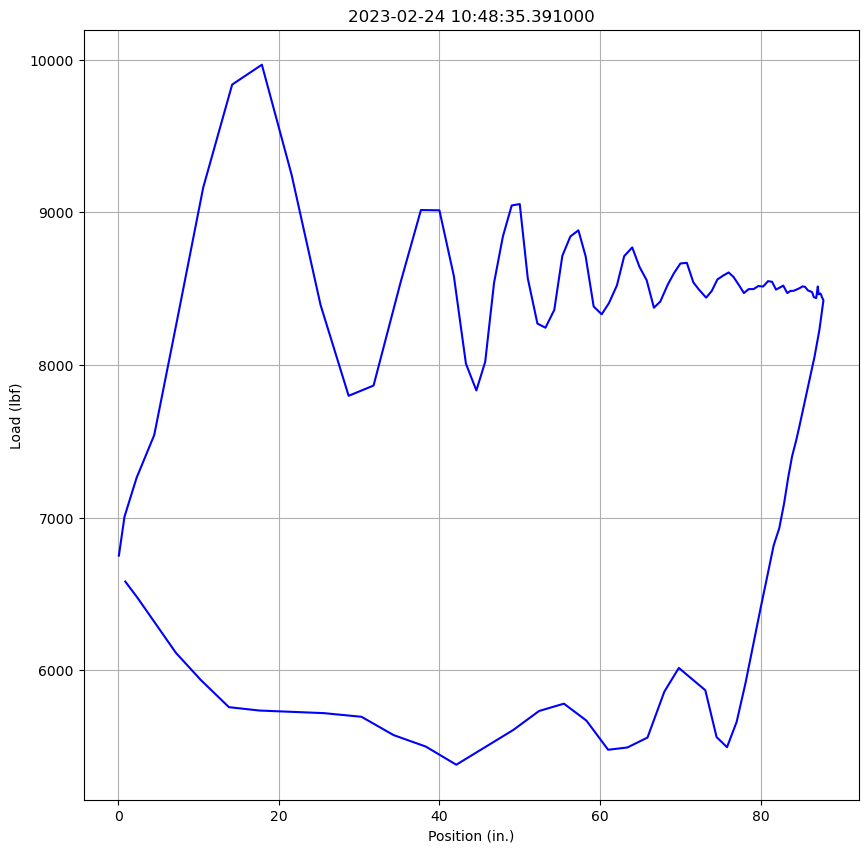

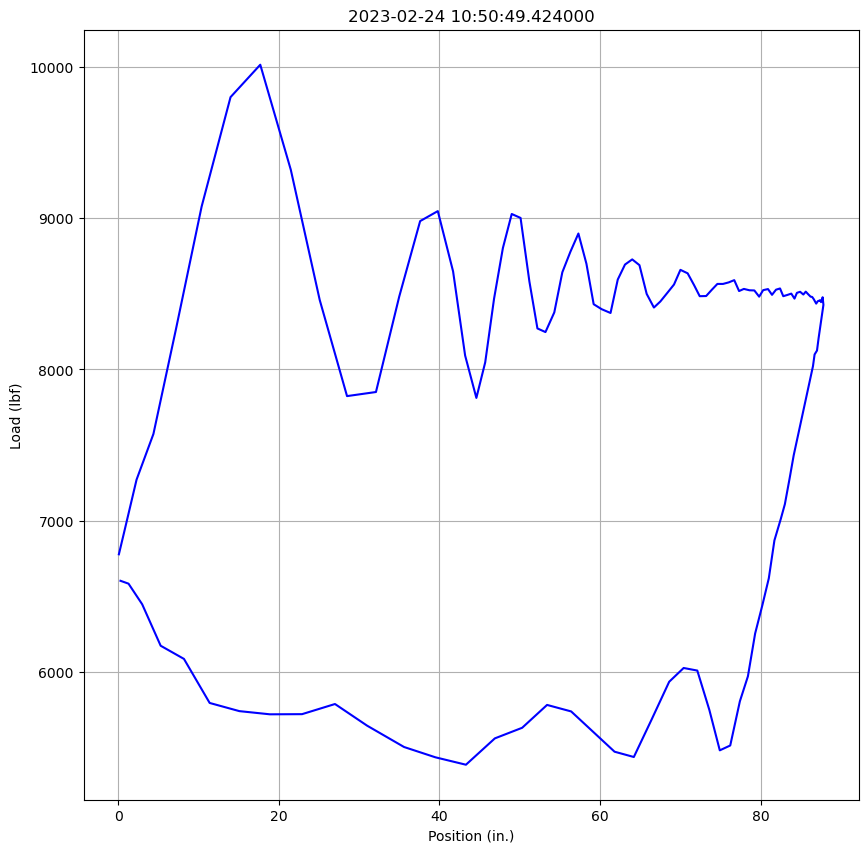

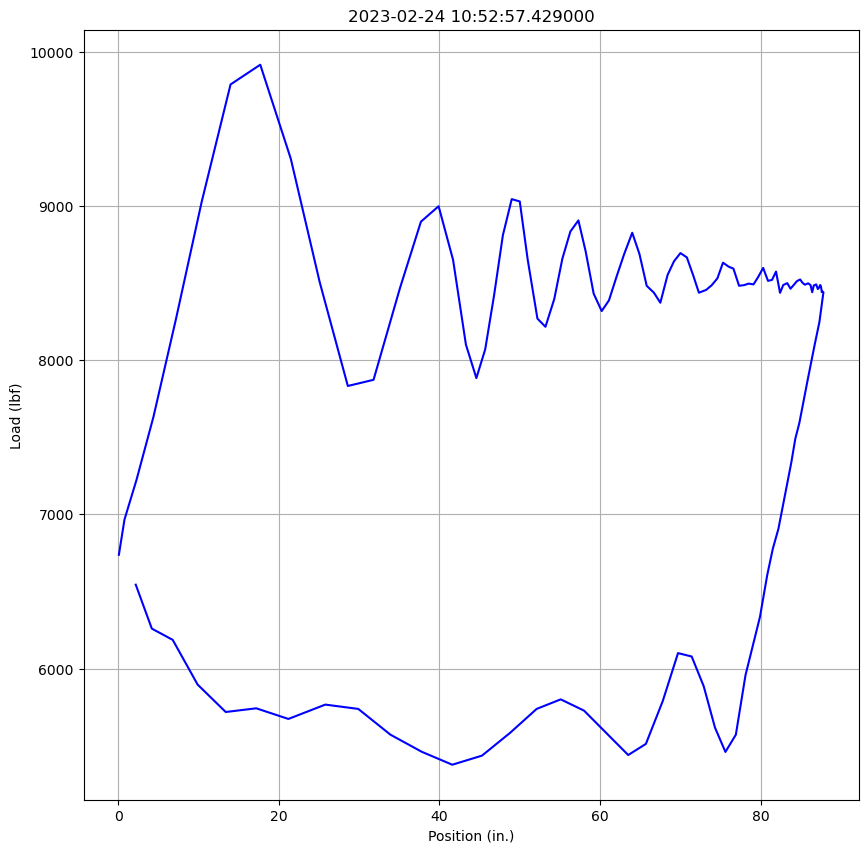

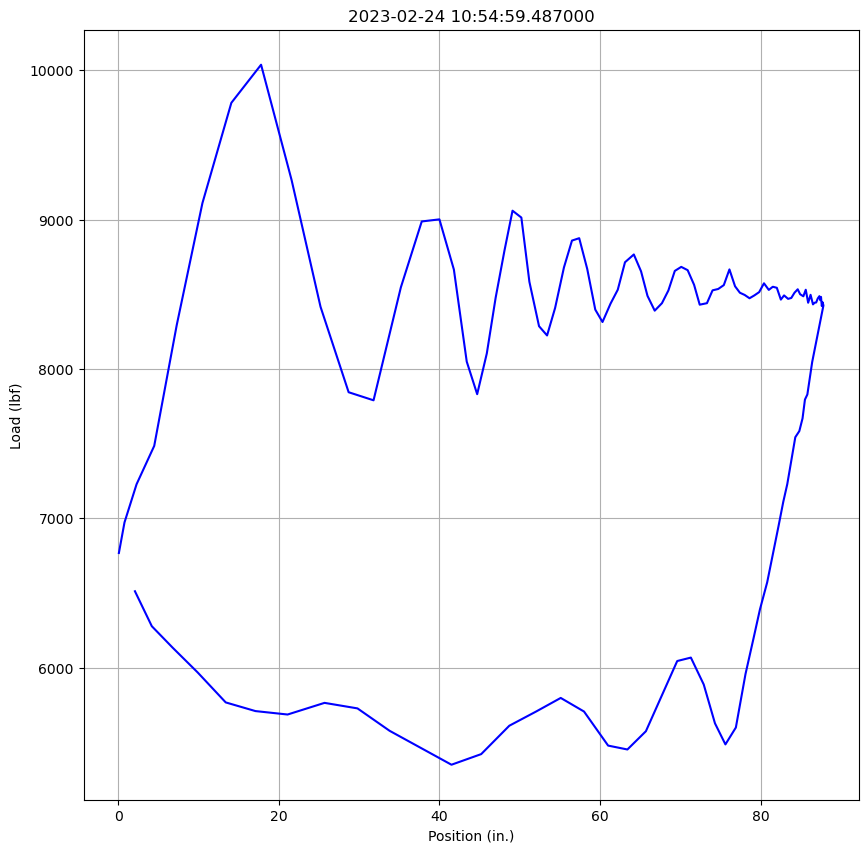

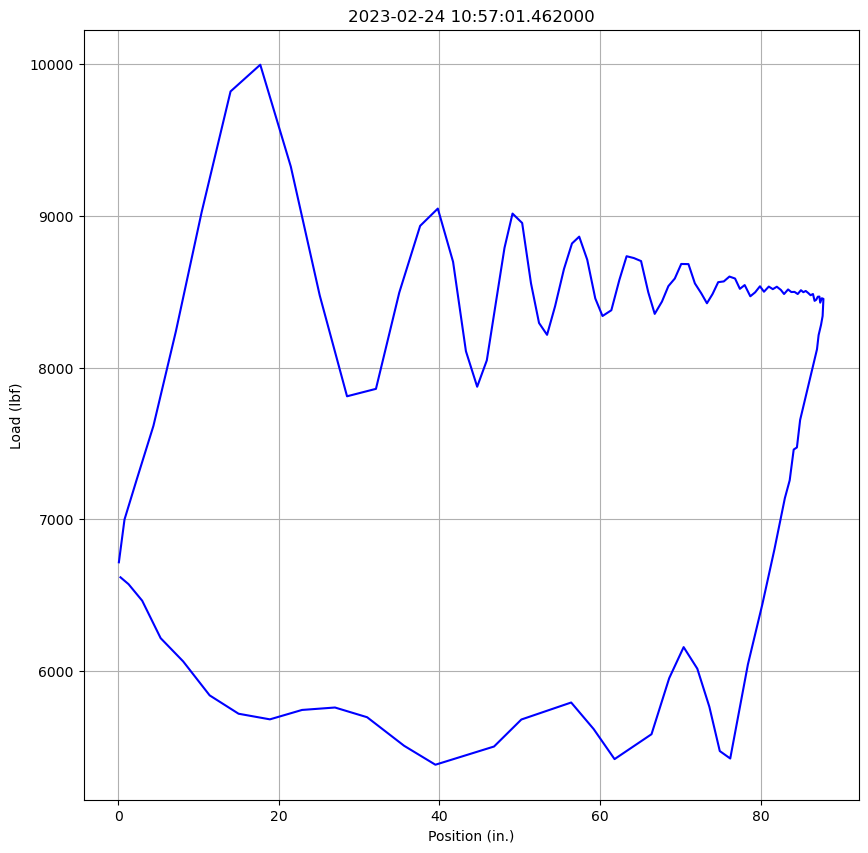

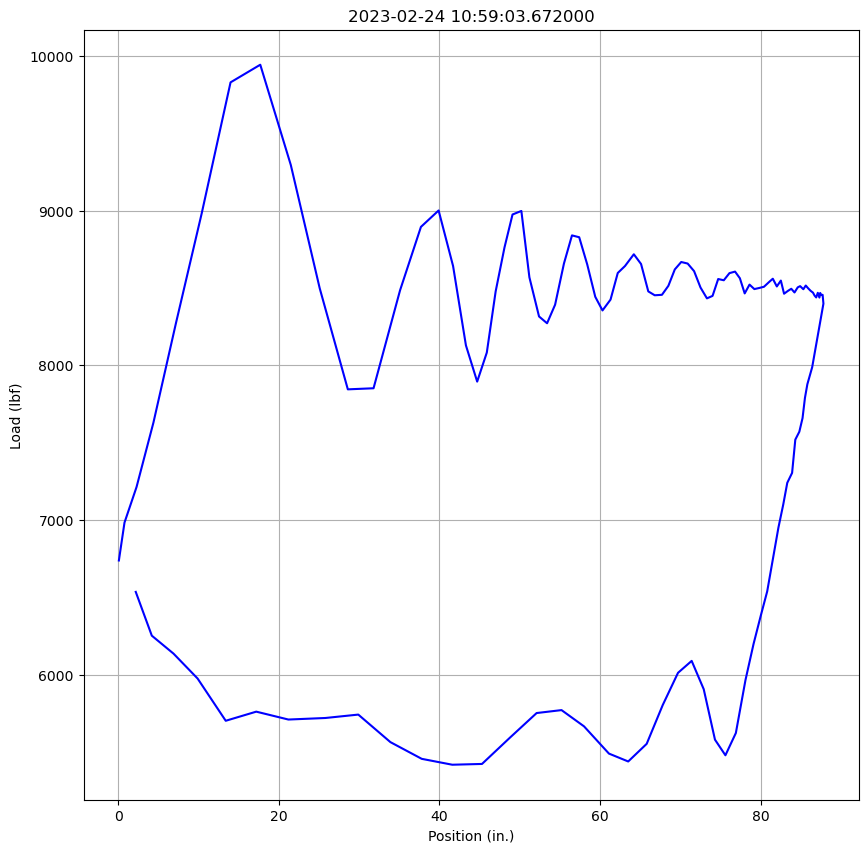

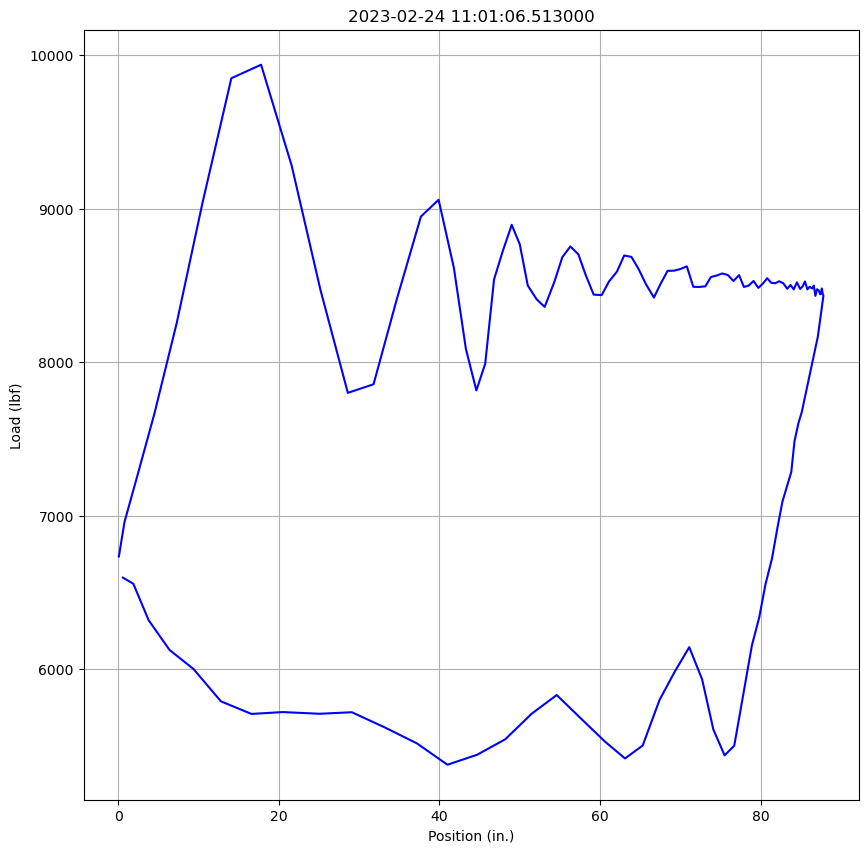

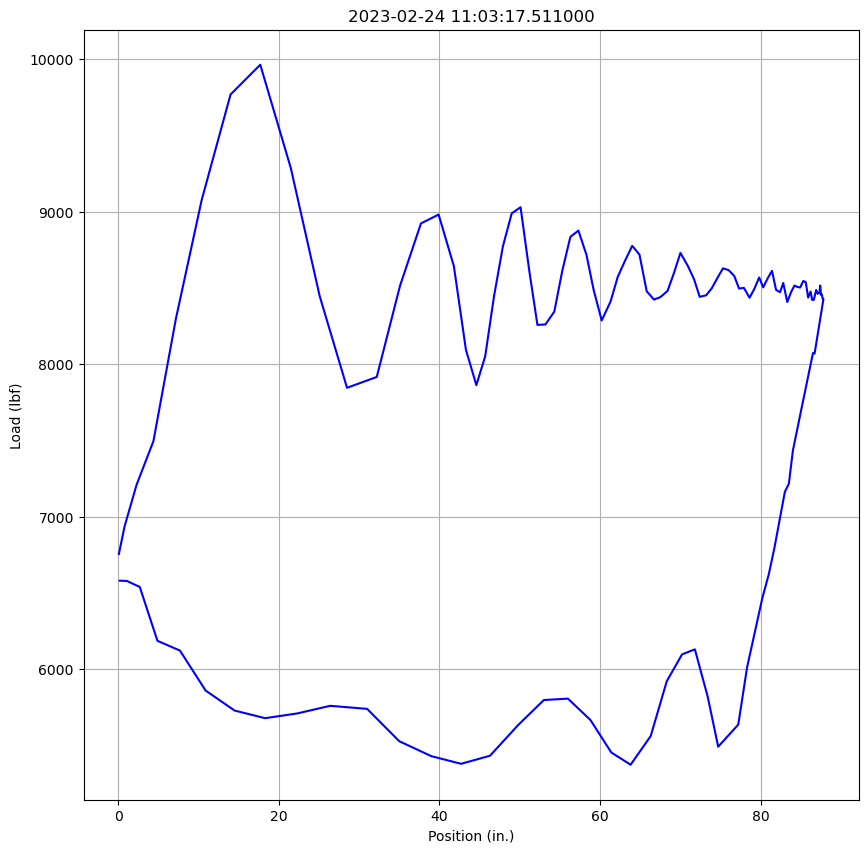

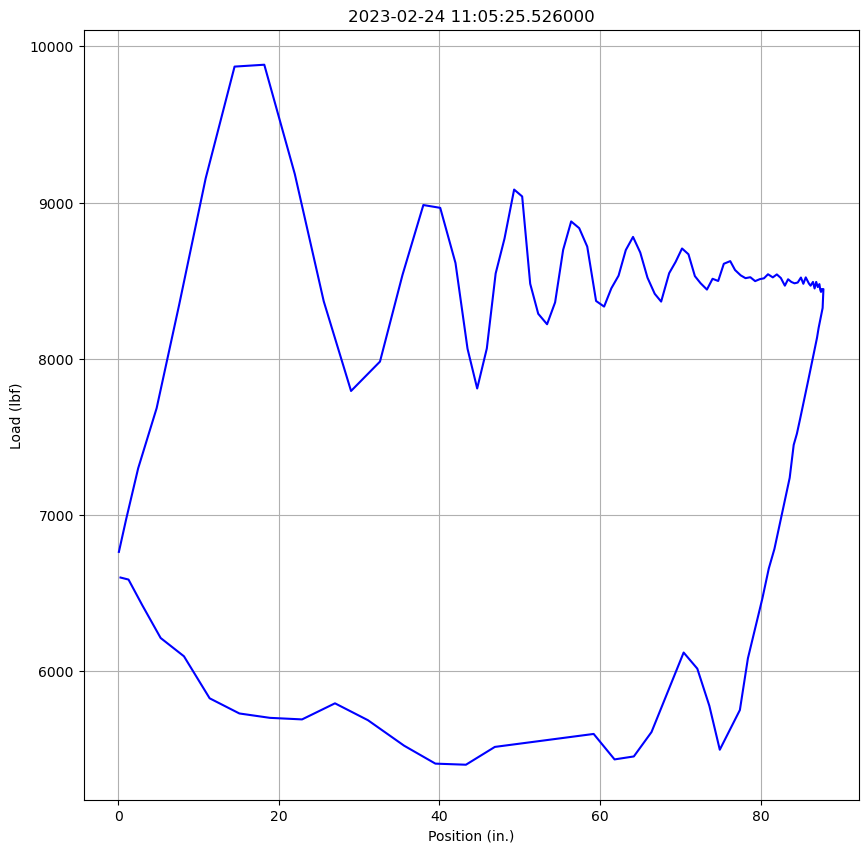

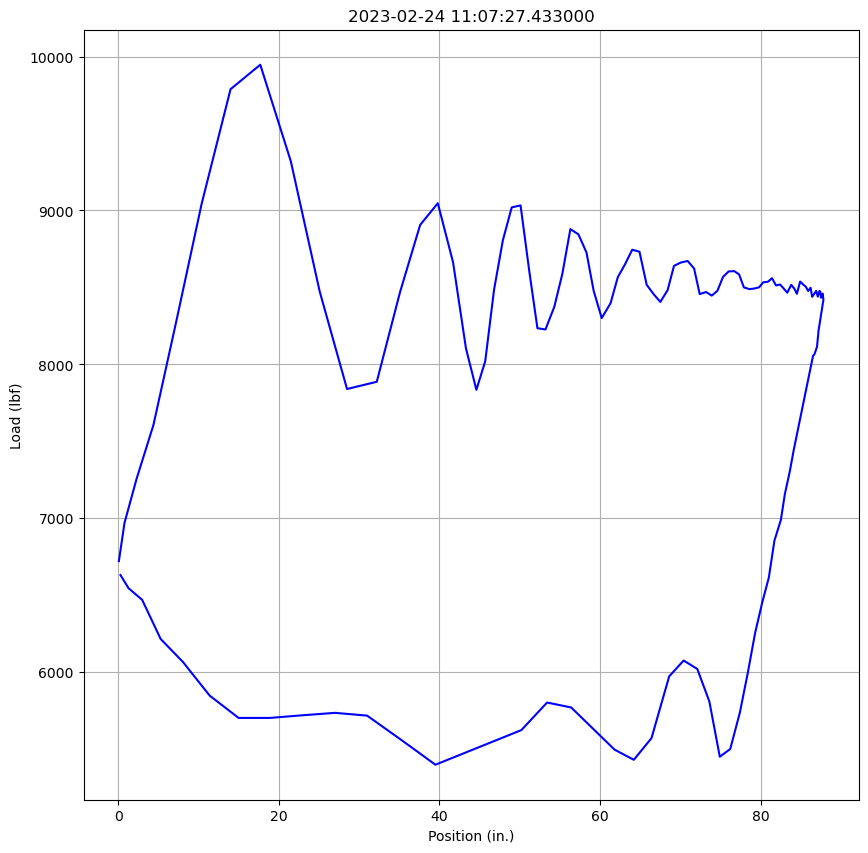

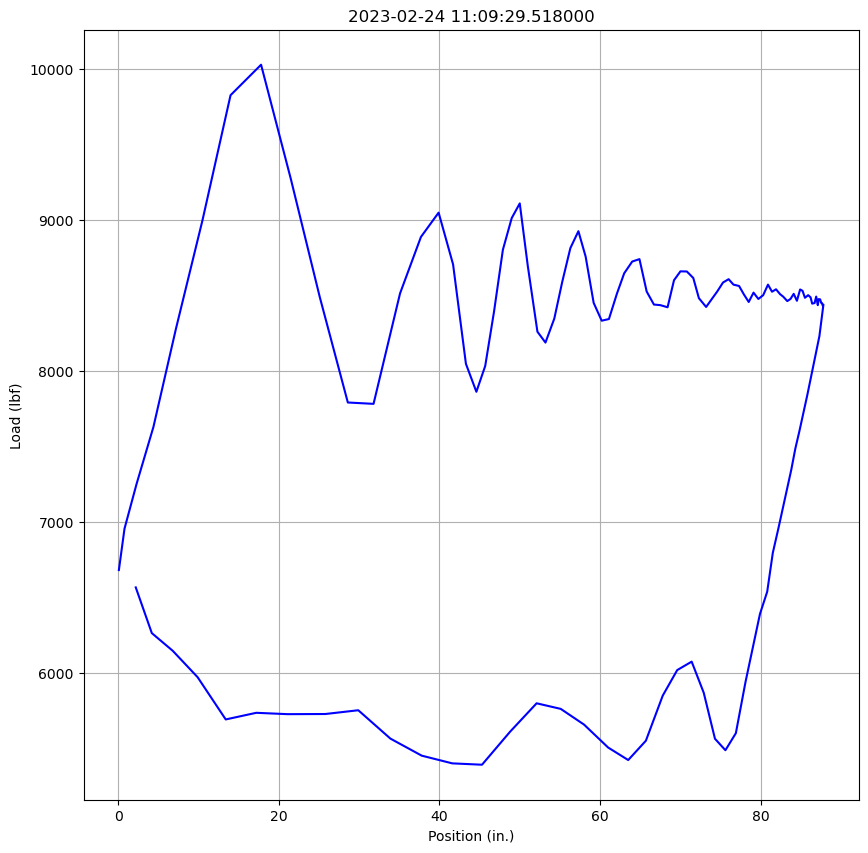

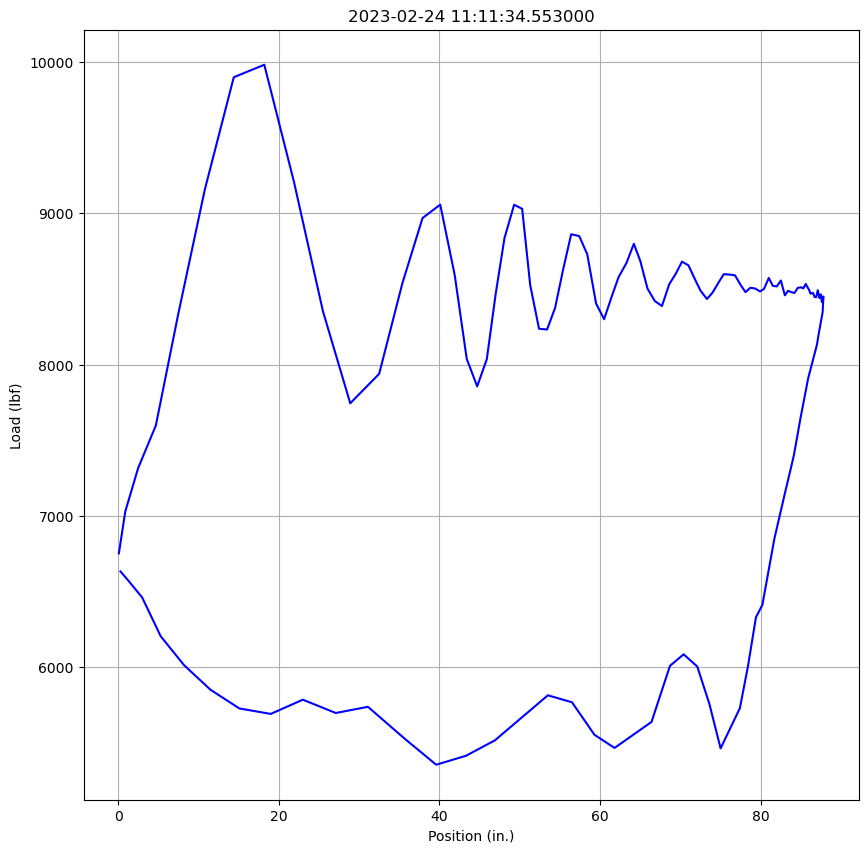

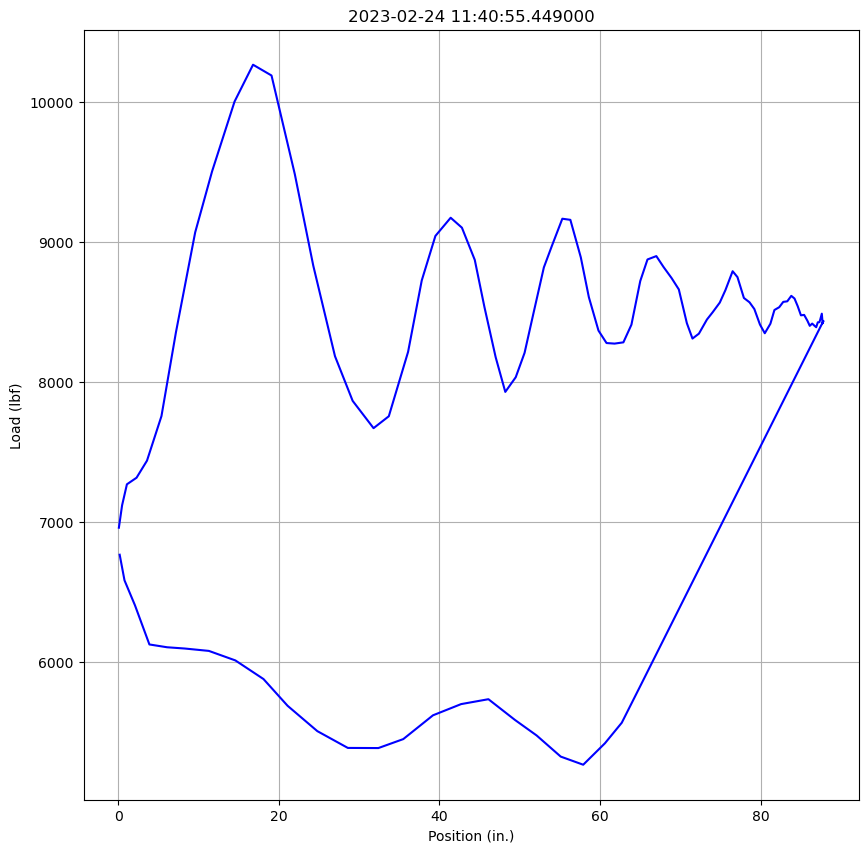

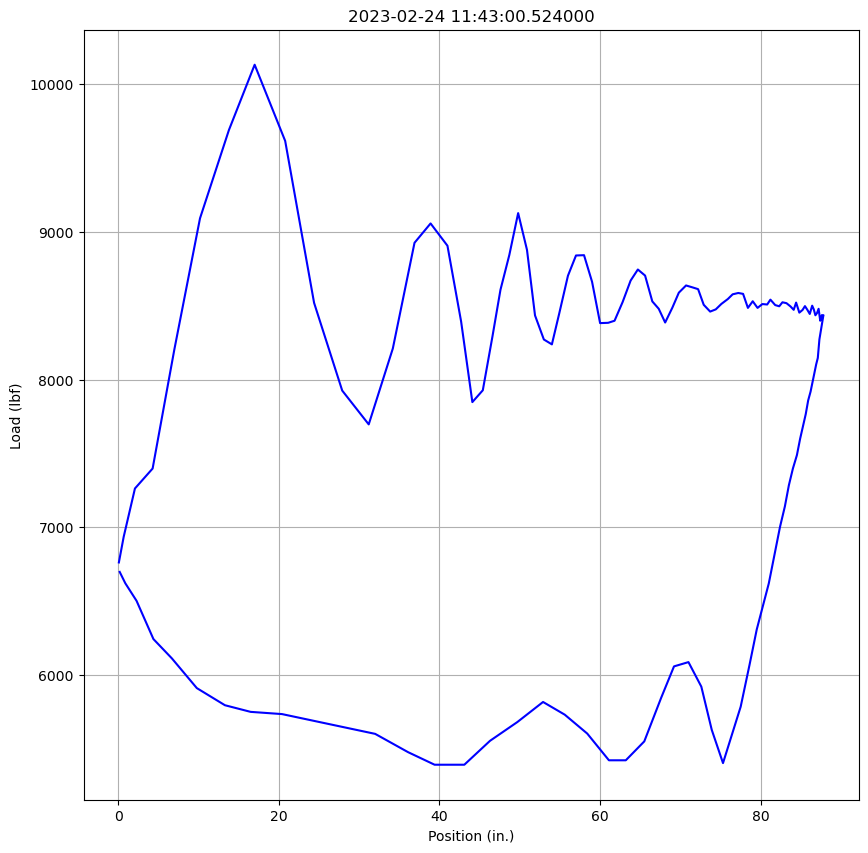

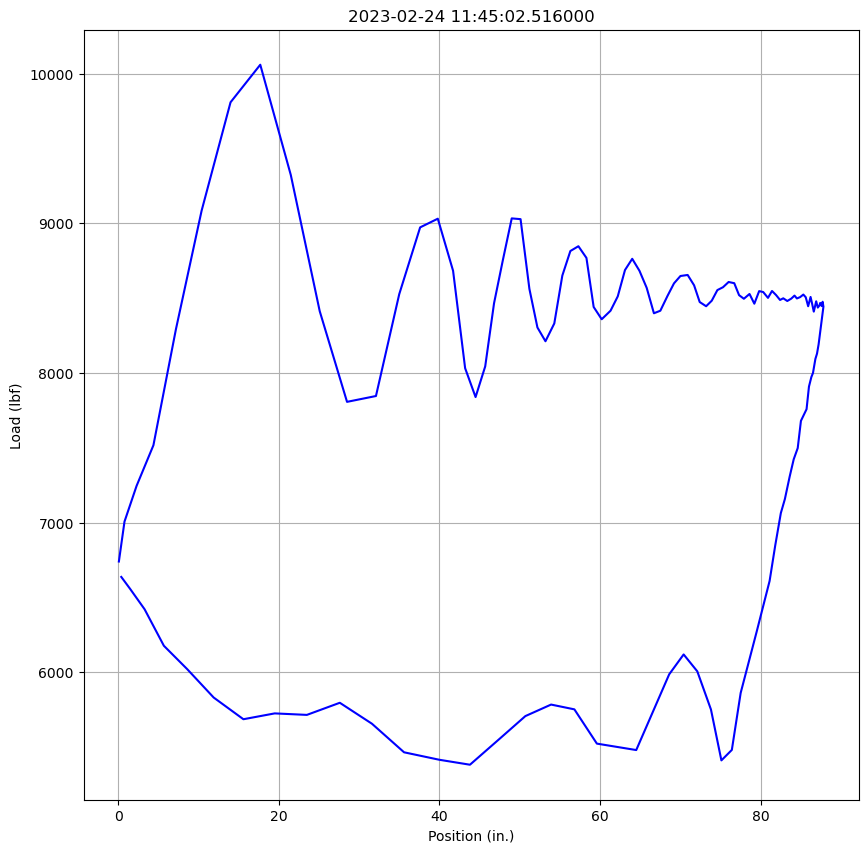

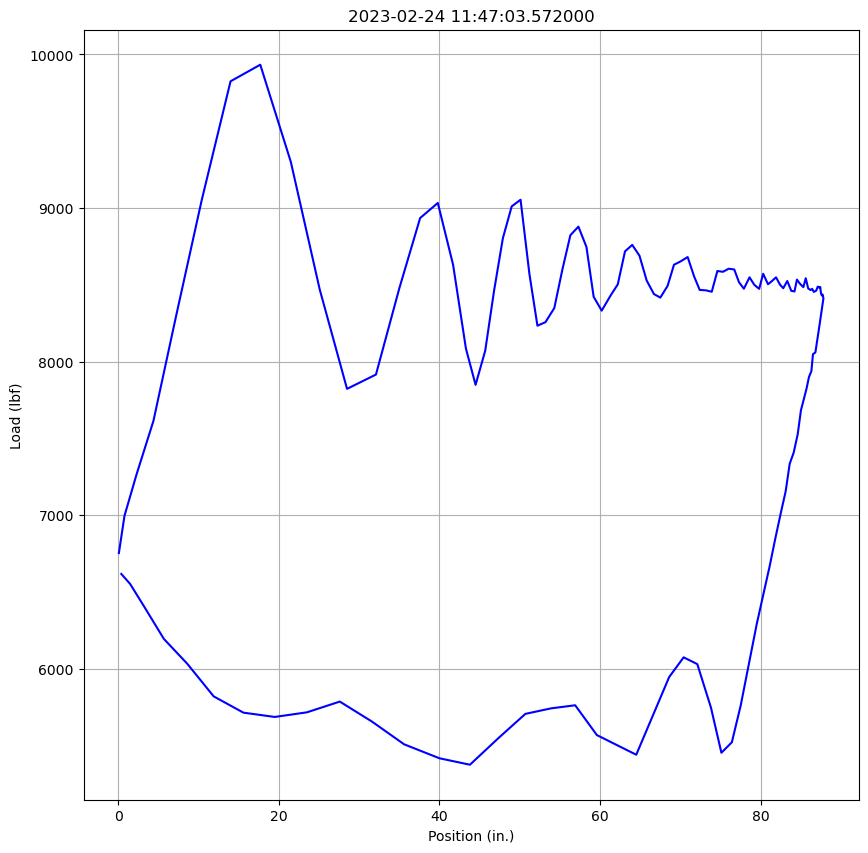

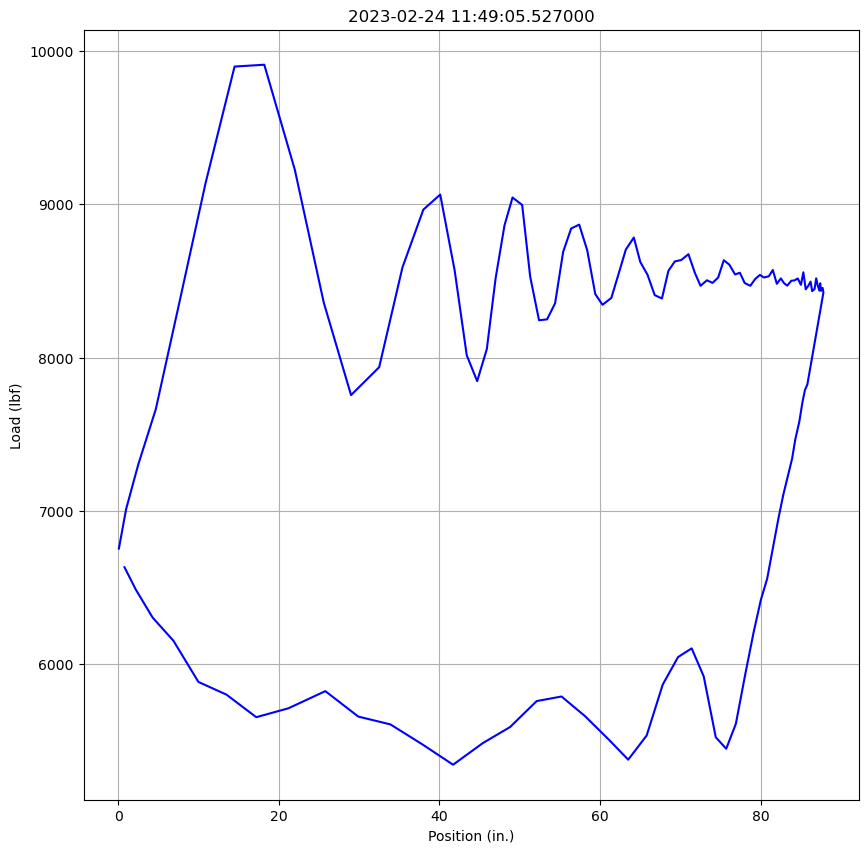

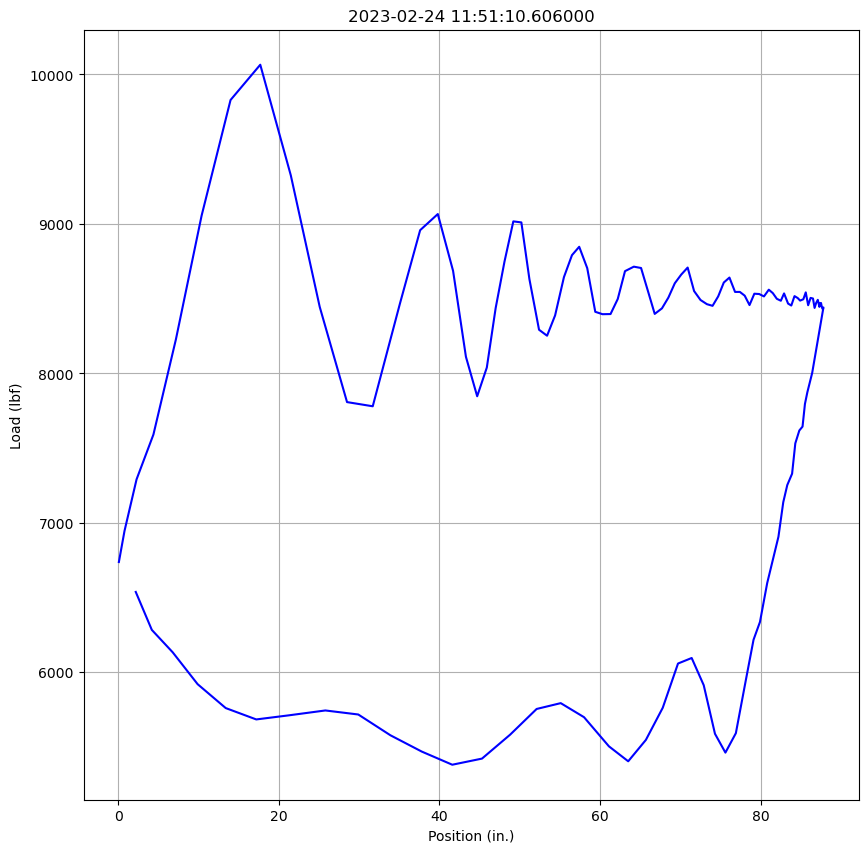

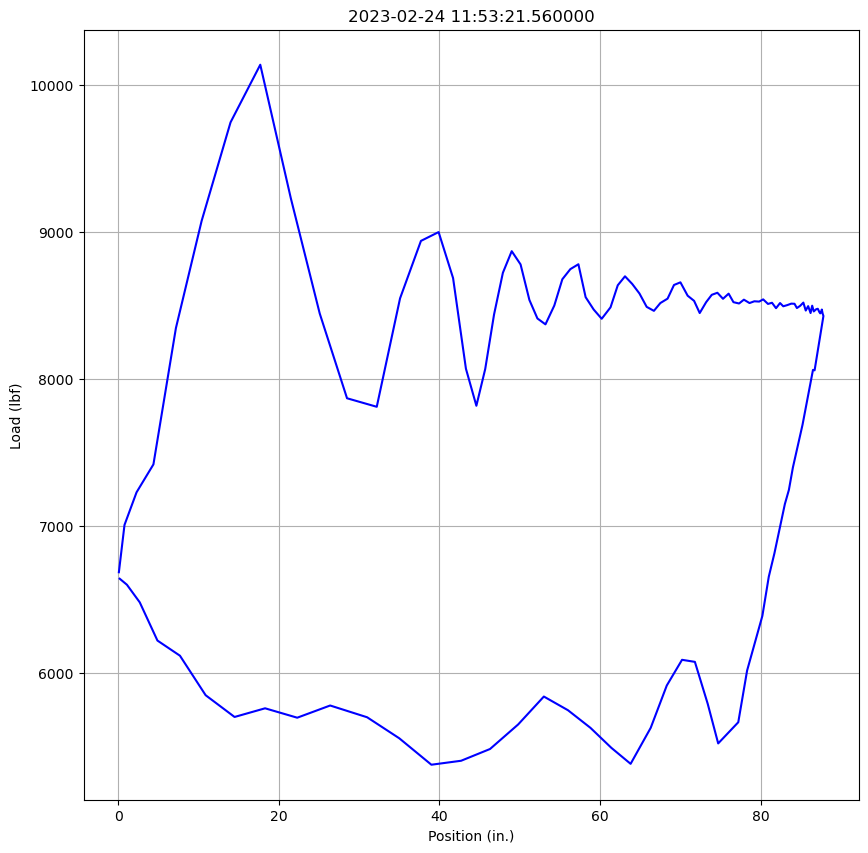

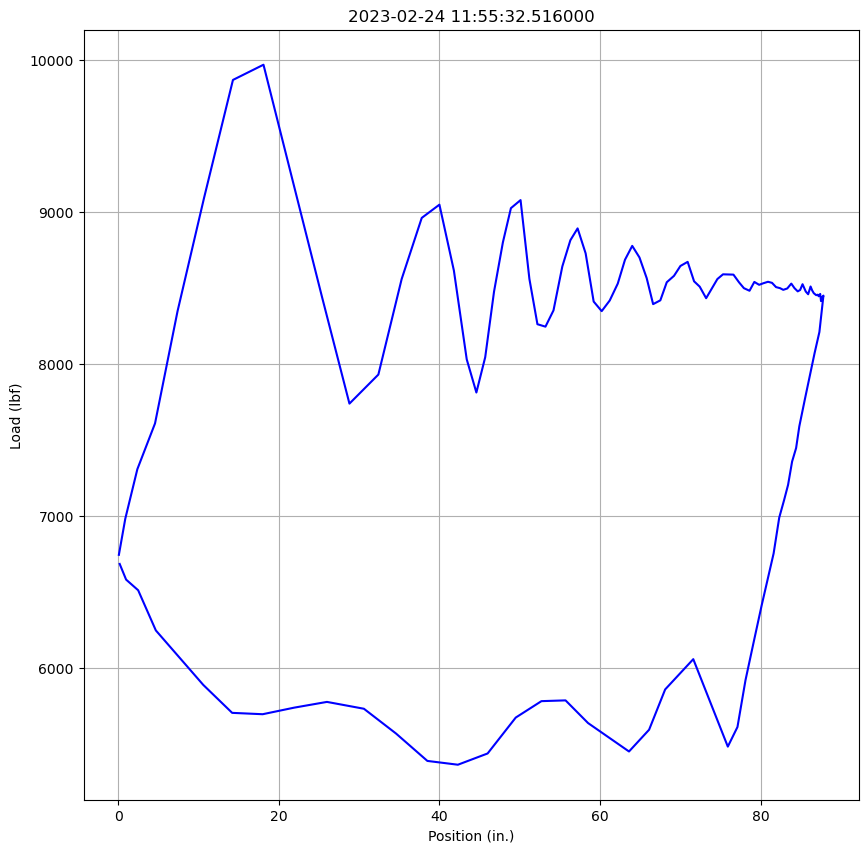

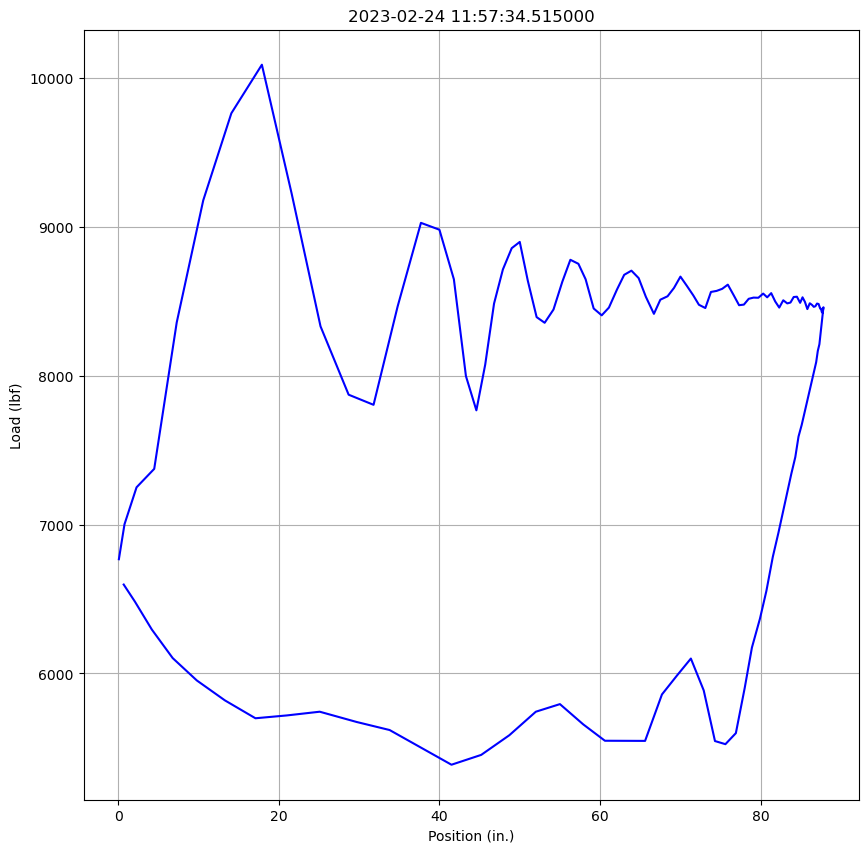

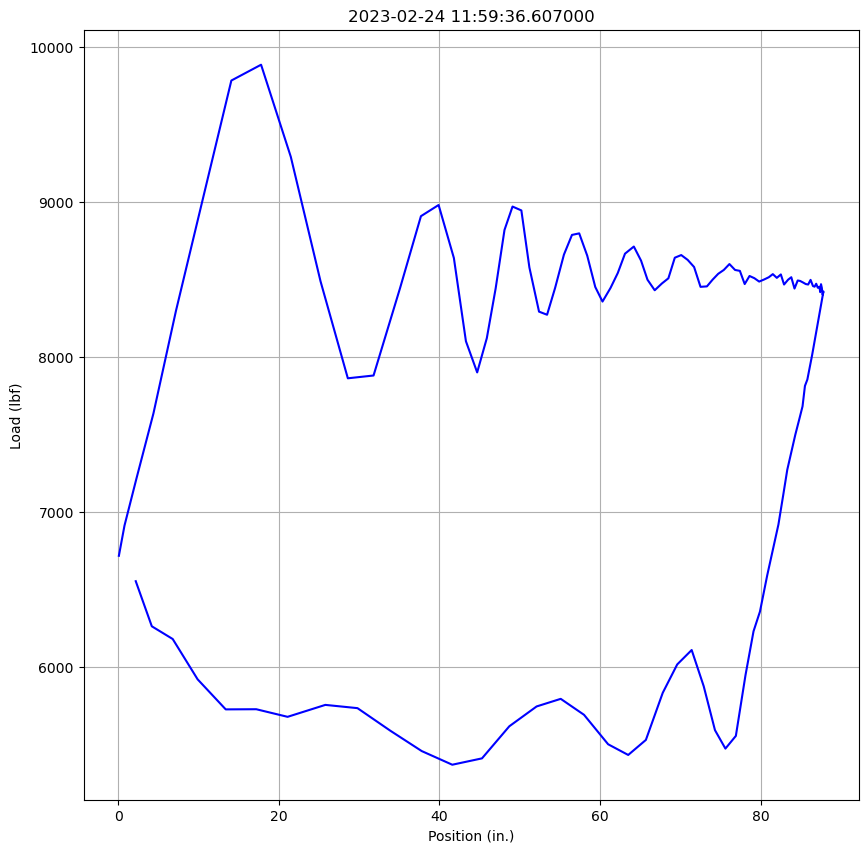

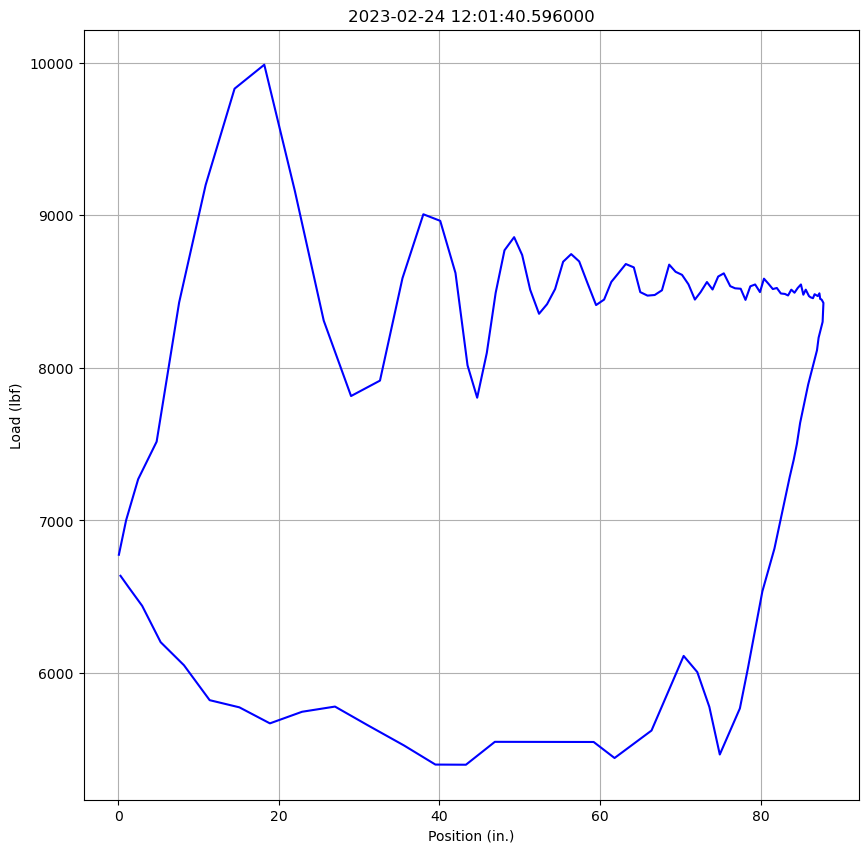

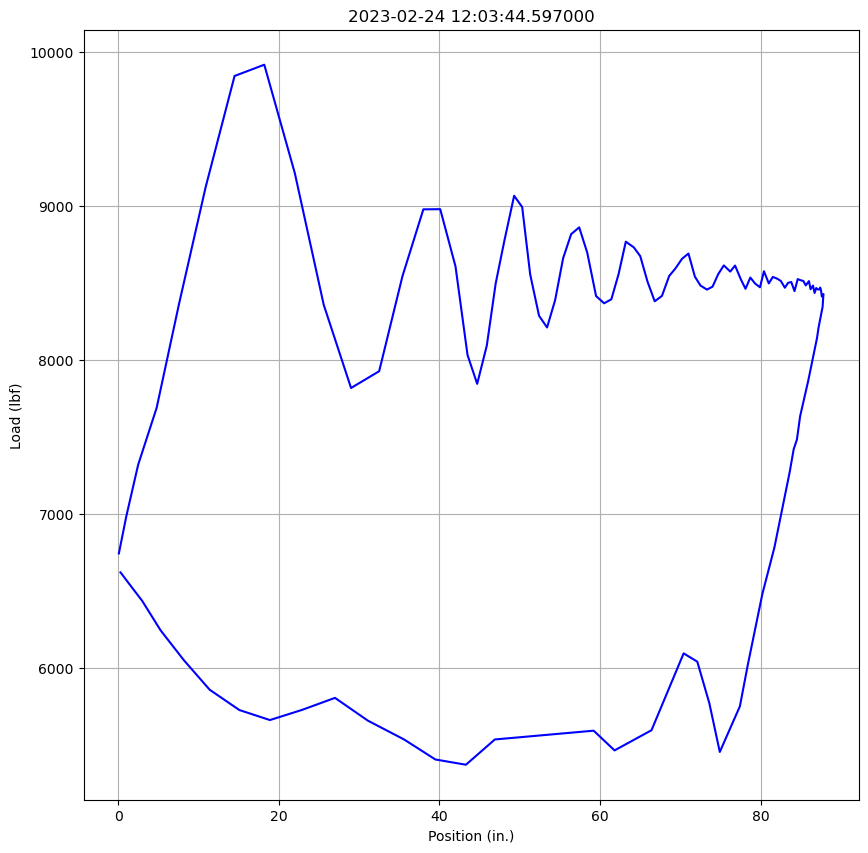

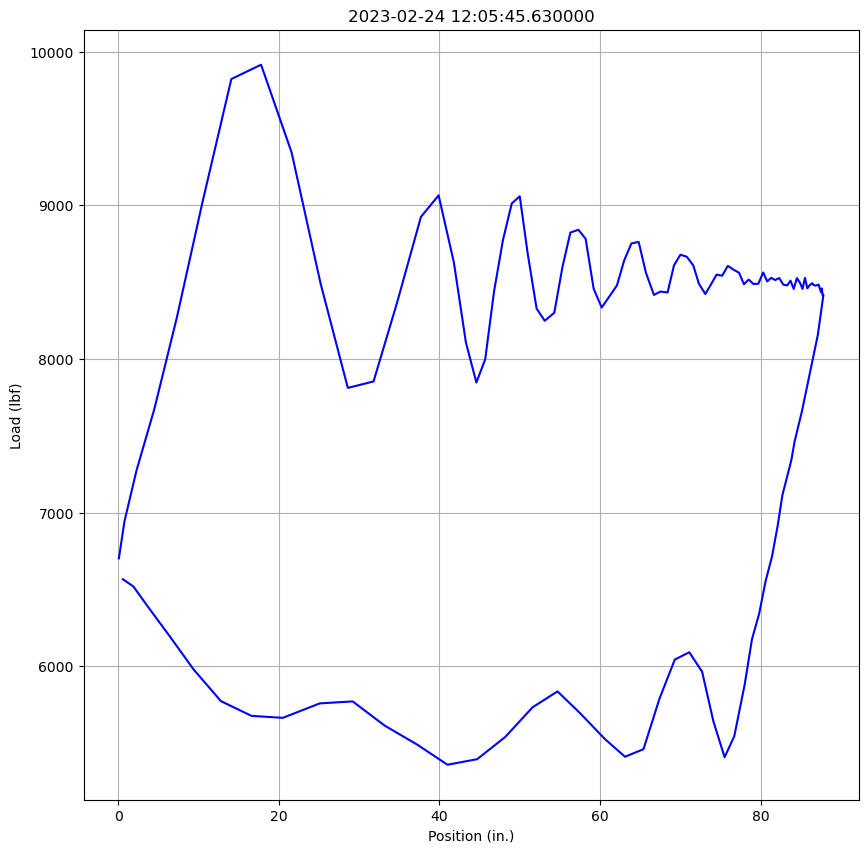

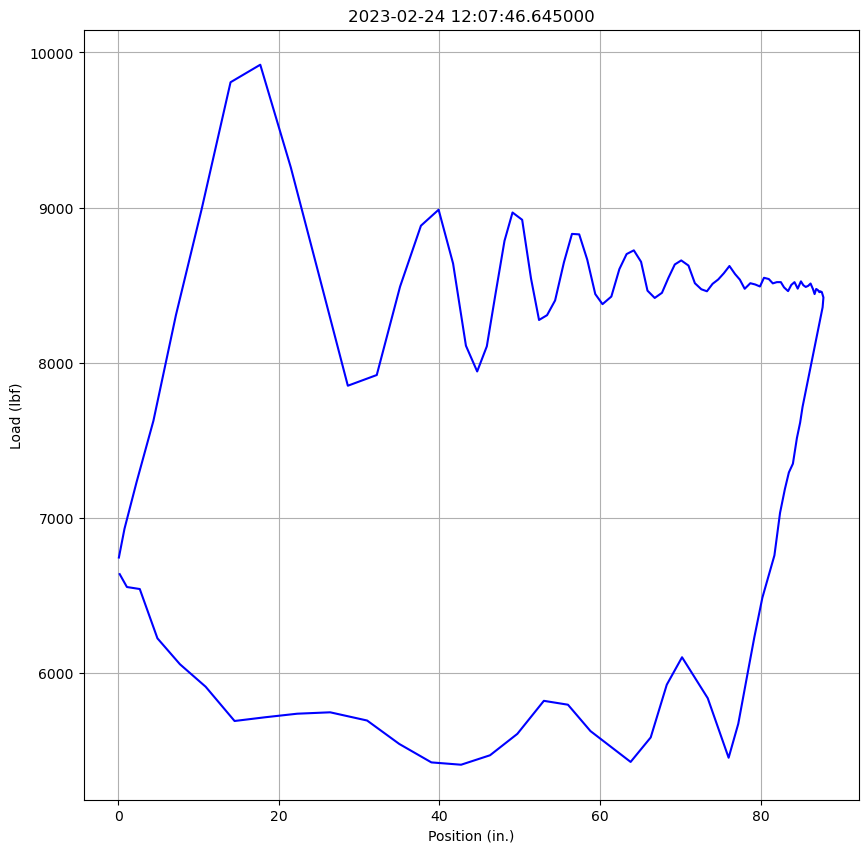

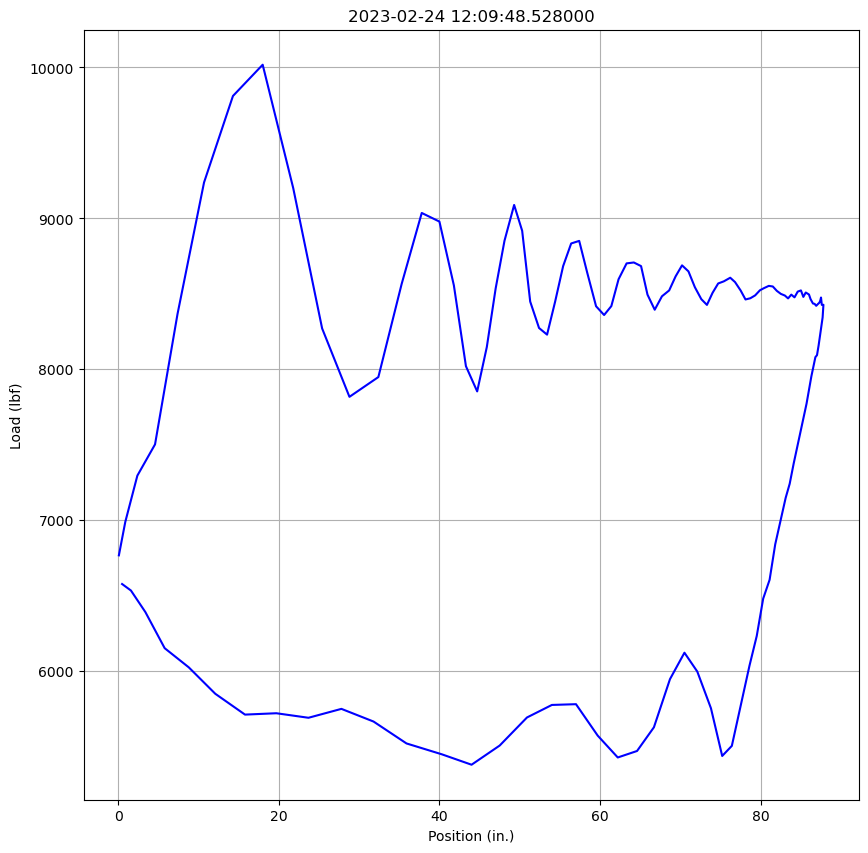

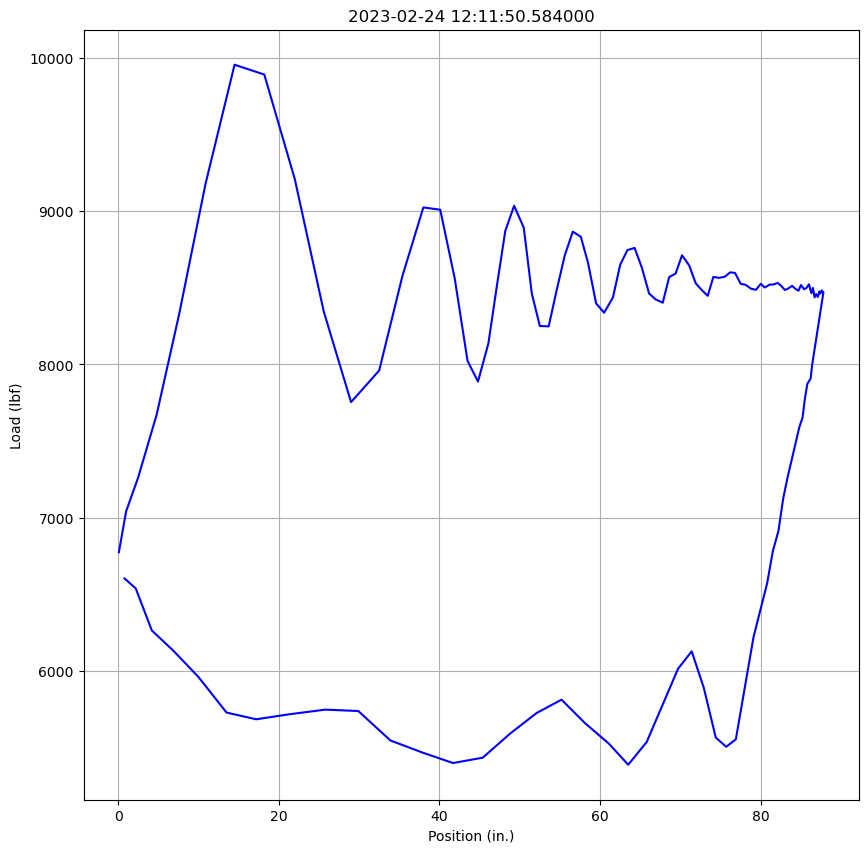

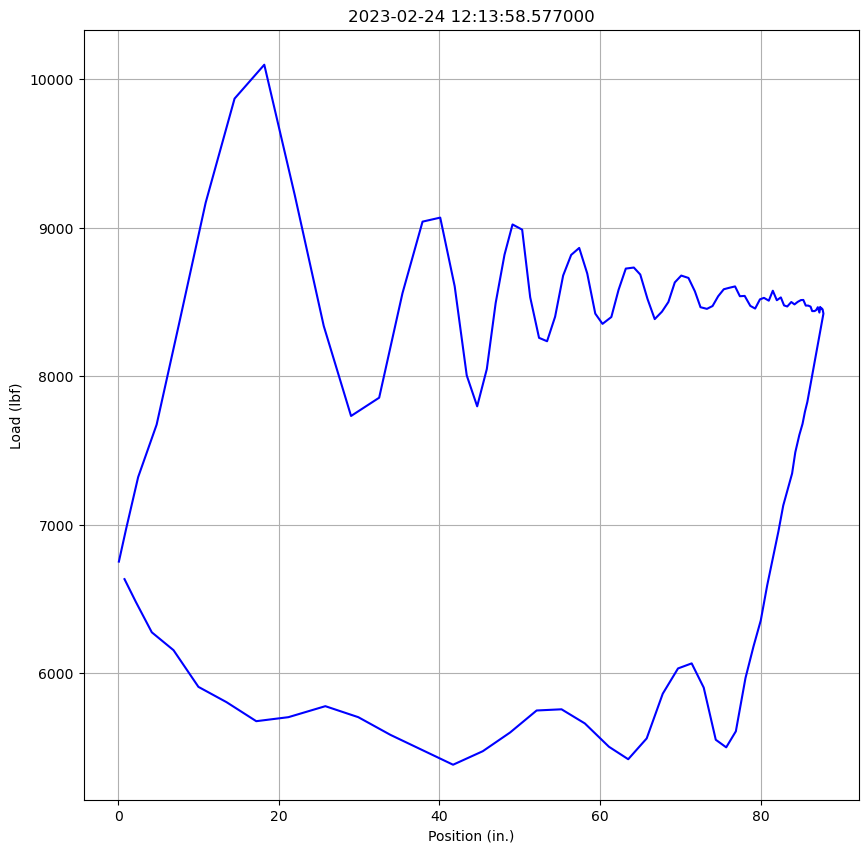

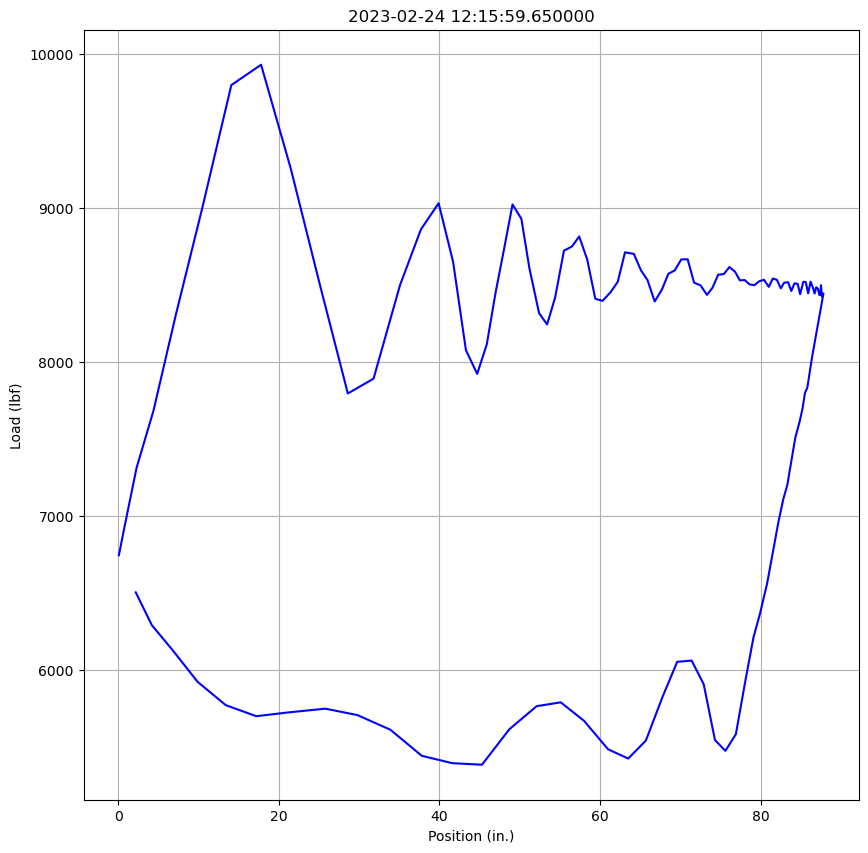

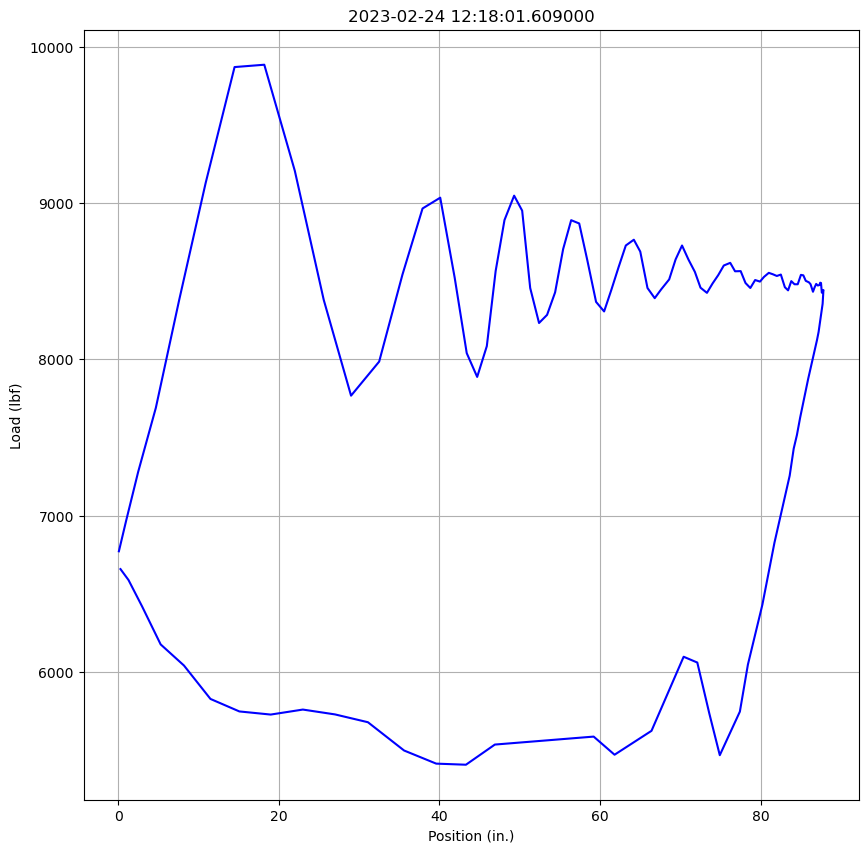

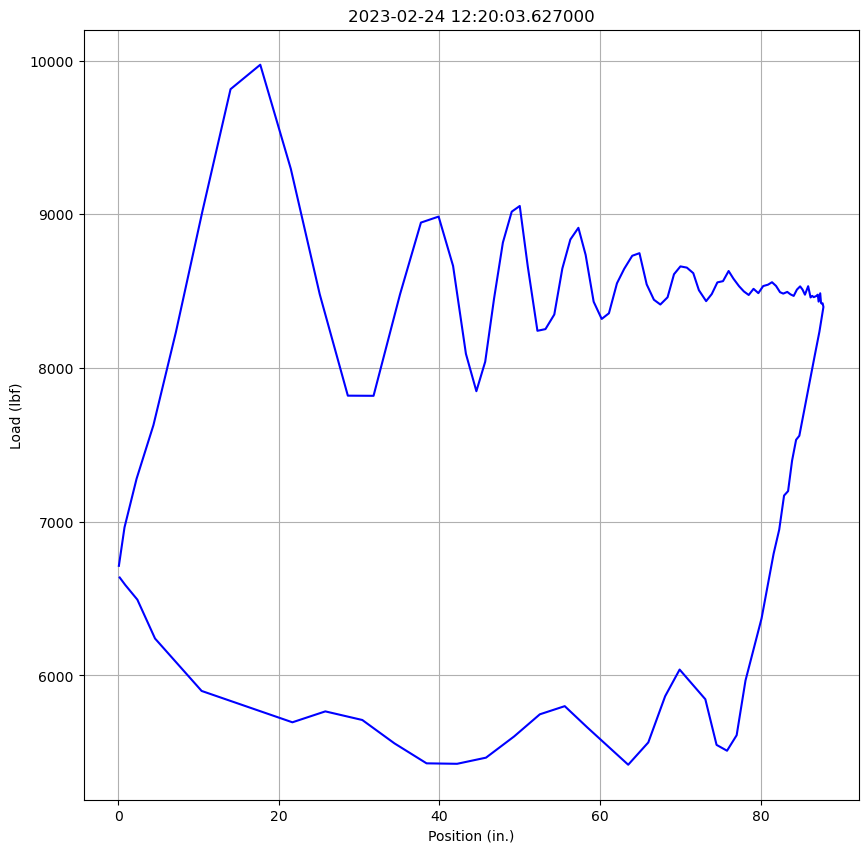

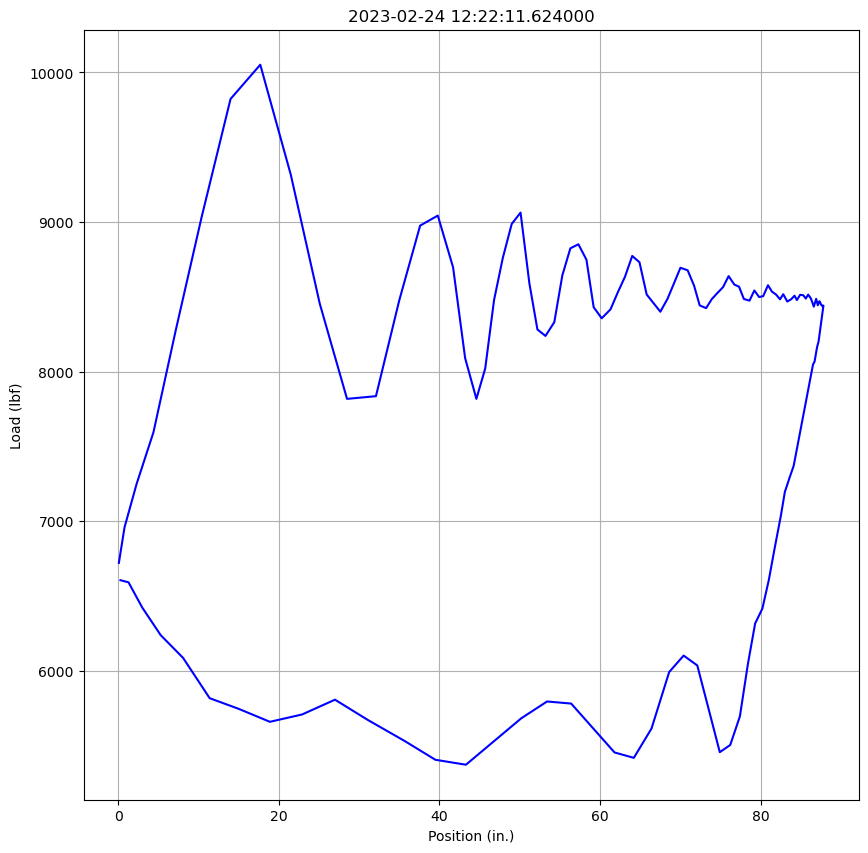

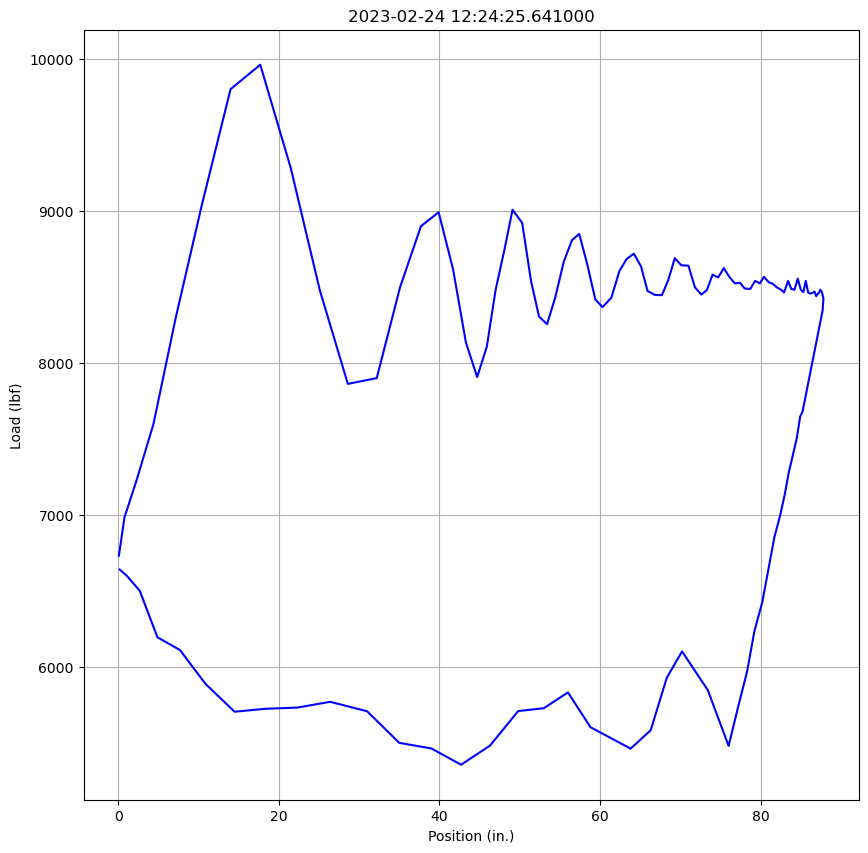

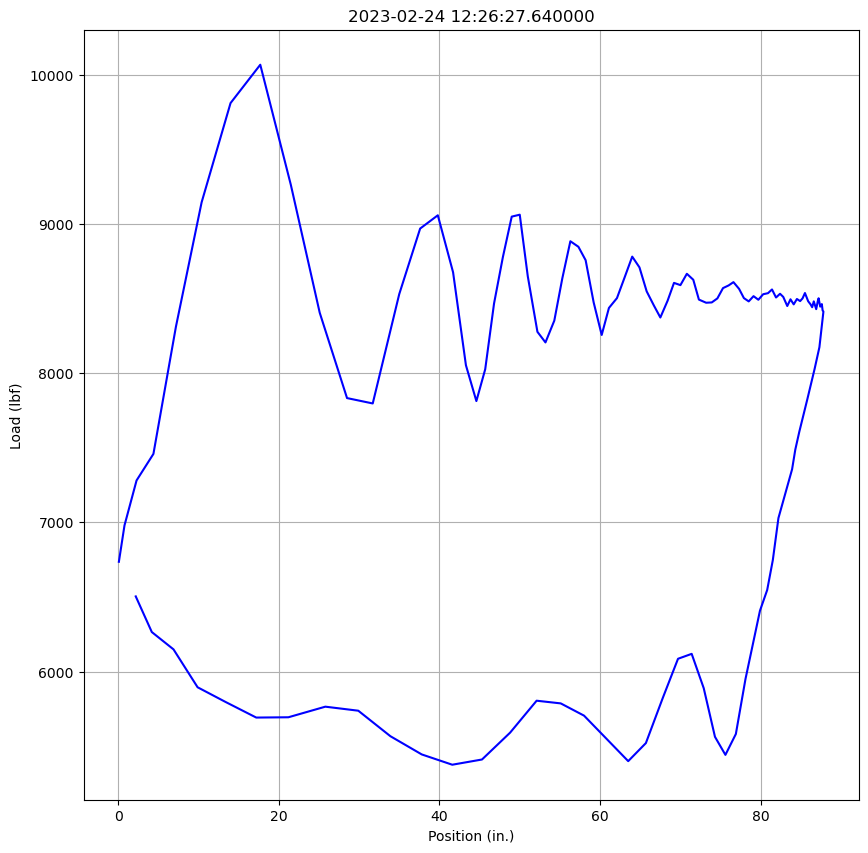

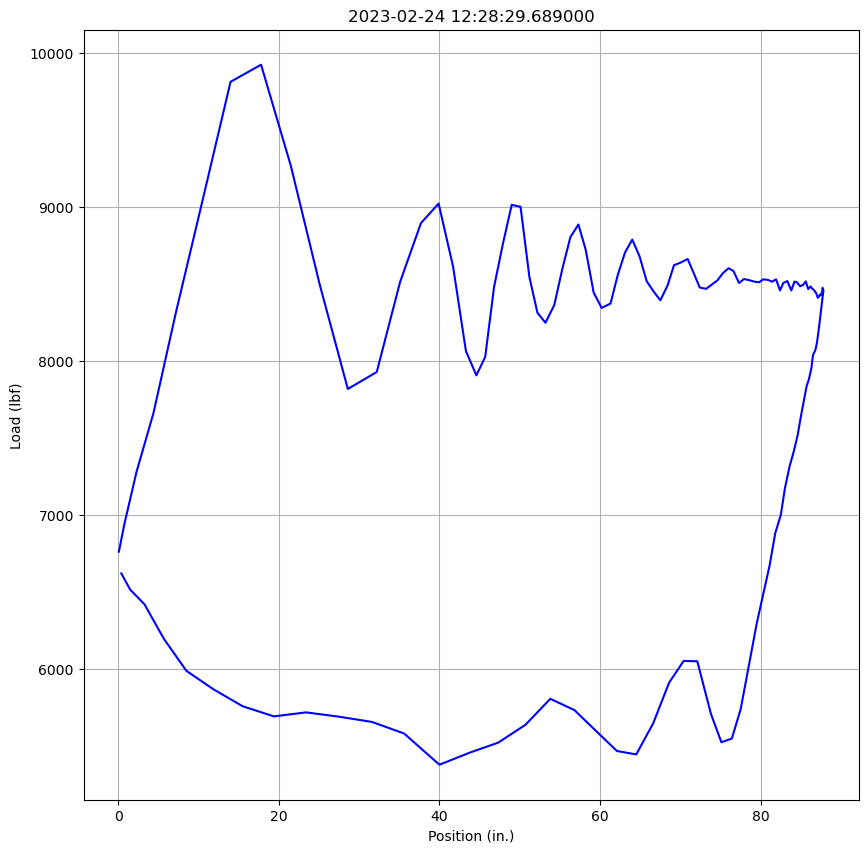

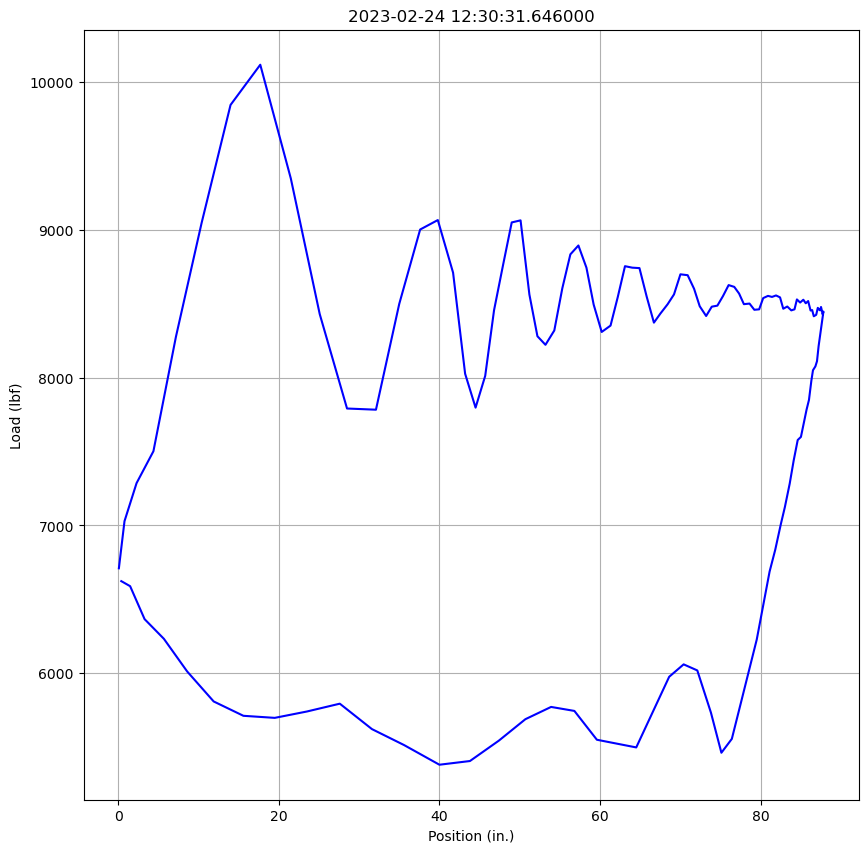

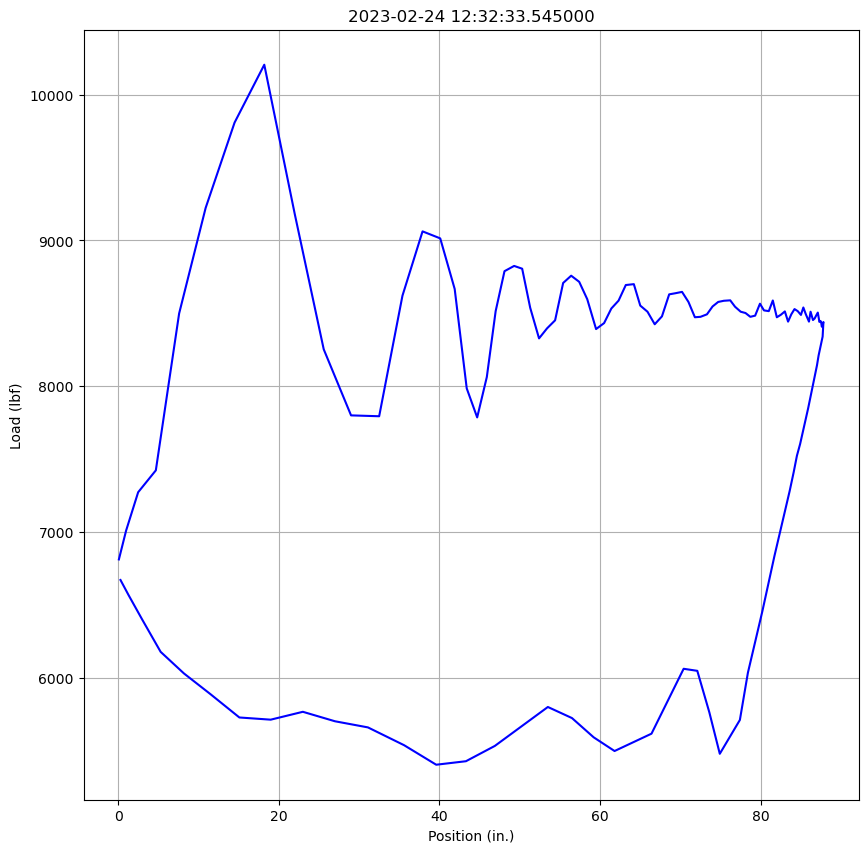

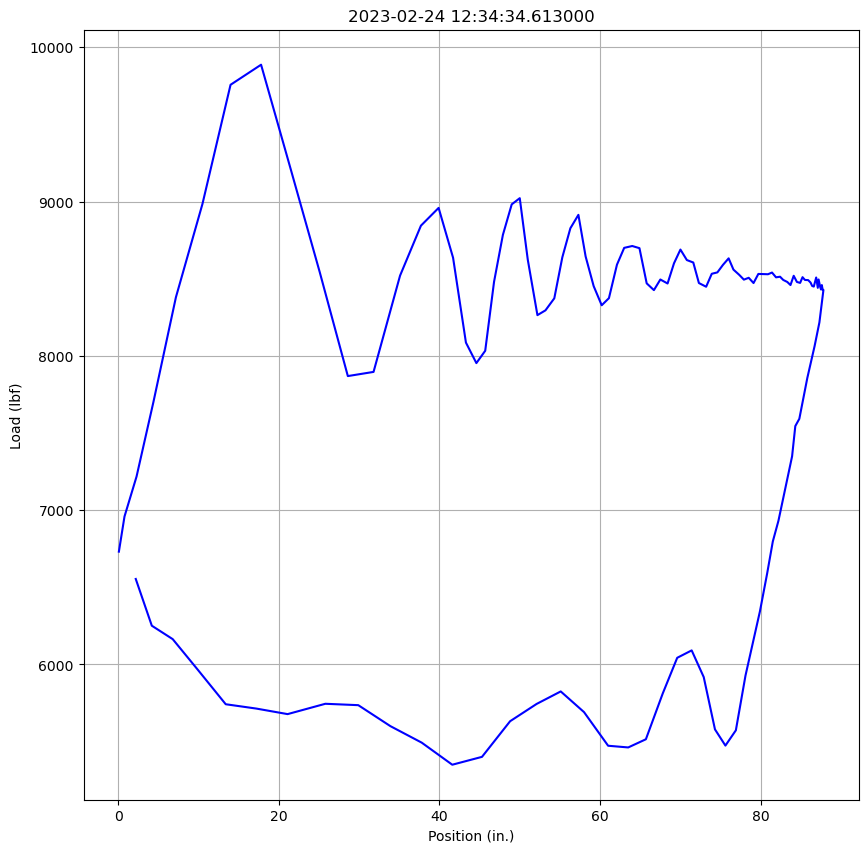

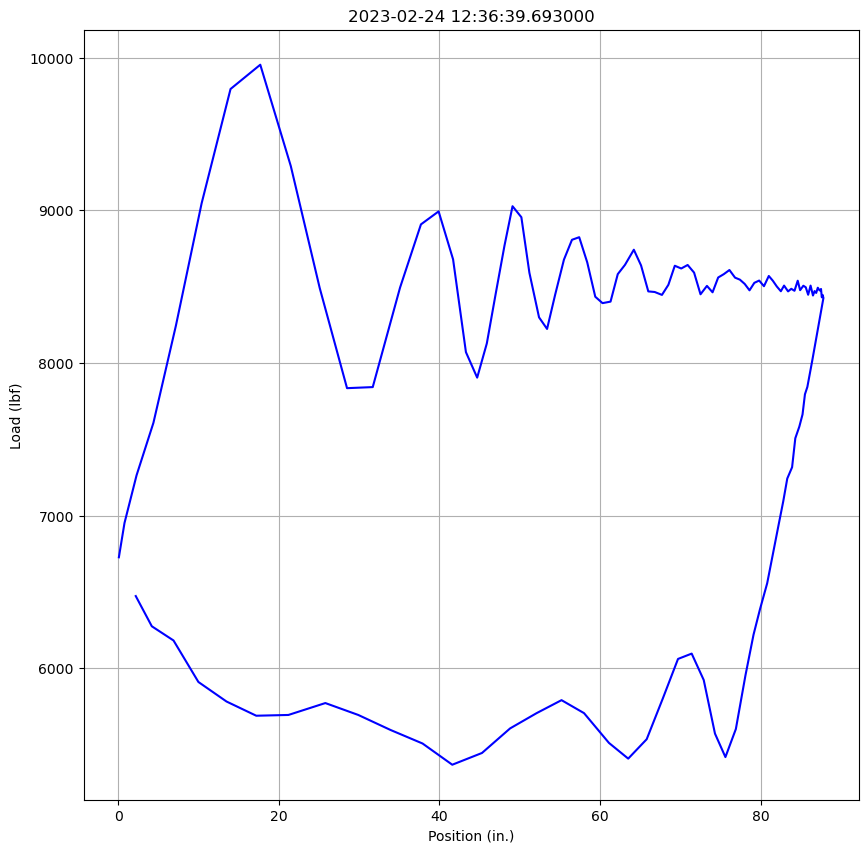

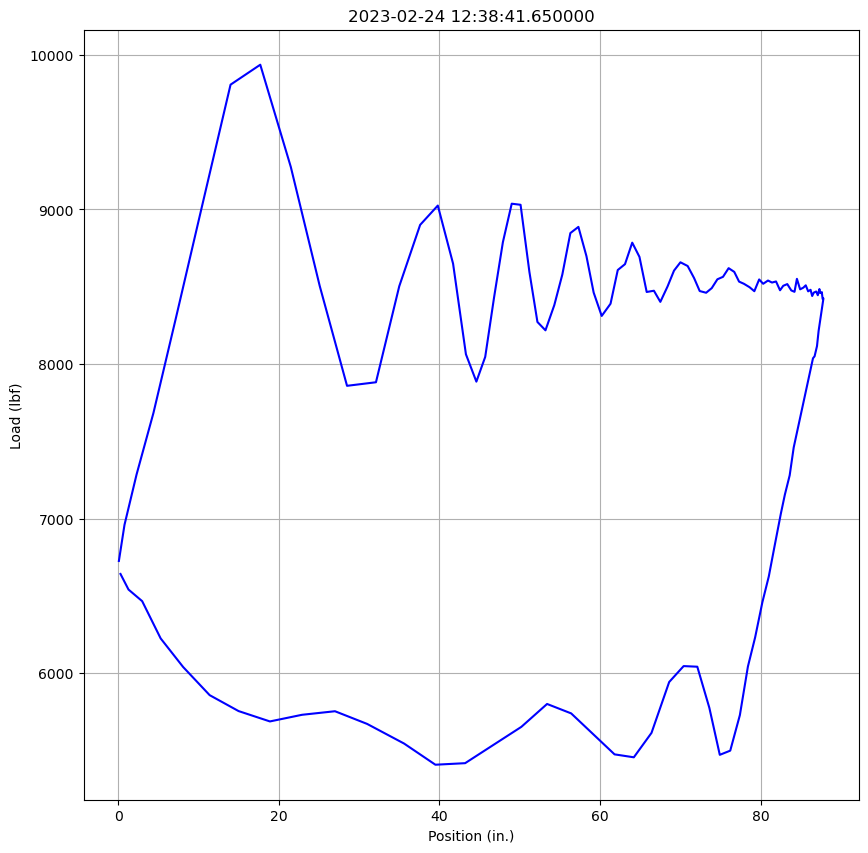

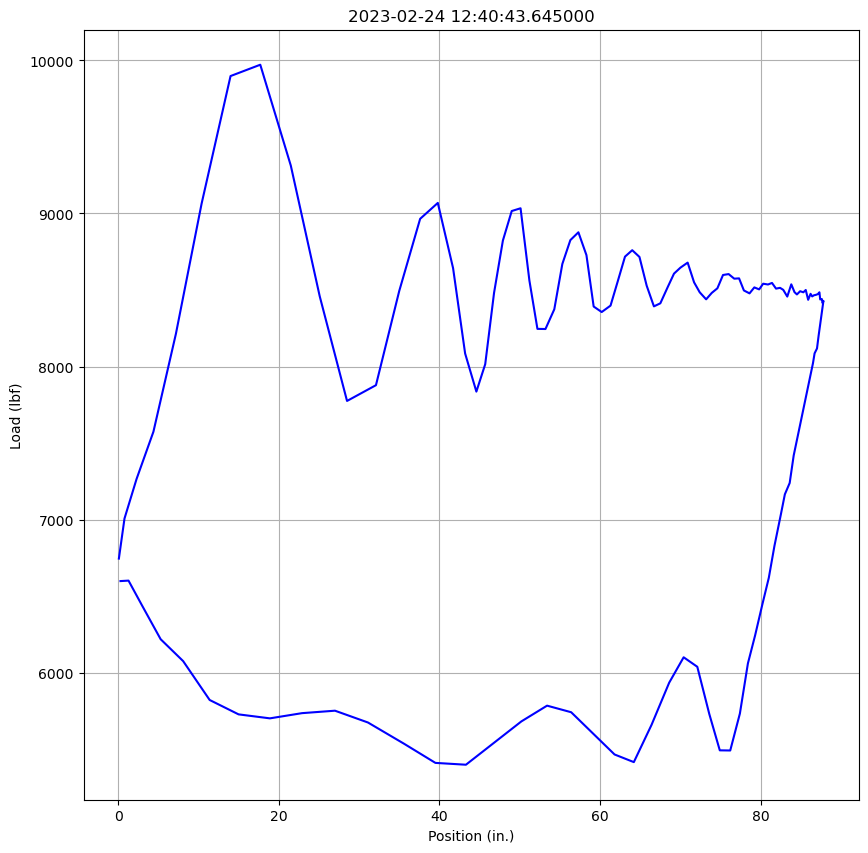

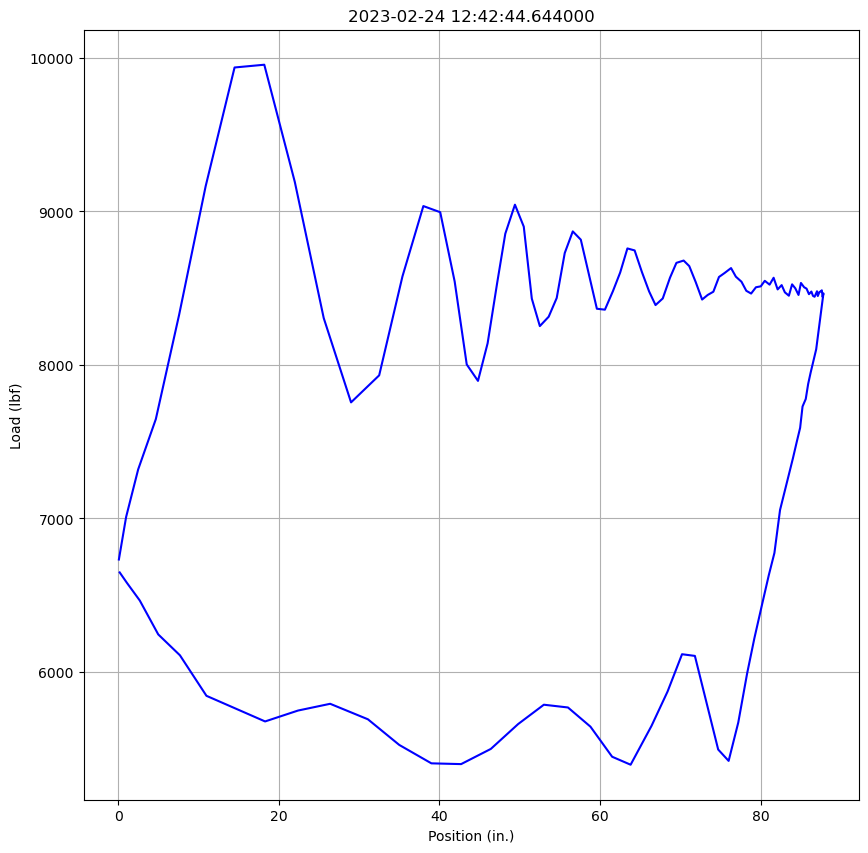

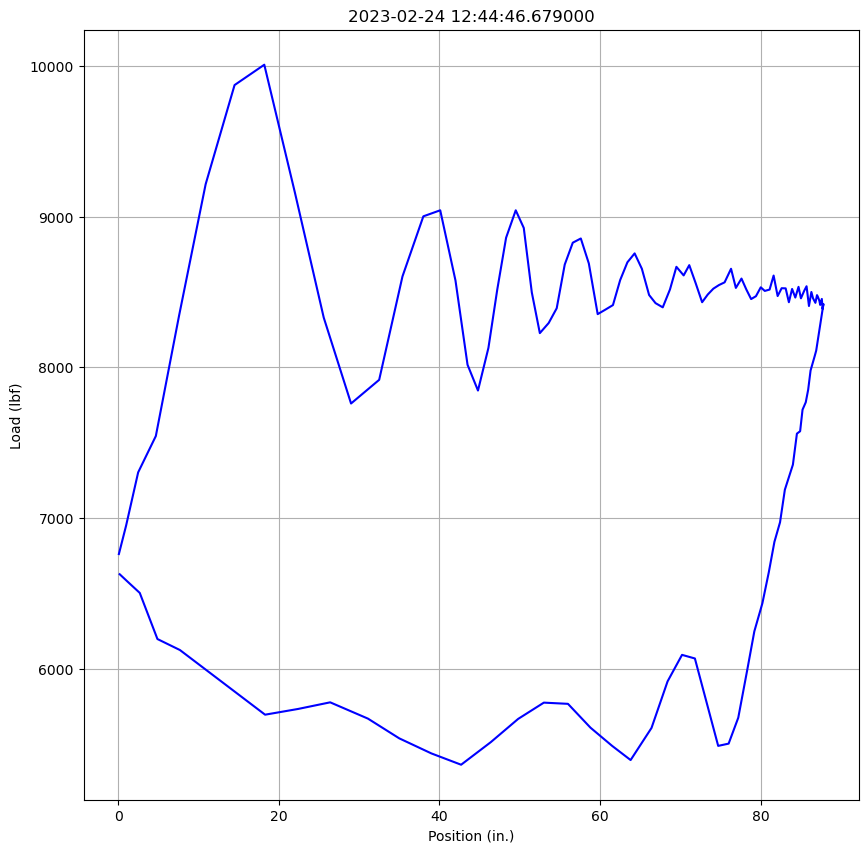

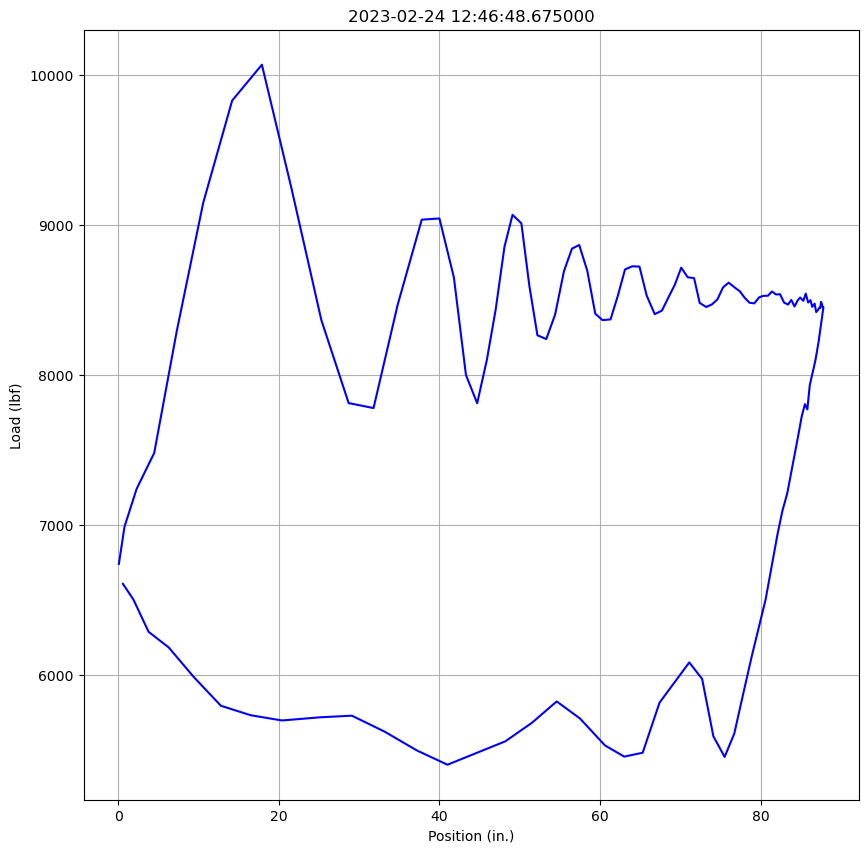

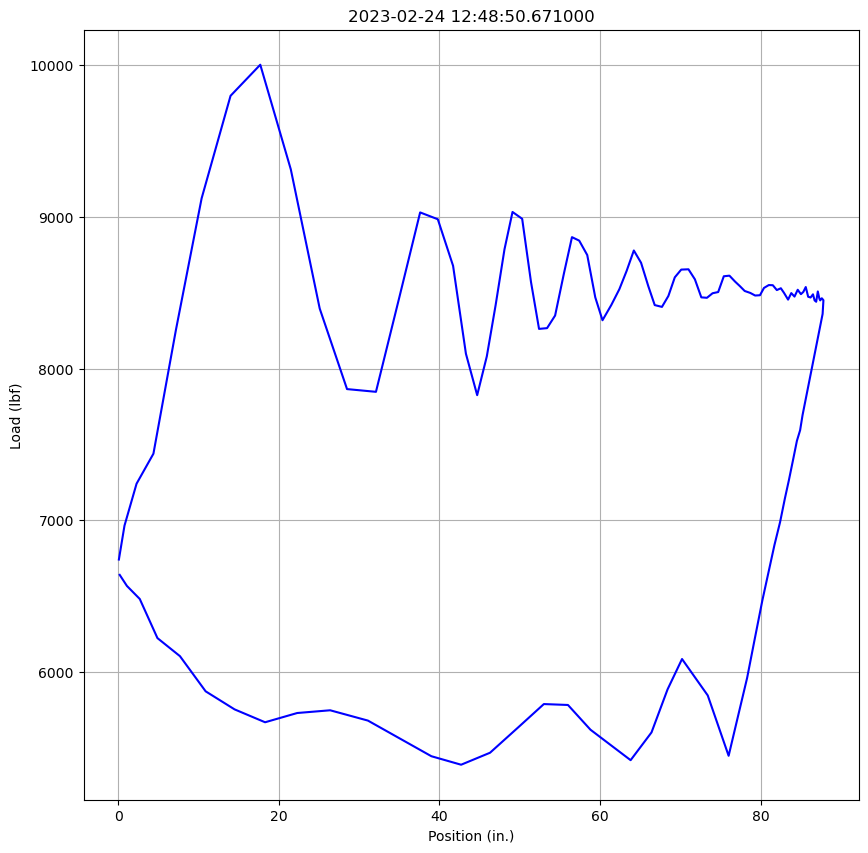

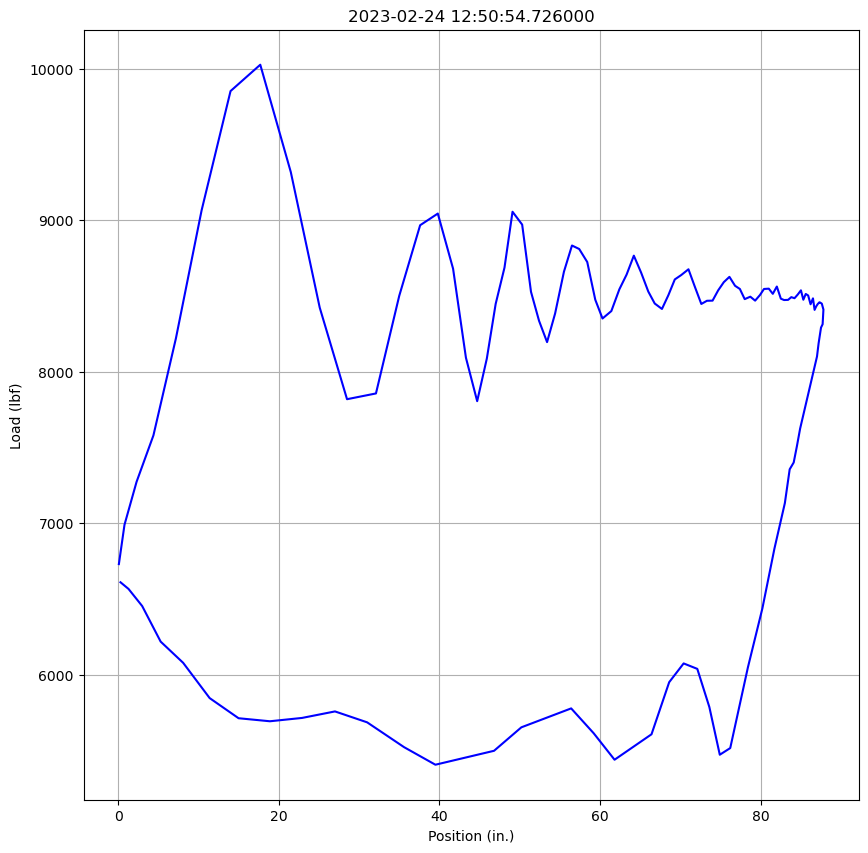

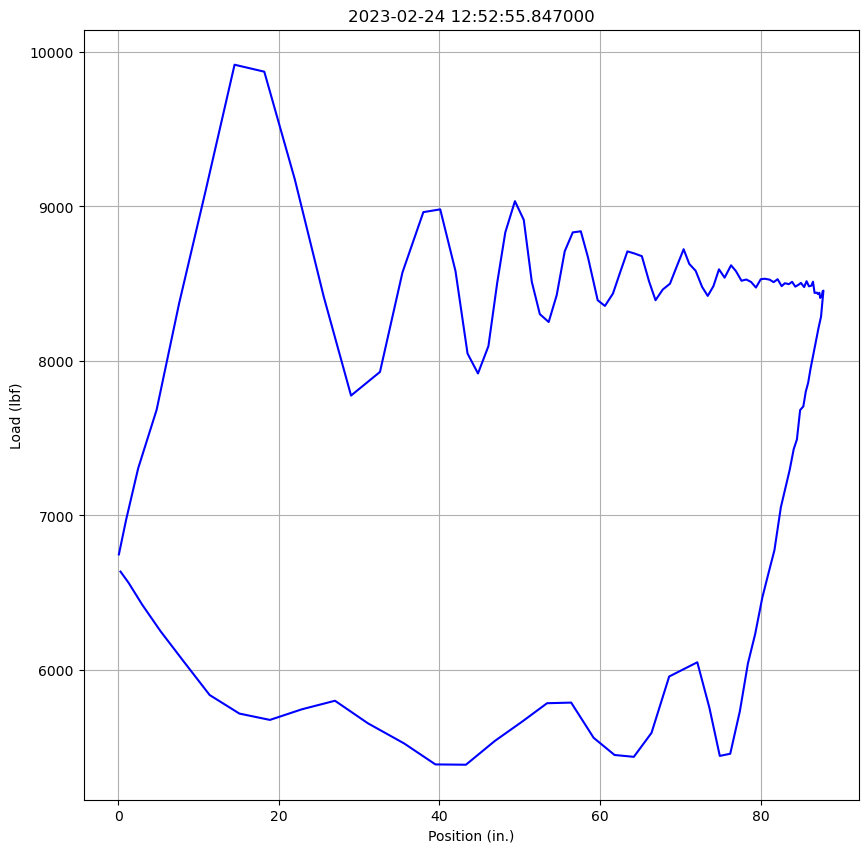

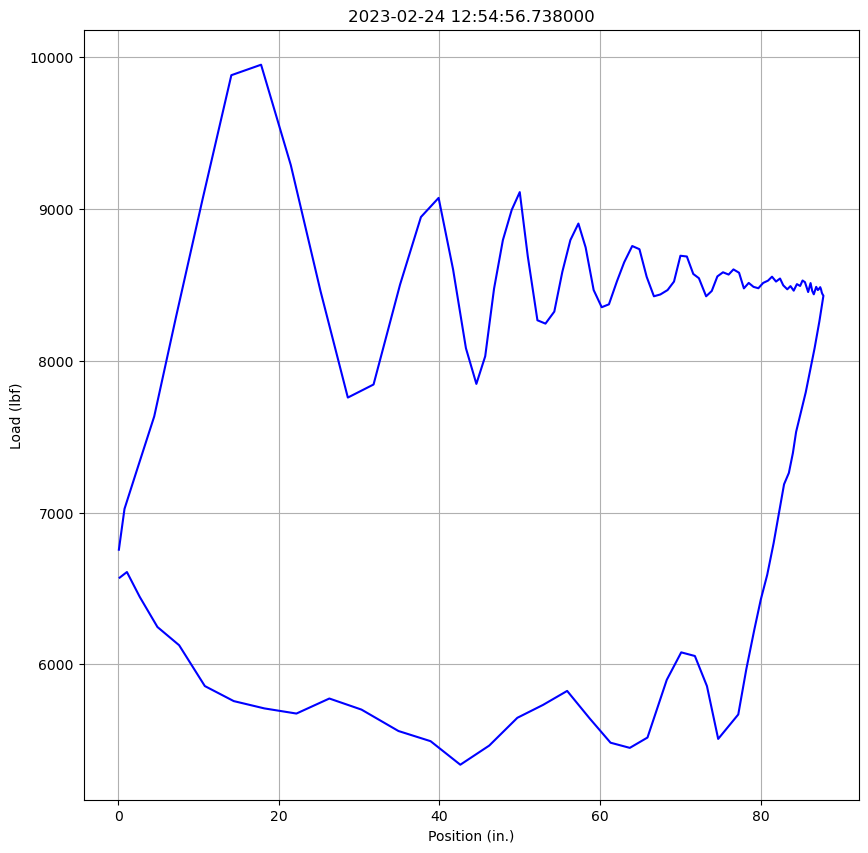

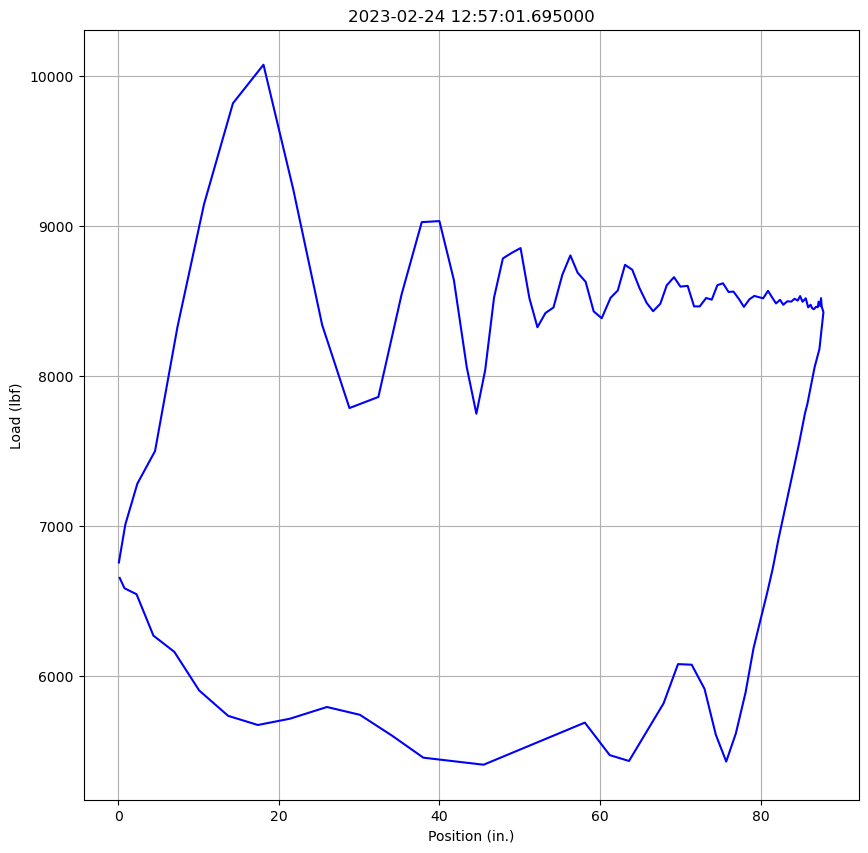

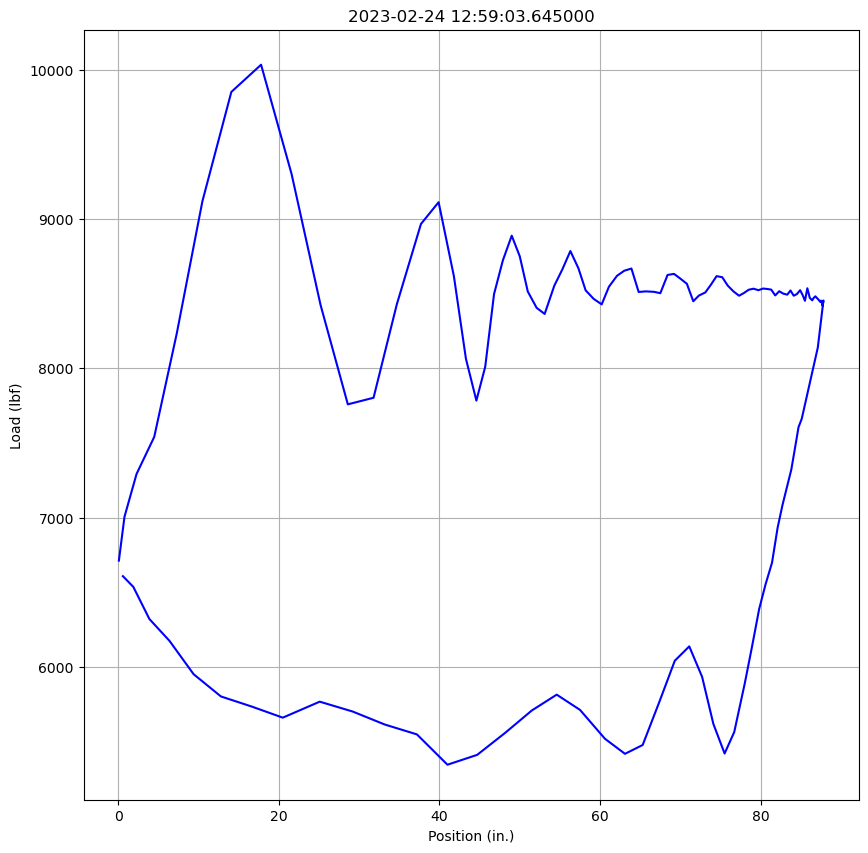

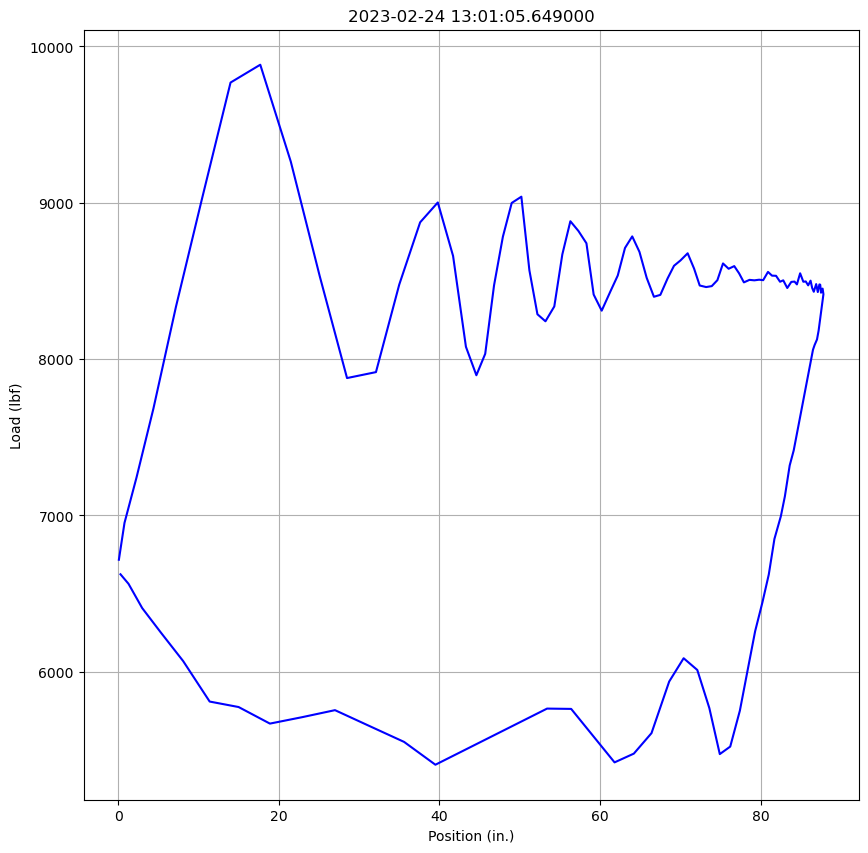

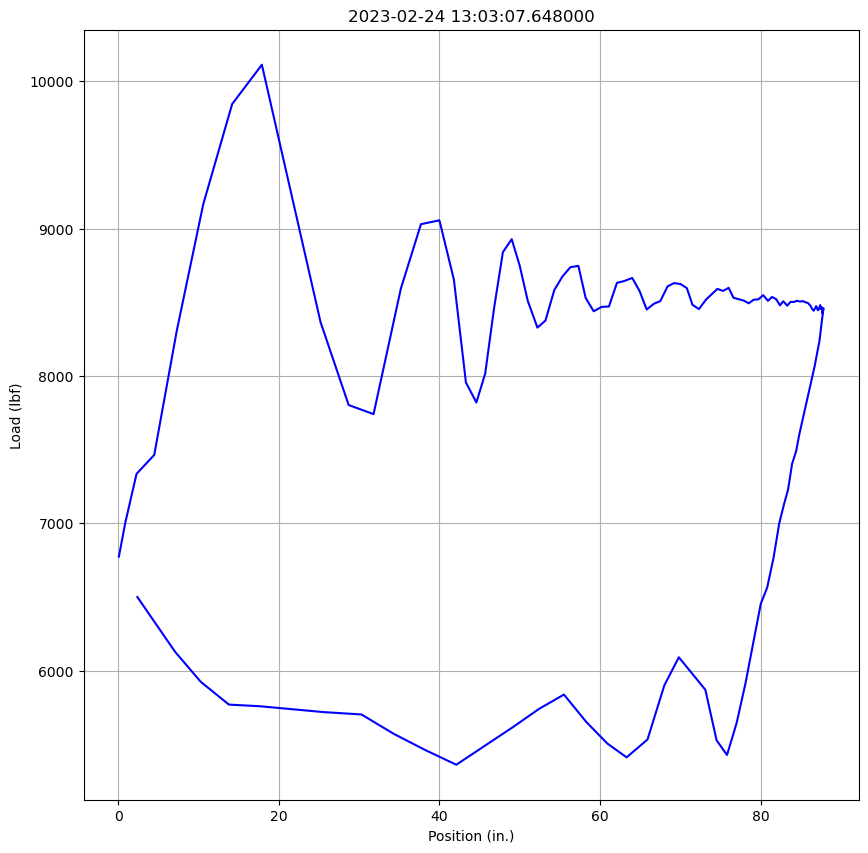

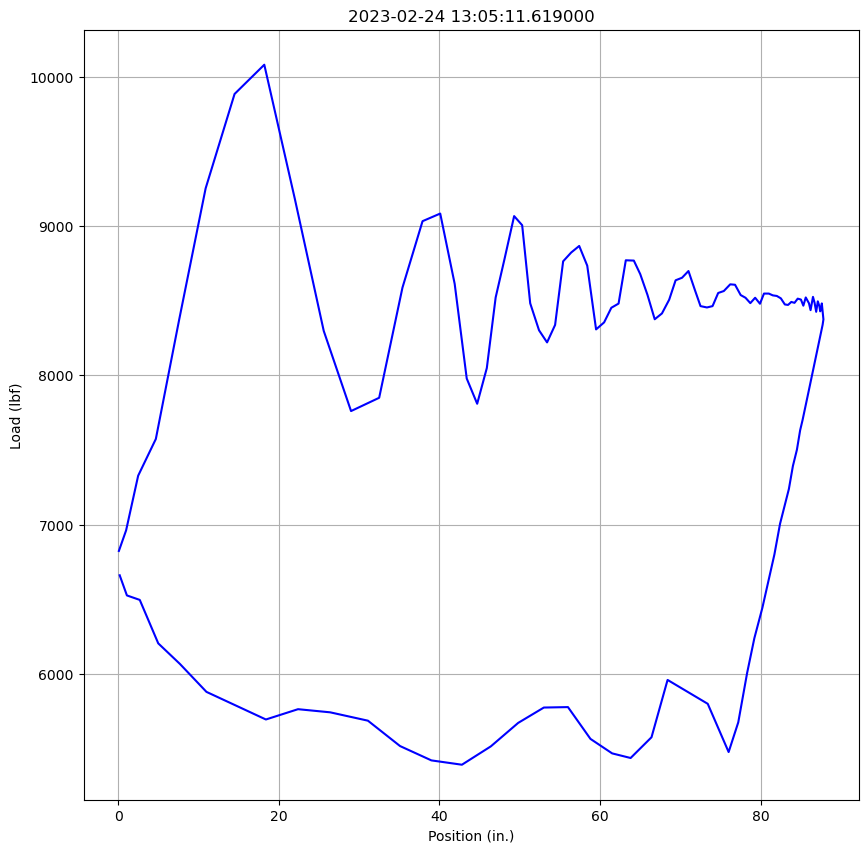

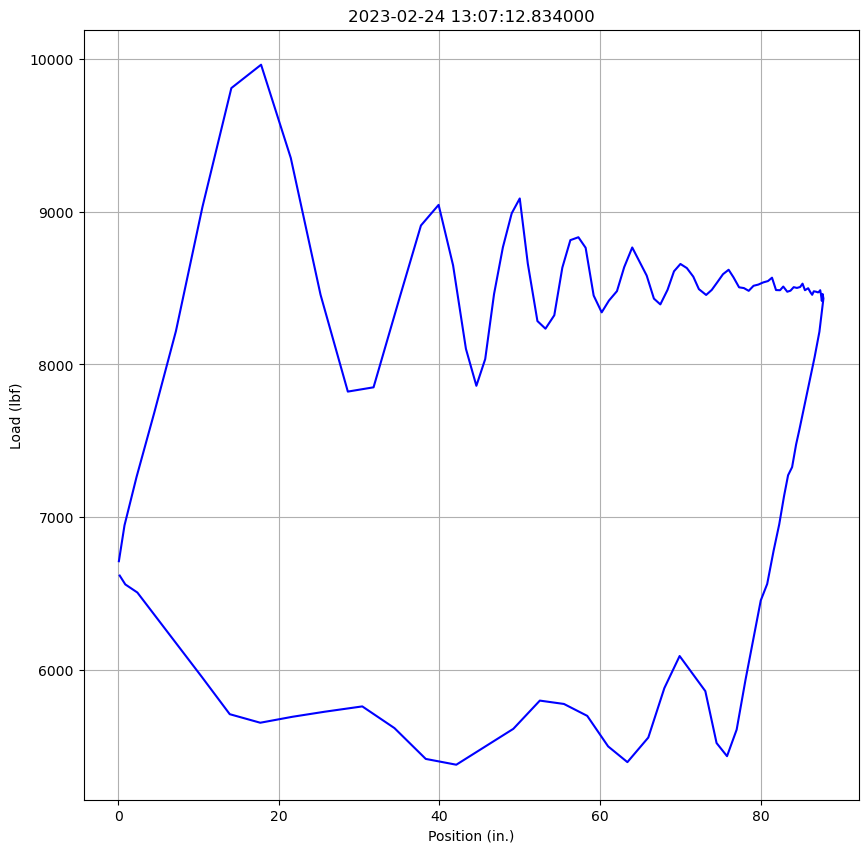

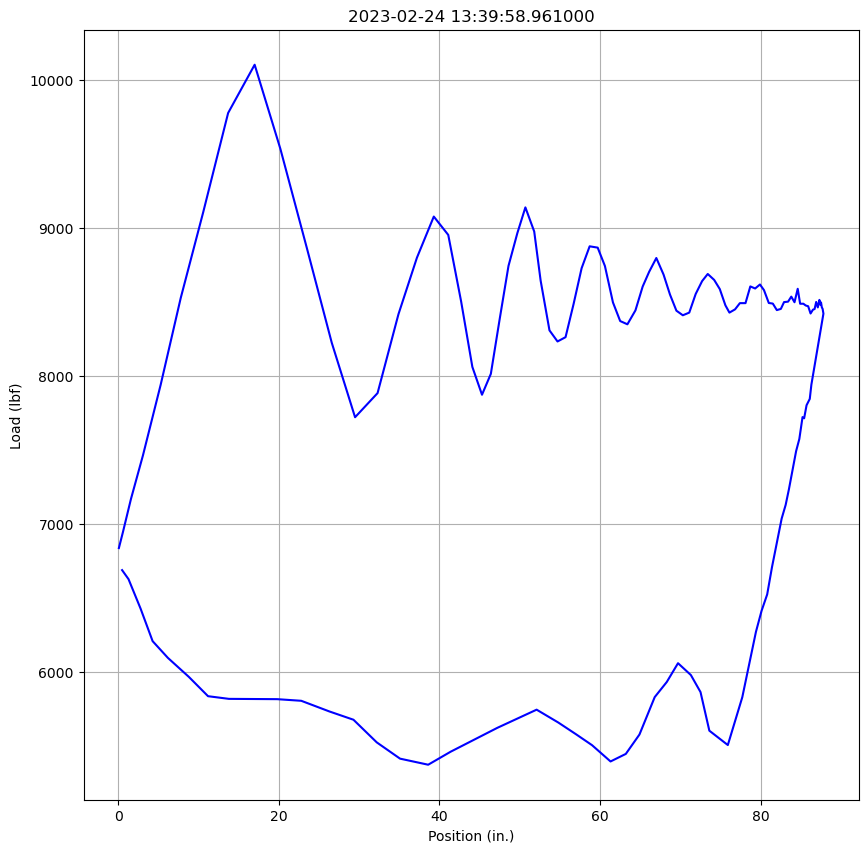

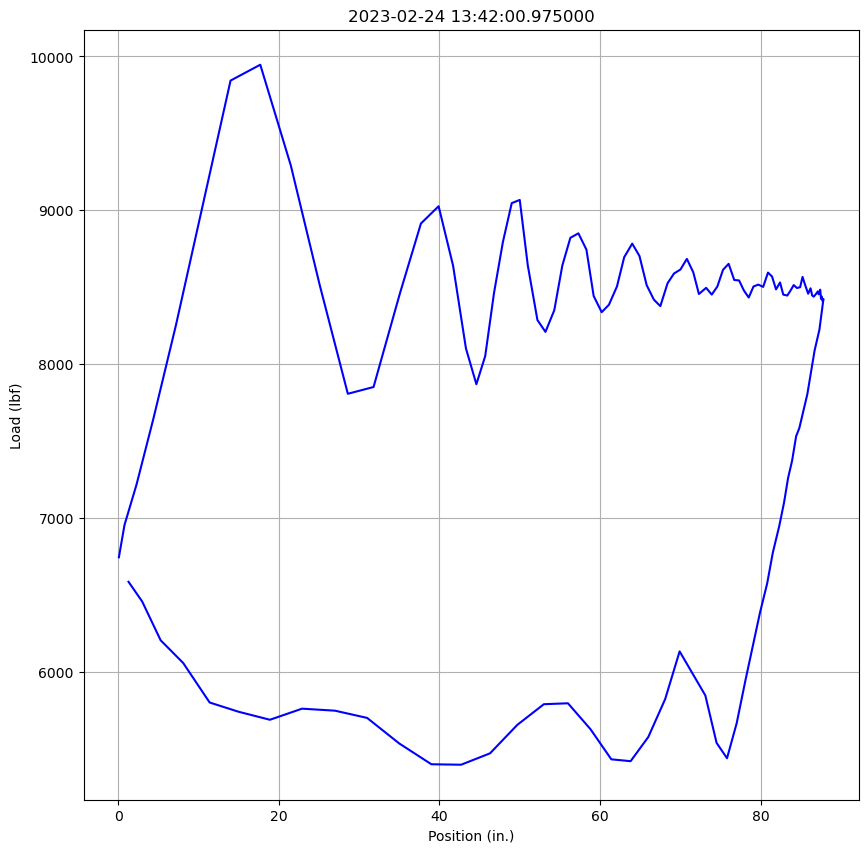

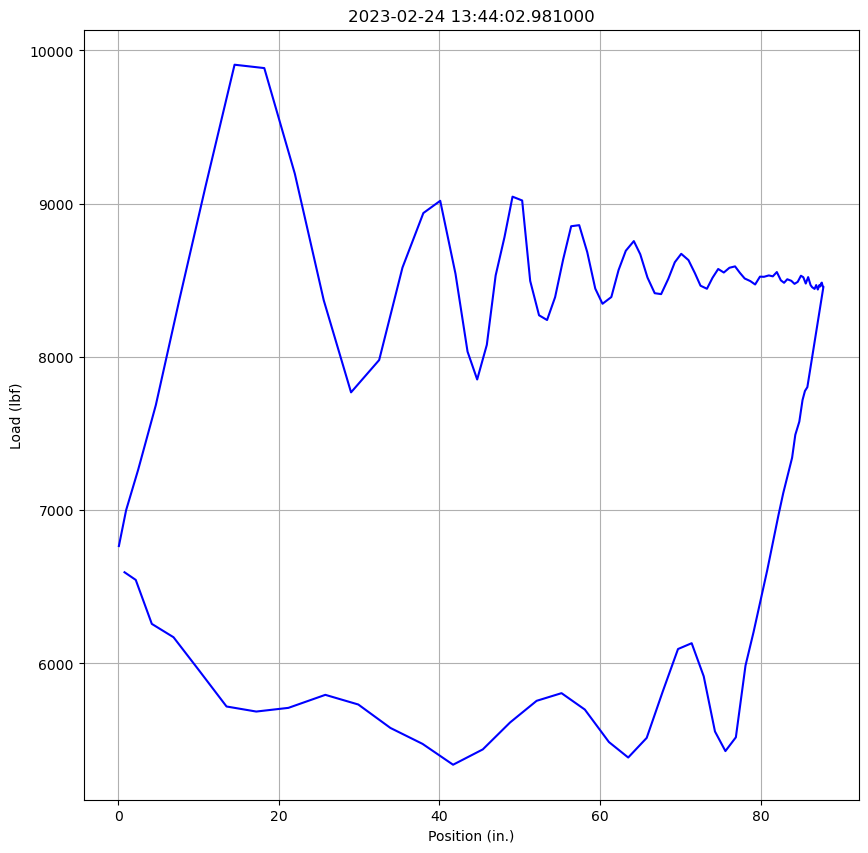

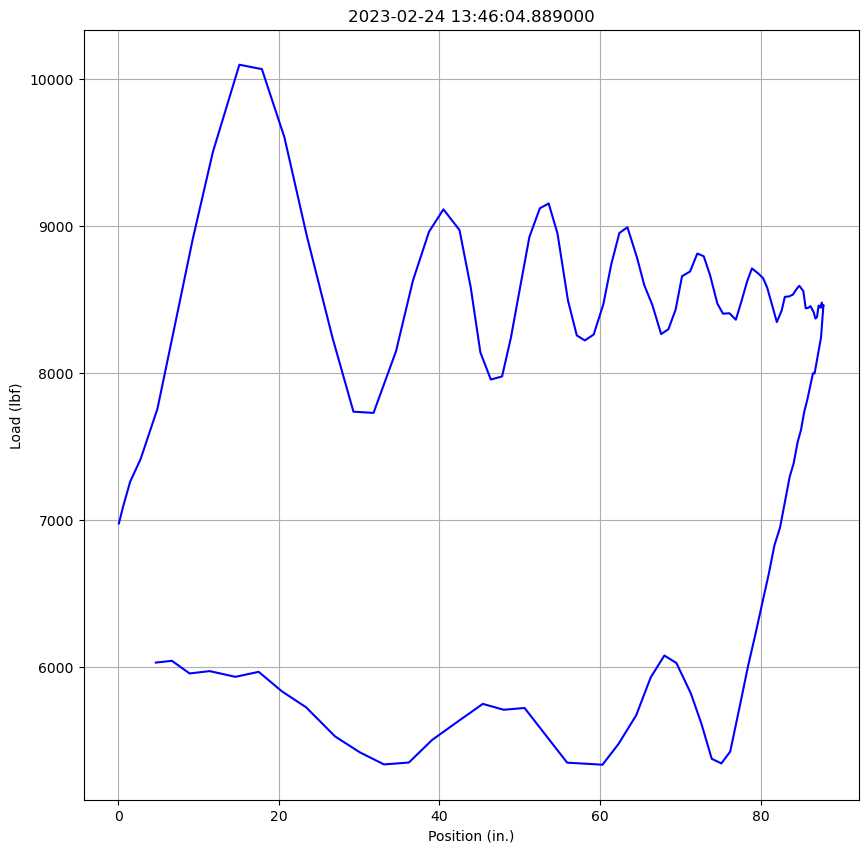

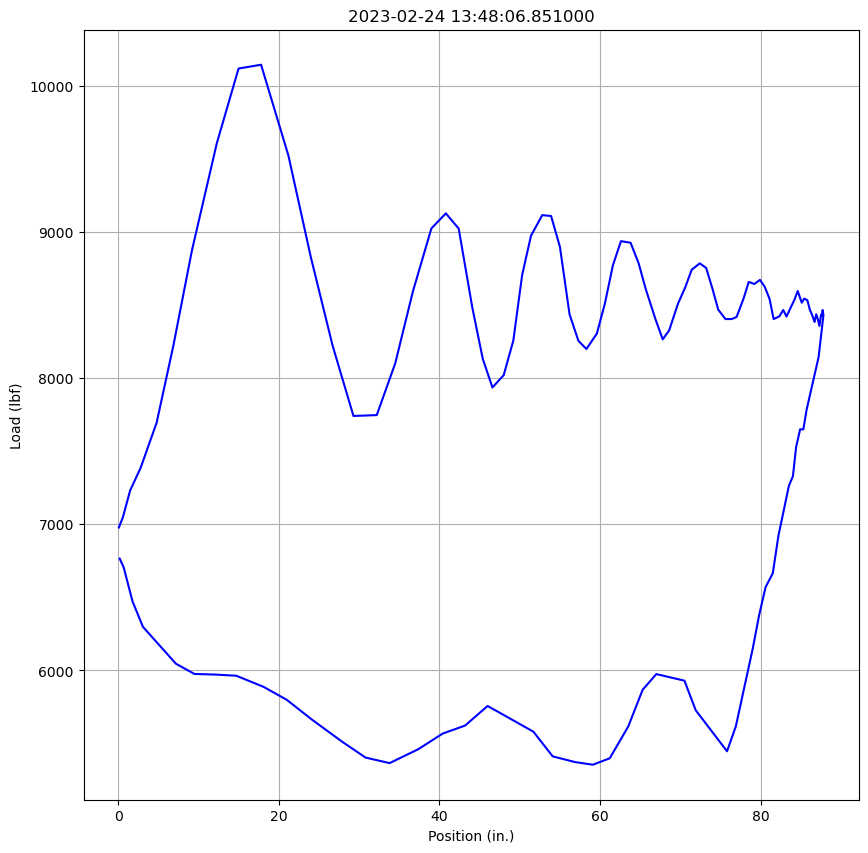

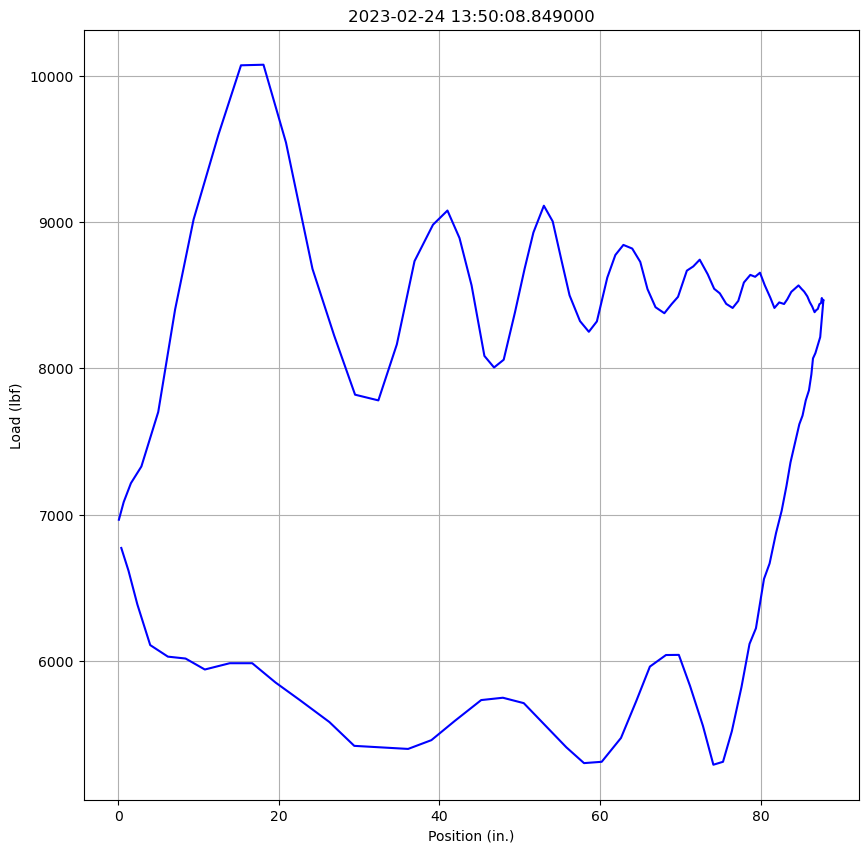

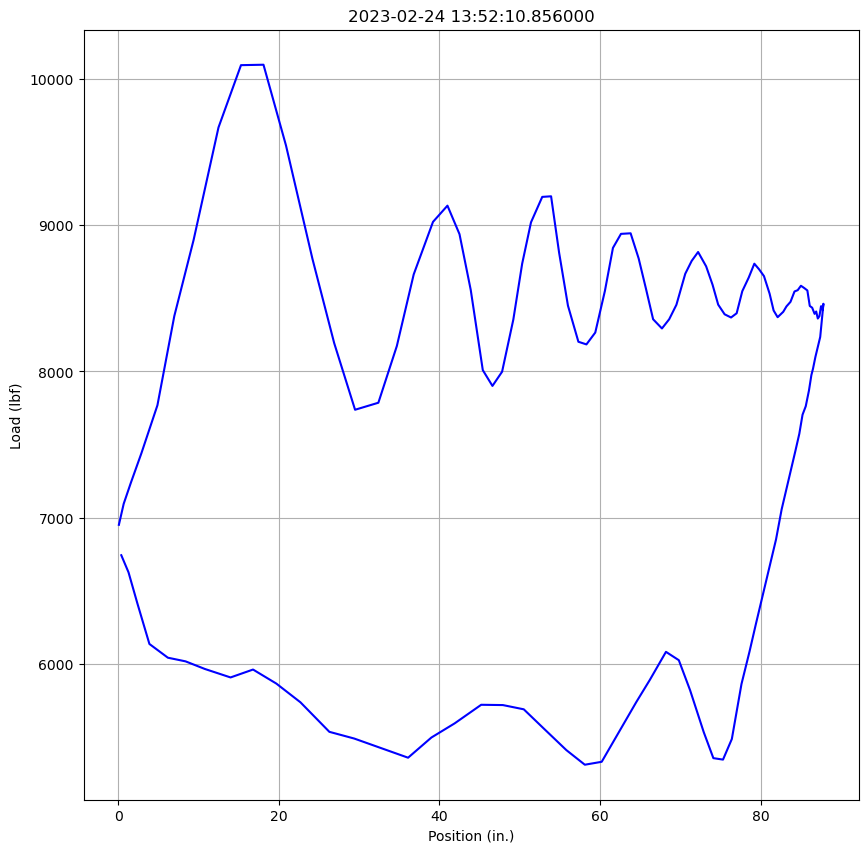

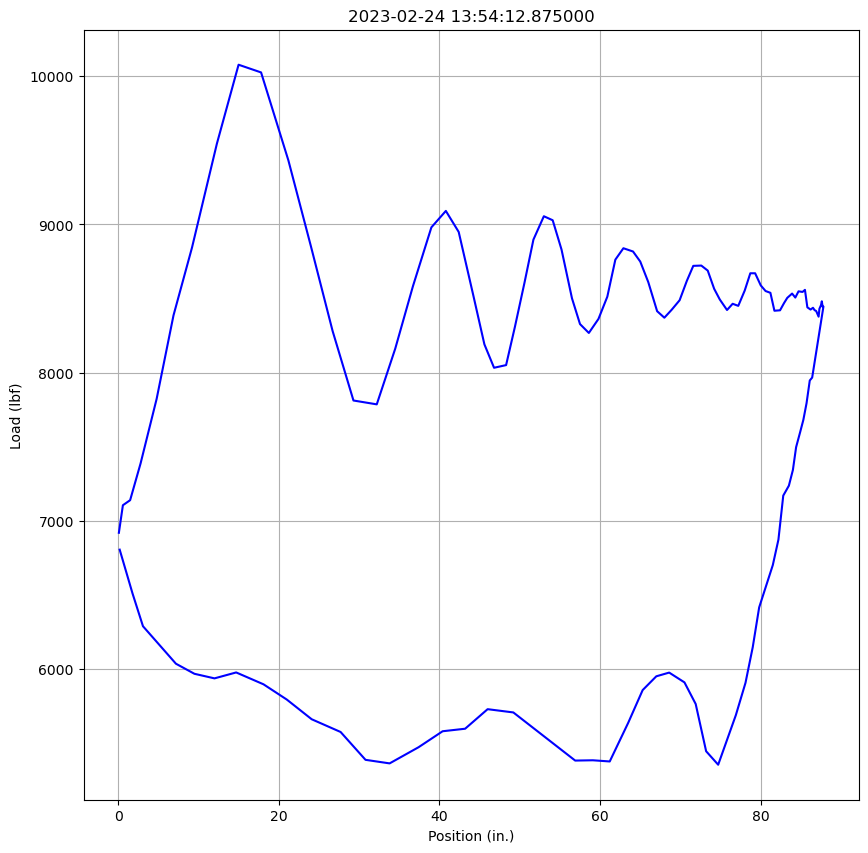

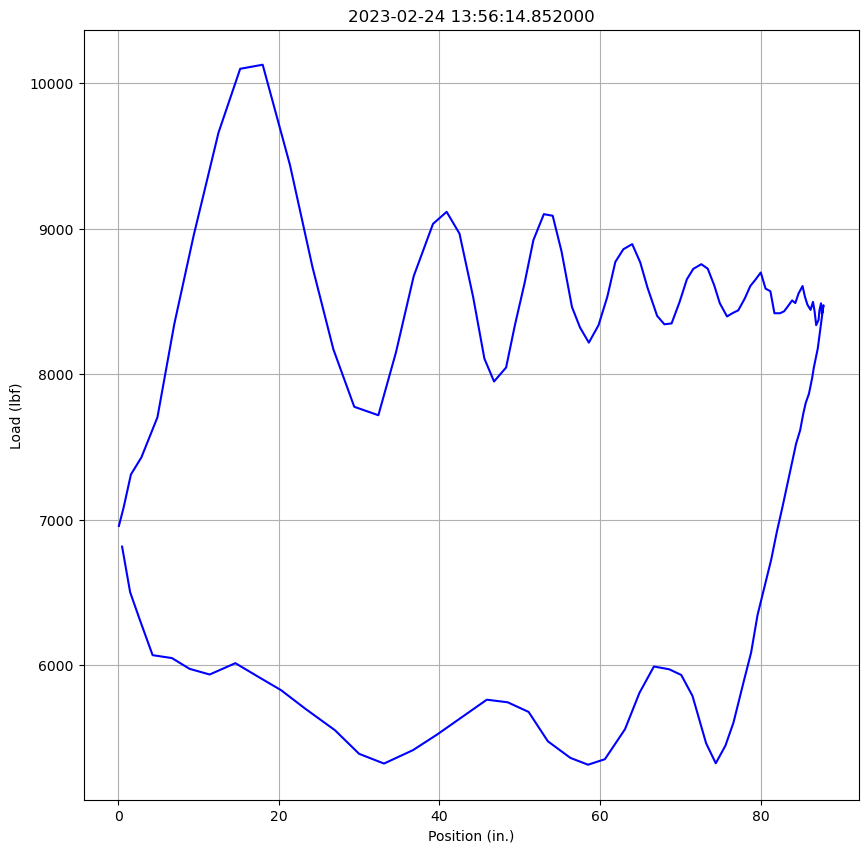

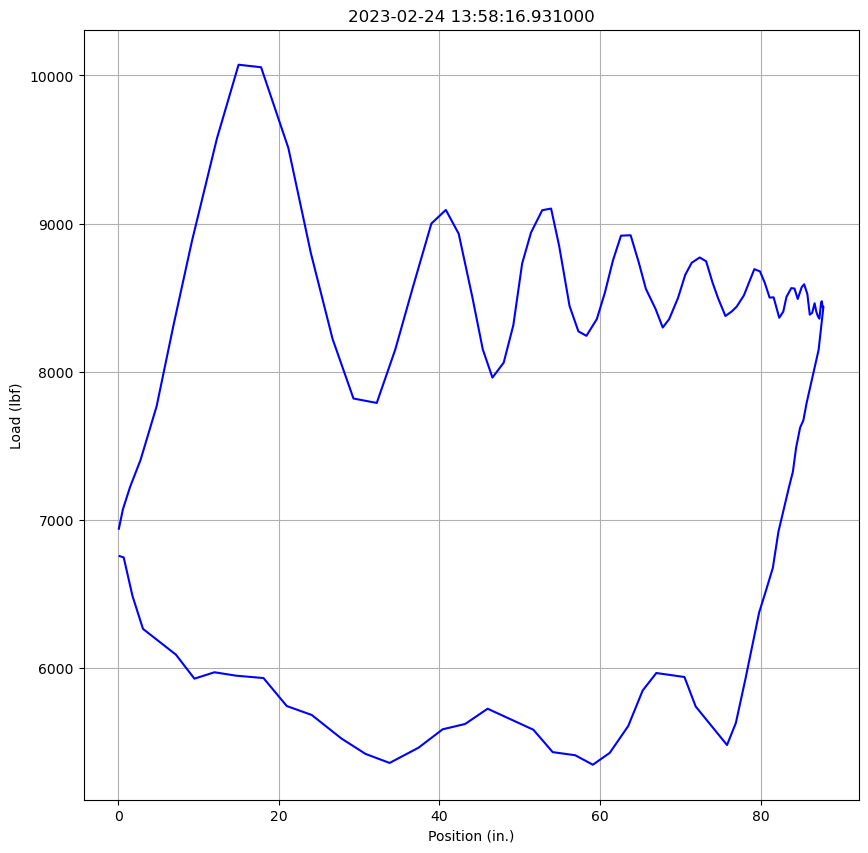

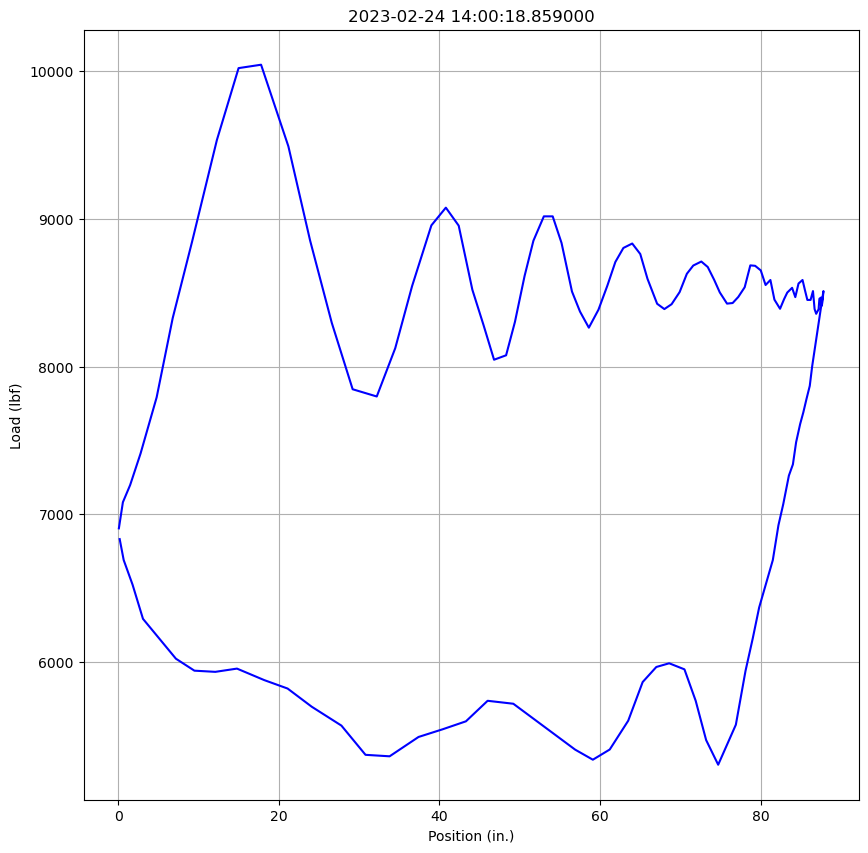

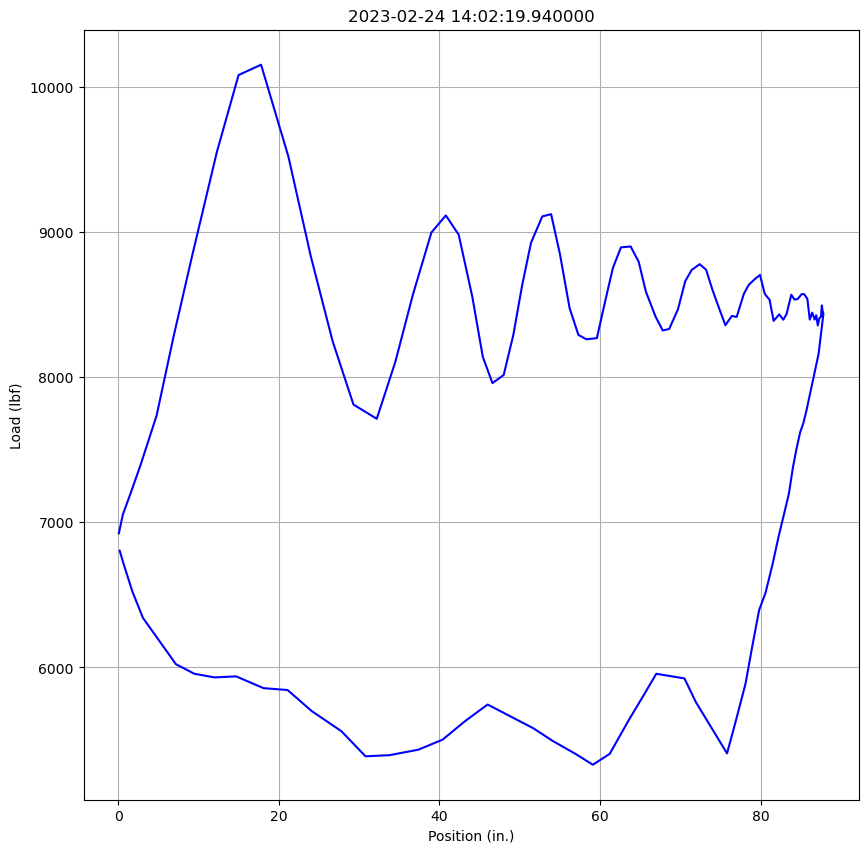

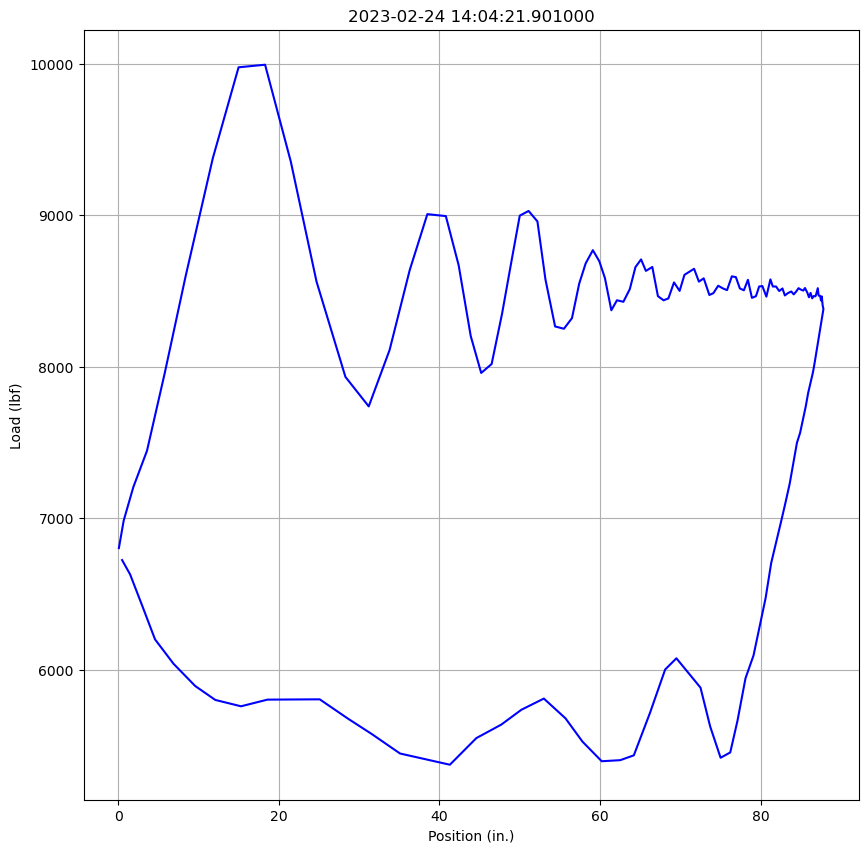

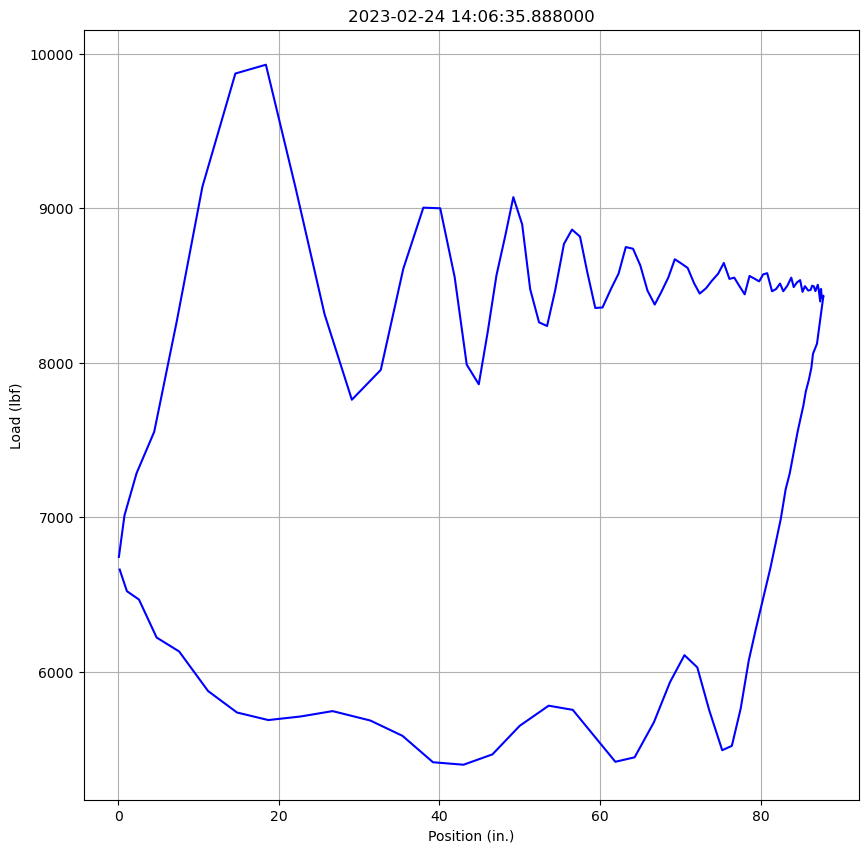

In [60]:
# plot some dyne cards

for DC in ls_dfDC:

    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(DC["Position"], DC["Load"], color="blue")
    ax.set_title(DC.loc[0,"AcqTime"])
    ax.set_xlabel("Position (in.)")
    ax.set_ylabel("Load (lbf)")
    ax.grid()
    plt.show()

## Identify and Label Pump Strokes

### Smooth Out the Inclination Signal

In [20]:
df_RL["Inclination"] = df_RL["INDInclinometer"].rolling(29, center=True).mean()

(8.0, 16.0)

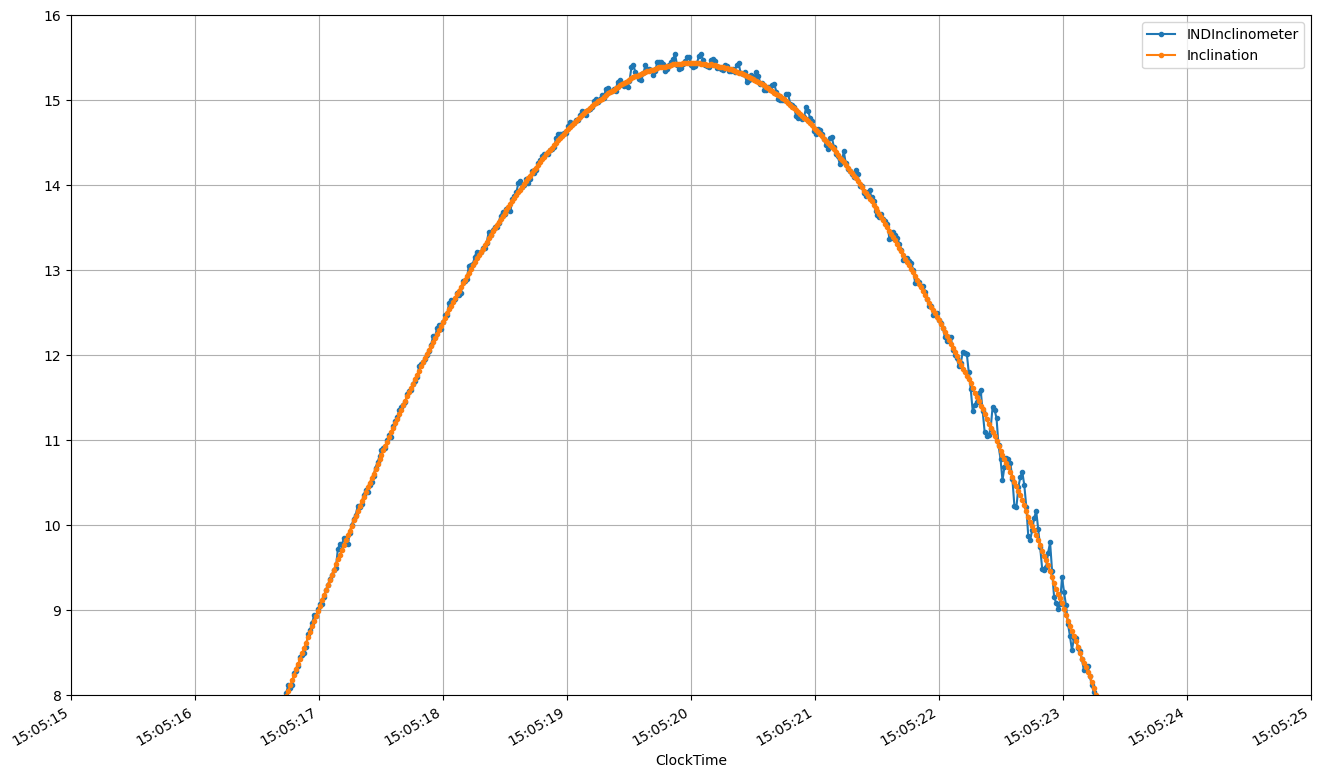

In [21]:
# plot the smoothed out inclination vs the original signal
fig, ax = plt.subplots(figsize=(16,10))
df_RL.plot(ax=ax,x = "ClockTime", y = ["INDInclinometer","Inclination"], marker=".")

ax.set_xlim(pd.to_datetime('2022-08-16 15:05:15'), pd.to_datetime('2022-08-16 15:05:25'))
ax.grid()
ax.set_ylim(8,16)

### Define stroke position (S) and change in stroke position (delta S)

In [22]:
# Find the min and max inclination values
min_inc = df_RL['Inclination'].min()
max_inc = df_RL['Inclination'].max()

df_RL["Position"] = (A * np.radians(max_inc - df_RL["Inclination"])) + S_MIN

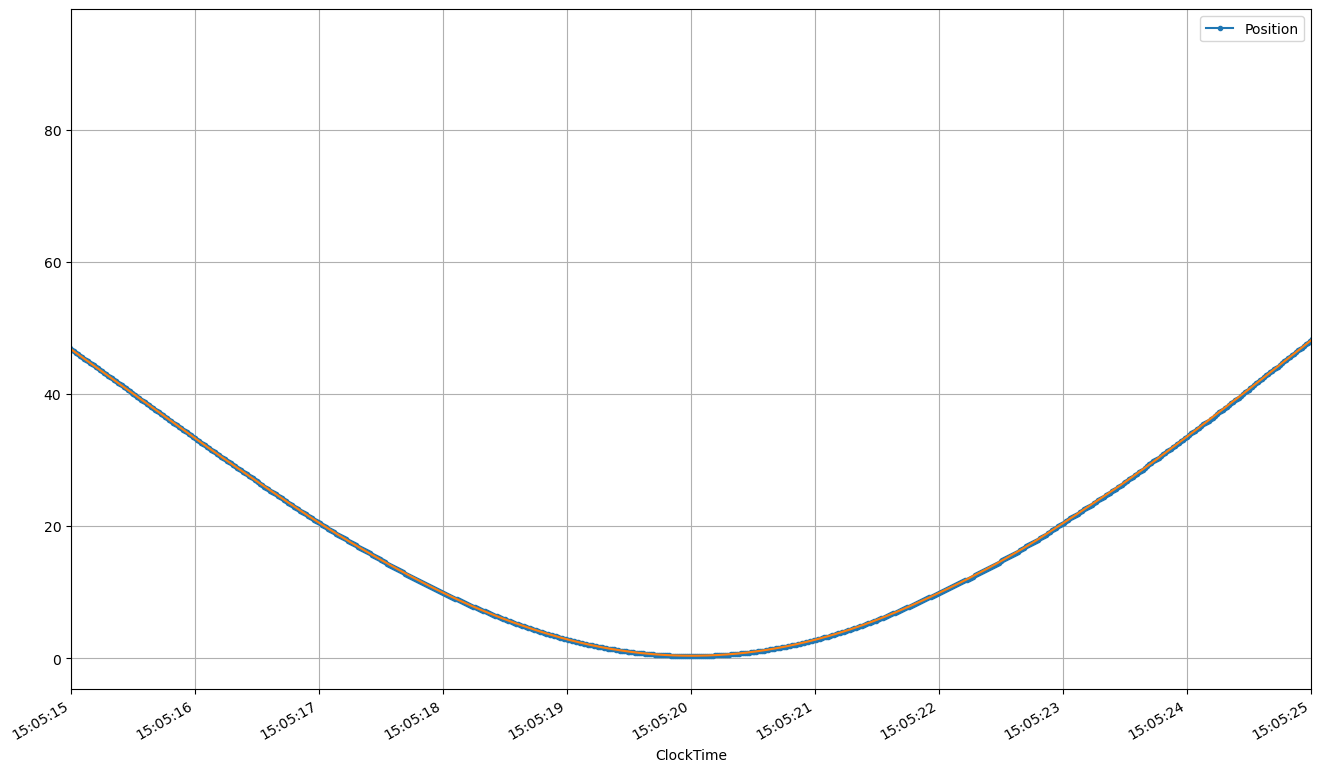

In [23]:
# smooth out the position calculation with a rolling average
pos_smooth = df_RL["Position"].rolling(25, center=True).mean()

# plot the smoothed out position vs the original signal
fig, ax = plt.subplots(figsize=(16,10))
df_RL.plot(ax=ax,x = "ClockTime", y = "Position", marker=".")
ax.plot(df_RL["ClockTime"], pos_smooth)

ax.set_xlim(pd.to_datetime('2022-08-16 15:05:15'), pd.to_datetime('2022-08-16 15:05:25'))
ax.grid()
#ax.set_ylim(0,20)

In [24]:
# set position column to be the smoothed out signal
df_RL["Position"] = pos_smooth

# Calculate the change in Polished Rod Position (delta S)
df_RL["delta S"] = (df_RL["Position"] - df_RL["Position"].shift(1)).fillna(0)

In [25]:
# Stroke detection algorithm
# In order to be considered a new stroke, the following conditions must be met
# 1. delta S must go from negative to positive
# 2. The magnitude of that change must be greater than or equal to a set threshold
# 3. Could also do a seconds delta S calculation between the current position and the
#       position a few places ahead in the dataframe just to make sure it had the
#       expected magnitude (should be quite a bit less)

# define the delta S threshold for determining a new stroke
ds_T = 0.0001

# Set the look ahead/behind to 120 rows (2 sec) and the delta position threshold
# to 2.5 inches
la = 100
dp_T = 2.5

# smooth out the position column in a temporary series
#pos_smooth = df_RL["Position"].rolling(25, center=True).mean()
pos_smooth = df_RL["Position"]

# create a temporary delta S series
dS_Temp = (pos_smooth - pos_smooth.shift(1)).fillna(0)

# there are a lot of zero values in the delta S series,
# so filter these out so we just get points where position changes
dS_Filt = dS_Temp[dS_Temp != 0]

# create a series of boolean values for when delta S is positive
b_S_pos = (dS_Filt > 0)[:-1]

# create a series of boolean values for when delta S is negative
b_S_neg = (dS_Filt < 0)[:-1]

# create a boolean series that returns true when there is a change from delta S
# being positive to being negative. This is the start (top) of the stroke.
pos_to_neg = b_S_pos.shift(1) & (b_S_pos != b_S_pos.shift(1))

# create a boolean series that returns true when there is a change from delta S
# being negative to being positive. This is the middle (bottom) of the stroke.
neg_to_pos = b_S_neg.shift(1) & (b_S_neg != b_S_neg.shift(1))

# put the row indices where delta S goes from positive to negative in a list
pos_to_neg_idx = list(pos_to_neg[pos_to_neg].index)

# put the row indices where delta S goes from negative to positive in a list
neg_to_pos_idx = list(neg_to_pos[neg_to_pos].index)

# 8/17/2022 - try a new approach...just look ahead 100 values of dS Temp and make
# sure they are all negative...this works great!

# create lists to store index values
pos_to_neg_2 = []
neg_to_pos_2 = []

# create new lists to hold the index values where the value
# not only changes from positive to negative, but also all the 
# values for a certain value of rows ahead are also still the same sign
# this avoids false positive stroke detection
for x in neg_to_pos_idx:
    neg_to_pos_2.append(x) if (dS_Temp.loc[x:x+la] > 0).all() else False

for x in pos_to_neg_idx:
    pos_to_neg_2.append(x) if (dS_Temp.loc[x:x+la] < 0).all() else False

# now, create a series to denote when a new stroke occurs
# make sure the row numbers are the same as the original dataframe
newstroke = pd.Series(0,df_RL.index)
bottomStroke = pd.Series(0,df_RL.index)

# set the row indexes that are in the index list to 1
newstroke[pos_to_neg_2] = 1

# also identify the indexes for the bottom of the stroke
bottomStroke[neg_to_pos_2] = -1

# to get the stroke count, run a cumulative sum on the new stroke series
stroke_count = newstroke.cumsum()

# insert this new stroke count series in to the data frame
df_RL["StrokeNum"] = stroke_count

# For every row that has a zero or null value for current, do not include that as part of a stroke.
# set the value in the StrokeNum column for that row to None
# df_RL.loc[(df_RL["CurrentPhaseL1"] == 0) | \
#     (df_RL["CurrentPhaseL1"].isnull()), "StrokeNum"] = None

## Calculate Pump Rates and Group Strokes by Rate

In [26]:
# create a dataframe that groups data by stroke number
df_Strokes = df_RL.groupby("StrokeNum")

Now, we need to loop through all the strokes, and if there are any that have a block of NaNs bigger than 300 values in the StrokeNum column, all values
above that block need to be set to None. This can happen when the pump is shutting down and the last partial stroke gets counted as part of the next full stroke when the pump starts back up.

In [27]:
# iterate through each stroke

for name, stroke in df_Strokes:
    i3 = None
    i4 = None
    # set variables for the indexes of the first and last row in the stroke
    i1 = stroke.index[0]
    i2 = stroke.index[-1]
    
    # create a temporary data frame for just this stroke
    df_temp = df_RL.iloc[i1:i2]

    # check to see if any of the values of StrokeNum are blank
    # if there are, then grab the index values of the first and last rows
    # with null values
    if df_temp["StrokeNum"].isnull().values.any():
        i3 = df_temp[df_temp["StrokeNum"].isnull()].index[0]
        i4 = df_temp[df_temp["StrokeNum"].isnull()].index[-1]

    # if both i3 and i4 have indexes assigned, and the seperation of those
    # indexes (rows) is more than 300, then set all those values of StrokeNum to None
    # this is what wipes out the partial stroke at the end.
    if (i3 and i4) and i4 - i3 > 300:
        df_RL.loc[i1:i3,"StrokeNum"] = None

<AxesSubplot:xlabel='ClockTime'>

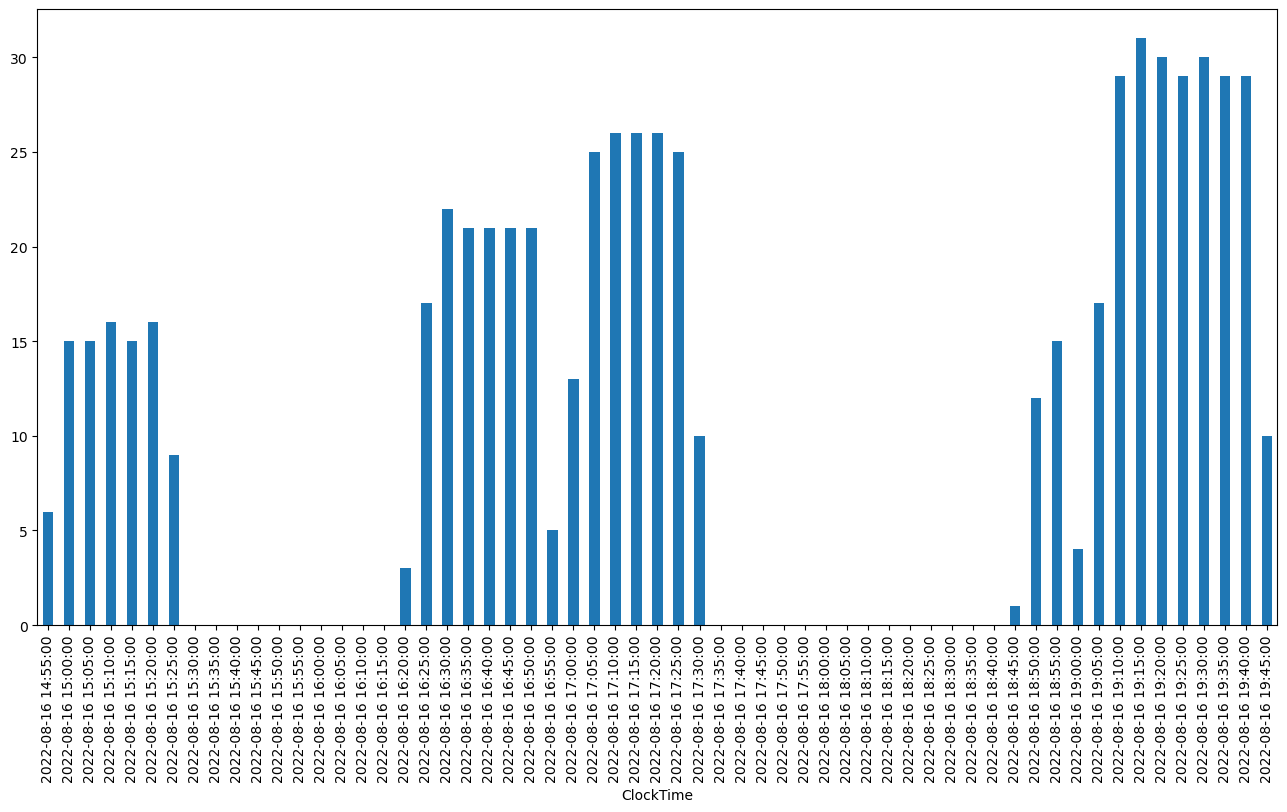

In [28]:
# bin the number of strokes in time based bins
unq_Strokes = df_RL.groupby(pd.Grouper(key="ClockTime", freq="5Min"))["StrokeNum"].nunique()
unq_Strokes.plot(kind='bar', figsize=(16,8))

In [29]:
# groupby strokes and determine the time required for each stroke.
s_times_min = df_Strokes.min()["ClockTime"]
s_times_max = df_Strokes.max()["ClockTime"]
# calculate the duration of each stroke (in seconds)
s_dur = (s_times_max - s_times_min).dt.total_seconds()

start_stroke = 0
end_stroke = df_RL["StrokeNum"].max()

# uncomment the lines below to zoom in on specific strokes
# start_stroke = 1381
# end_stroke = 1384

start_stroke_time = df_RL[df_RL["StrokeNum"] == start_stroke].iloc[0]["ClockTime"]
end_stroke_time = df_RL[df_RL["StrokeNum"] == end_stroke].iloc[0]["ClockTime"]


In [30]:
# # export csv file for diagnostics. Uncomment when needed.
# keep_cols = ["ClockTime","Position","LufkinIncl","Inclination", \
#     "CurrentPhaseL1","delta T","Position","delta S","StrokeNum"]
# df_RL.loc[(df_RL["ClockTime"] >= start_stroke_time) & \
#     (df_RL["ClockTime"] <= end_stroke_time),keep_cols].to_csv("test.csv", index_label="index")

(0.0, 30.0)

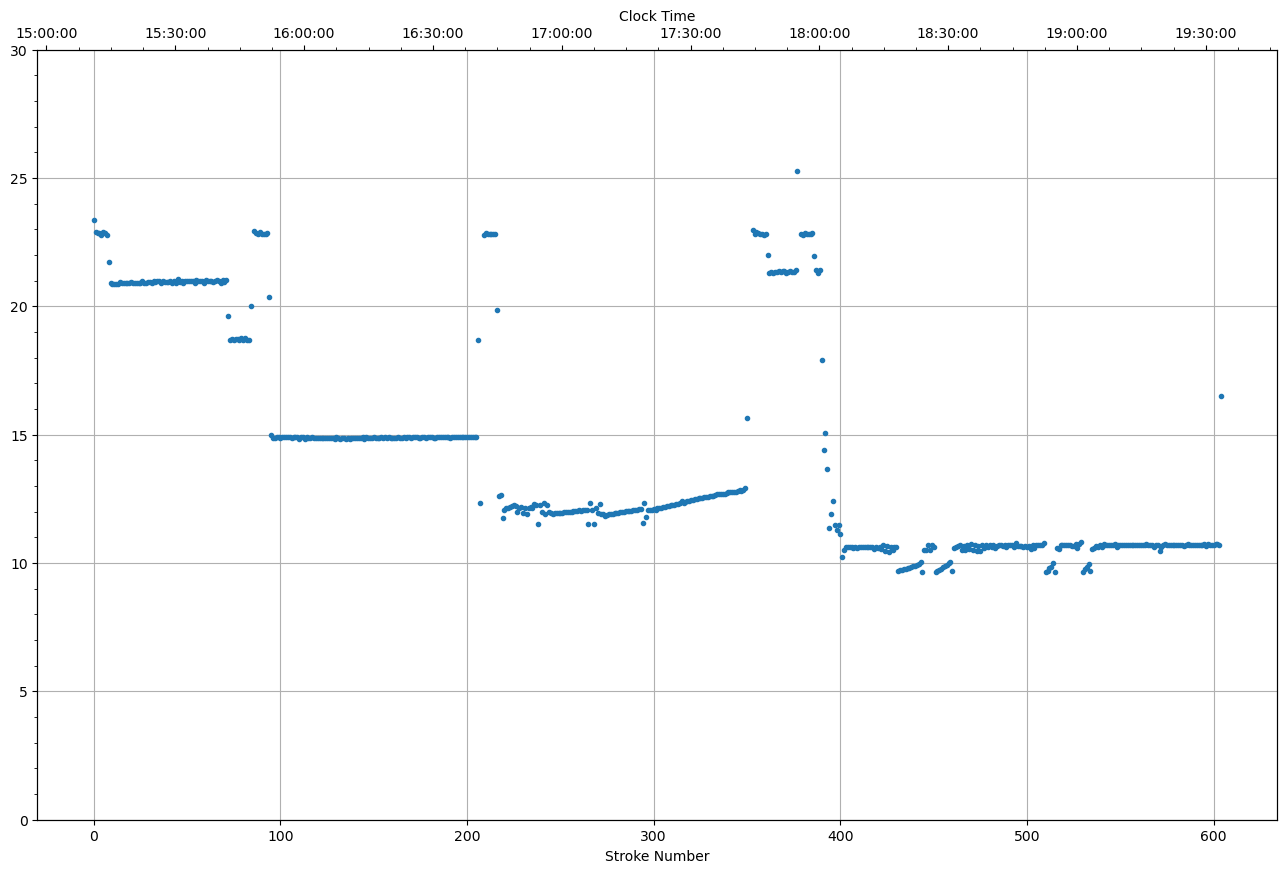

In [31]:
# plot stroke durations for each stroke
fig,ax = plt.subplots(figsize=(16,10))

# create a second x-axis to display the clock time
ax2 = ax.twiny()
ax2.set_xlabel("Clock Time")
ax2.set_xlim(start_stroke_time, end_stroke_time)
#ax2.xaxis.set_major_locator(md.MinuteLocator(interval=1))
ax2.xaxis.set_major_formatter(md.DateFormatter("%H:%M:%S"))

s_dur[start_stroke:end_stroke].plot(ax=ax, marker=".", ls="None")

ax.set_xlabel("Stroke Number")
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.minorticks_on()
ax.grid()
ax.set_ylim(0,30)

In [32]:
df_RL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547195 entries, 0 to 547194
Data columns (total 53 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   AcqTime                 547195 non-null  float64       
 1   ClockTime               547195 non-null  datetime64[ns]
 2   Date                    547195 non-null  datetime64[ns]
 3   PM Sheave Dia           547195 non-null  int64         
 4   Angle                   547195 non-null  float64       
 5   PM RPM                  547195 non-null  float64       
 6   CVTSpeedIn              547195 non-null  float64       
 7   CVTSpeedOut             547195 non-null  float64       
 8   CVTSpeedOutSp2PID       8686 non-null    float64       
 9   CVTCoolPres             8686 non-null    float64       
 10  CVTTempInlet            8686 non-null    float64       
 11  CVTCtrlPress            8686 non-null    float64       
 12  CVTTempOutletRes        8686 n

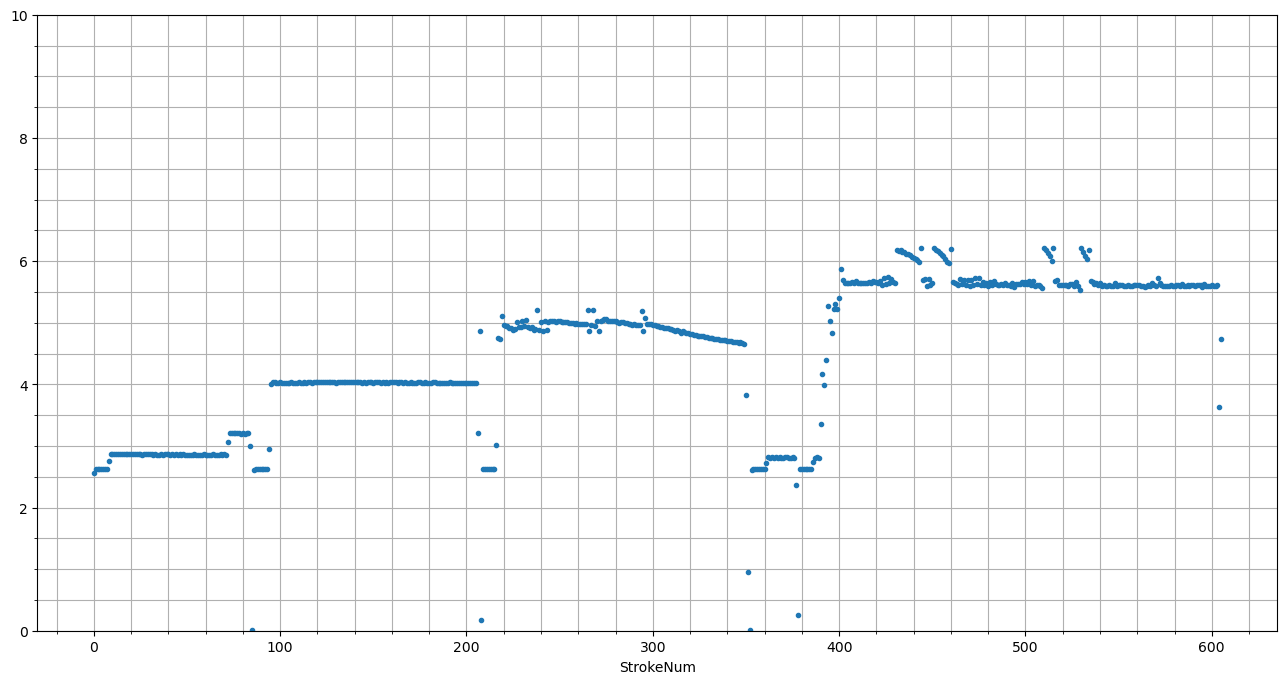

In [33]:
# determine the stroke rate in strokes per minute
SPM_calc = 60/s_dur

# plot the calculated vs. the measured (Lufkin) stroke rates.
ax = SPM_calc.plot(figsize=(16,8),marker=".", ls="none")
ax.set_ylim(0,10)
ax.minorticks_on()
ax.grid(which="both")

In [34]:
# map the SPM_Calc series onto the Stroke number in the dataframe
df_RL["SPM Calc"] = df_RL["StrokeNum"].map(SPM_calc.to_dict())

# define bins for grouping the pumping rates
# make sure the even number is in the middle of the bin range.
bins = np.arange(0.25,10,0.5)
df_RL["SPM Bin"] = pd.cut(df_RL["SPM Calc"],bins=bins)

### Normalize Stroke Positions

Now that we have stroke numbers assigned, we need to normalized each stroke to have a min and max position that match the model (0 - 88.0001 inches.). We can iterated through each stroke and re-calculate the position (S).

Figure out the values need to normalize the inclination and position of each stroke to match the model.

In [35]:
# These values are for the whole test
print(f"The minimum model (theoretical) inclination is: {min_inc_theo:.4f} degrees")
print(f"The maximum model (theoretical) inclination is: {max_inc_theo:.4f} degrees")
print(f"The minimum actual (measured) inclination is: {min_inc:.4f} degrees")
print(f"The maximum actual (measured) inclination is: {max_inc:.4f} degrees")

The minimum model (theoretical) inclination is: -16.2447 degrees
The maximum model (theoretical) inclination is: 11.7668 degrees
The minimum actual (measured) inclination is: -14.2303 degrees
The maximum actual (measured) inclination is: 15.5583 degrees


In [36]:
# calculate the total sweep angle of the walking beam (theoretical and actual)
sweep_theo = max_inc_theo - min_inc_theo
sweep_meas = max_inc - min_inc
print(f"Theoretical Sweep = {sweep_theo:.3f}. Measured Sweep = {sweep_meas:.3f} Difference = {(sweep_meas - sweep_theo):.3f} degrees")

Theoretical Sweep = 28.012. Measured Sweep = 29.789 Difference = 1.777 degrees


The measured sweep is more than theoretical, so we need to map the measured angle onto the theoretical range so that the calculated rod positions and crank angles match the model.

In [37]:
minPos = df_RL["Position"].min()
maxPos = df_RL["Position"].max()

print(f"Minimum Rod Position = {minPos:.4f} inches")
print(f"Maximum Rod Position = {maxPos:.4f} inches")

Minimum Rod Position = 0.1247 inches
Maximum Rod Position = 93.4337 inches


The max postion above is greater than the max position of the model and will create an error when calculating the crank angle theta.  
Use the code below to "normalize" the stroke to fit within the boundaries of the model (0-88.00081 in).

In [38]:
# create a new column in the data frame to hold the "modified Position" values of the Polished Rod
df_RL["modPos"] = None

# iterate through each stroke to determine min and max position

# create an empty list to hold the min/max tuples for each stroke
minmax_Inc_init = []
minmax_Inc_final = []

# create an empty list to hold all the modified 

for name, stroke in df_Strokes:   
    minmax_Inc_init.append((stroke["Inclination"].max(), stroke["Inclination"].max()))
    # Determine measured angle sweep for each stroke
    sw_meas = stroke["Inclination"].max() - stroke["Inclination"].min()
    Incl_adj = max_inc_theo - (((stroke["Inclination"].max() - \
        stroke["Inclination"])/sw_meas) * sweep_theo)
    #print(f"Max Inc. Adj. = {Incl_adj.max():.4f}. Min = {Incl_adj.min():.4f}.")
    modPos = (A * np.radians(max_inc_theo - Incl_adj)) + S_MIN
    df_RL.loc[modPos.index[0]:modPos.index[-1],"modPos"] = modPos

df_RL["modPos"] = df_RL["modPos"].astype("float")

## Calculate Torques, Powers, Efficiencies

### Prime Mover Sheave Torque 
Calculate the prime mover sheave torque based on the measured loads at the polished rod, and the characteristics of the Rod Pump Unit

In [39]:
# Direction multiplier series for every row in the dataframe
dir_Mult = pd.Series(0,df_RL.index)
dir_Mult[pos_to_neg_2] = -1
dir_Mult[neg_to_pos_2] = 1
dir_Mult = dir_Mult.replace(to_replace=0, method="ffill")

# create series for all the "helper" variables that are described in Chapter 8
# of The Beam Lift Handbook by Paul Bommer

# these equations are also shown in the tab "Crank Angle v Rod Position" 
# in the Excel spreadsheet "RPU Kinematic Model with Test Data - v3.xlsx"

# use modified position to calculate variable psi
psi = (PSI_b - (df_RL["modPos"] / A)).fillna(0)
tx = I + C * np.cos(1.5*np.pi-PHI-psi)
ty = C_y + C * np.sin(1.5*np.pi-PHI-psi)
Q = (tx**2 + ty**2 - P**2 + R**2)/2
a = 1 + (tx/ty)**2
b = -2 * (tx/ty) * (Q/ty)
c = (Q/ty)**2 - R**2
hx = (-b + dir_Mult * np.sqrt(b**2-4*a*c)) / (2*a)
e = -2 * ty
f = -(P**2 - (hx-tx)**2 -ty**2)
hy = (-e - np.sqrt(e**2 - 4*f))/2

/Users/joel/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [40]:
# find crank angle (theta) as a function of rod position
theta = ((np.pi/2) - np.arctan2(hy,hx)) % (2*np.pi)

# add the crank angle theta to the dataframe in degrees
df_RL["theta"] = theta * (360/(2*np.pi))

In [41]:
# calculate the torque factor based in crank angle theta
beta = np.arccos((C**2 + P**2 - K**2 - R**2 + 2*K*R*np.cos(theta-PHI))/(2*C*P))
alpha = beta + psi - (theta-PHI)
tf = ( (A*R) / (C*np.sin(beta)) ) * np.sin(alpha) # torque factor in inches

In [42]:
# put all these together into a dataframe for examination if needed
# df_TempVars = pd.concat([df_RL["ClockTime"], df_RL["modPos"], psi, tx, ty,
#     Q, a, b, c, hx, e, f, hy, theta, beta, alpha], axis=1)

In [43]:
# redefine the strokes group dataframe to include the new columns for theta, etc..
df_Strokes = df_RL.groupby("StrokeNum")

In [44]:
# drop any outliers outside of 170 and 190 degrees

min_theta_start = df_Strokes.first()["theta"][df_Strokes.first()["theta"].between(170,190)].min()
mean_theta_start = df_Strokes.first()["theta"][df_Strokes.first()["theta"].between(170,190)].mean()
max_theta_start = df_Strokes.first()["theta"][df_Strokes.first()["theta"].between(170,190)].max()

print(f"Min theta = {min_theta_start:.3f}. Mean theta = {mean_theta_start:.3f}. Max theta = {max_theta_start:.3f}")

Min theta = 182.294. Mean theta = 184.351. Max theta = 188.865


In [45]:
# let's do a theta offset for ease of plotting against crank angle
# make sure resulting values are between 0 and 360 degrees

theta_offset = 360 - mean_theta_start
df_RL["theta_shift"] = (df_RL["theta"] + theta_offset) % 360

In [46]:
# based on the polished rod load, calculate the torque on the output shaft
# of the electric motor

# calculate gearbox output torque (need Torque from well and CBE)
t_well = tf * (df_RL["IndLoadcell"] - B)      # in inch-lbf
t_CBE = M * np.sin(theta)                   # in inch-lbf
t_gb_out = t_well - t_CBE               # in inch-lbf

df_RL["GB Out Torq"] = t_gb_out

# calculate gearbox input torque
# if the output torque is negative (i.e. - driving torque)
# then the input torque would be less than if it was the
# driving torque
t_gb_in = np.where(t_gb_out>0,(t_gb_out / Z) / GB_eff, \
    (t_gb_out / Z) * GB_eff) / 12            # divide by 12 to get ft-lbf

df_RL["GB In Torq"] = t_gb_in

# calculate prime mover output torque
t_PM_out = (t_gb_in * (D_pm / D_in))


In [47]:
# add the prime mover sheave torque series to the rapid logger data frame
df_RL["PM Trq"] = t_PM_out

### System Apparent Power

In [48]:
# Calculate the electrical input power to the VFD using the line voltage and amperage measurements
# Power (W) = summed for all phases (Phase Volts to Neutral * Phase Amps)

# calculate the apparent power going into the System (in Watts)
df_RL["Sys App Power"] = (((df_RL["VoltageL1L2"] * df_RL["CurrentPhaseL1"]) \
    + (df_RL["VoltageL2L3"] * df_RL["CurrentPhaseL2"]) \
    + (df_RL["VoltageL3L1"] * df_RL["CurrentPhaseL3"])) / 1000) / np.sqrt(3)     # in kW

df_RL["Sys App Energy"] = (df_RL["Sys App Power"] * df_RL["delta T"]).fillna(0)                     # in kJ

### System Real Power

In [49]:
# calculate the real power using the average power recorded by the Sineax
avg_PF = (df_RL["PowerFactL1"] + df_RL["PowerFactL2"] + df_RL["PowerFactL3"]) / 3
df_RL["Sys Real Power"] = df_RL["Sys App Power"] * avg_PF
df_RL["Sys Real Energy"] = df_RL["Sys Real Power"] * df_RL["delta T"]

### Prime Mover Sheave Power

In [50]:
# Power (W) = (torque (ft-lbf) * RPM * 745.7) / 5252

df_RL["Prime Mover Sheave Power"] = ((df_RL["PM Trq"] * df_RL["PM RPM"] * 745.7) / 5252) / 1000      # power in kW
df_RL["Prime Mover Sheave Energy"] = (df_RL["Prime Mover Sheave Power"] * df_RL["delta T"]).fillna(0)      # in kJ


### Motor Output Power (Derived)  
Use an efficiency curve of a new 30HP NEMA B motor to simulate the performance of the motor

In [51]:
df_RL["Motor Input Power"] = df_RL["Sys Real Power"]
df_RL["Motor Input Energy"] = (df_RL["Motor Input Power"] * df_RL["delta T"]).fillna(0)                # in kJ
df_RL["Motor Output Power"] = np.where(df_RL["Motor Input Power"] > 0, \
    np.polynomial.polynomial.polyval(df_RL["Motor Input Power"], p_out_coeffs), \
    np.polynomial.polynomial.polyval(df_RL["Motor Input Power"], p_out_coeffs_neg))
df_RL["Motor Output Energy"] = (df_RL["Motor Output Power"] * df_RL["delta T"]).fillna(0)                # in kJ

df_RL["Motor Input Power No Regen"] = np.where(df_RL["Sys Real Power"]<0,0,df_RL["Sys Real Power"])
df_RL["Motor Input Energy No Regen"] = (df_RL["Motor Input Power No Regen"] * df_RL["delta T"]).fillna(0)                # in kJ
df_RL["Motor Output Power No Regen"] = np.polynomial.polynomial.polyval(df_RL["Motor Input Power No Regen"], p_out_coeffs)
df_RL["Motor Output Energy No Regen"] = (df_RL["Motor Output Power No Regen"] * df_RL["delta T"]).fillna(0)                # in kJ

### Polished Rod Power

In [52]:
df_RL["PR Load"] = df_RL["IndLoadcell"]

In [53]:
# calculate Polished Rod Energy based on the load cell and change in position (delta S)
# this is calculated in kilo Joules
# 1 inch-pound = 0.113 Joules
df_RL["PR Energy"] = (df_RL["PR Load"] * df_RL["delta S"] * 0.113 / 1000).replace(0,np.nan) # in kJ
df_RL["PR Power"] = df_RL["PR Energy"] / df_RL["delta T"]

In [54]:
df_RL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547195 entries, 0 to 547194
Data columns (total 78 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   AcqTime                       547195 non-null  float64       
 1   ClockTime                     547195 non-null  datetime64[ns]
 2   Date                          547195 non-null  datetime64[ns]
 3   PM Sheave Dia                 547195 non-null  int64         
 4   Angle                         547195 non-null  float64       
 5   PM RPM                        547195 non-null  float64       
 6   CVTSpeedIn                    547195 non-null  float64       
 7   CVTSpeedOut                   547195 non-null  float64       
 8   CVTSpeedOutSp2PID             8686 non-null    float64       
 9   CVTCoolPres                   8686 non-null    float64       
 10  CVTTempInlet                  8686 non-null    float64       
 11  CVTCtrlPress 

## Prepare Files for Export

### Remove Unused Columns

Create list of columns that need to be kept

In [55]:
# columns we don't need
# any column that contains mostly nan values
remove_cols = [c for c in list(df_RL.columns) if df_RL[c].count() < 20000]

keep_cols = [c for c in list(df_RL.columns) if c not in remove_cols]

In [56]:
# create a new dataframe with only the columns we want to keep
df_RL_2 = df_RL[keep_cols]

In [57]:
df_RL_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547195 entries, 0 to 547194
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   AcqTime                       547195 non-null  float64       
 1   ClockTime                     547195 non-null  datetime64[ns]
 2   Date                          547195 non-null  datetime64[ns]
 3   PM Sheave Dia                 547195 non-null  int64         
 4   Angle                         547195 non-null  float64       
 5   PM RPM                        547195 non-null  float64       
 6   CVTSpeedIn                    547195 non-null  float64       
 7   CVTSpeedOut                   547195 non-null  float64       
 8   VoltageL1L2                   547195 non-null  float64       
 9   VoltageL2L3                   547195 non-null  float64       
 10  VoltageL3L1                   547195 non-null  float64       
 11  CurrentPhaseL

### Resample to 10Hz

In [58]:
# any column that is not a float will not be resampled
excl_cols = [c for c in list(df_RL_2.columns) if df_RL_2[c].dtype != float]

SPM_cols = [c for c in excl_cols if c != "ClockTime"]

# resample the rest of the columns
resamp_cols = [c for c in list(df_RL_2.columns) if c not in excl_cols]

In [59]:
# resample the data at 10Hz
df_RL_Resamp = df_RL_2.set_index("ClockTime").resample("0.1S")

# concatenate resample columns with category columns that were not resampled
df_RL_Resamp = pd.concat([df_RL_Resamp[resamp_cols].mean(), \
    df_RL_Resamp[SPM_cols].first()], axis=1).reset_index()

# drop all the rows where Prime Mover Torque is 0 or less
df_RL_Resamp = df_RL_Resamp[df_RL_Resamp["PM RPM"] > 0].reset_index(drop=True)

# recalculate delta T column
df_RL_Resamp["delta T"] = (df_RL_Resamp["ClockTime"] - df_RL_Resamp["ClockTime"].shift(1)).dt.total_seconds()

In [60]:
df_RL_Resamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87676 entries, 0 to 87675
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ClockTime                     87676 non-null  datetime64[ns]
 1   AcqTime                       87676 non-null  float64       
 2   Angle                         87676 non-null  float64       
 3   PM RPM                        87676 non-null  float64       
 4   CVTSpeedIn                    87676 non-null  float64       
 5   CVTSpeedOut                   87676 non-null  float64       
 6   VoltageL1L2                   87676 non-null  float64       
 7   VoltageL2L3                   87676 non-null  float64       
 8   VoltageL3L1                   87676 non-null  float64       
 9   CurrentPhaseL1                87676 non-null  float64       
 10  CurrentPhaseL2                87676 non-null  float64       
 11  CurrentPhaseL3              

### Aggregate by Date, Sheave Diameter, Pump Rate, and Stroke Number

In [61]:
df_RateStroke = df_RL_2.groupby(["Date","PM Sheave Dia","SPM Bin","StrokeNum"])

In [62]:
df_AggRateStroke = df_RateStroke.agg(
    {
        "SPM Calc":["mean"],
        "Sys App Power":["min","max"],
        "Sys App Energy":["sum"],
        "Sys Real Power":["min","max"],
        "Sys Real Energy":["sum"],
        "Motor Input Power":["min","max"],
        "Motor Input Energy":["sum"],
        "Motor Input Power No Regen":["min","max"],
        "Motor Input Energy No Regen":["sum"],
        "Motor Output Power":["min","max"],
        "Motor Output Energy":["sum"],
        "Motor Output Power No Regen":["min","max"],
        "Motor Output Energy No Regen":["sum"],
        "Prime Mover Sheave Power":["min","max"],
        "Prime Mover Sheave Energy":["sum"],
        "PR Power":["min","max"],
        "PR Energy":["sum"],
        "GB Out Torq":["min","mean","max"],
        "GB In Torq":["min","mean","max"],
        "PM Trq":["min","mean","max"],
        "PM RPM":["min","mean","max"],
        "PR Load":["min","mean","max"],
        "CurrentPhaseL1":["min","mean","max"]
    }
).dropna()

df_AggRateStroke = df_AggRateStroke[df_AggRateStroke["Sys App Energy","sum"]>0]

In [63]:
df_AggRateStroke

SPM Calc Sys App Power  \
                                                     mean           min   
Date       PM Sheave Dia SPM Bin      StrokeNum                           
2022-08-16 6             (0.25, 0.75] 378        0.251290      0.000000   
                         (2.25, 2.75] 0          2.566735     13.057773   
                                      1          2.622378     13.040134   
                                      2          2.626050     13.053624   
                                      3          2.626050     13.051996   
...                                                   ...           ...   
                         (5.75, 6.25] 530        6.208609     13.096578   
                                      531        6.147541     13.095555   
                                      532        6.087662     13.085330   
                                      533        6.028939     13.085712   
                                      534        6.188119     13.024259   

                                                           Sys App Energy  \
                                                       max            sum   
Date       PM Sheave Dia SPM Bin      StrokeNum                             
2022-08-16 6             (0.25, 0.75] 378        73.767375   13085.416251   
                         (2.25, 2.75] 0          68.734285     428.862832   
                                      1          19.468051     339.017252   
                                      2          19.440336     338.233236   
                                      3          19.800055     338.362109   
...                                                    ...            ...   
                         (5.75, 6.25] 530        32.708613     187.448246   
                                      531        32.878365     189.057372   
                                      532        32.375416     189.104052   
                                      533        32.043738     190.276955   
                                      534        32.001851     194.417219   

                                                Sys Real Power             \
                                                           min        max   
Date       PM Sheave Dia SPM Bin      StrokeNum                             
2022-08-16 6             (0.25, 0.75] 378             0.000000  30.933694   
                         (2.25, 2.75] 0               0.654383  28.384466   
                                      1               0.566622  12.569606   
                                      2               0.609169  12.441815   
                                      3               0.523290  12.936036   
...                                                        ...        ...   
                         (5.75, 6.25] 530             0.785795  26.384948   
                                      531             0.656349  26.521881   
                                      532             0.654266  26.116169   
                                      533             0.613047  25.848615   
                                      534           -11.010520  25.708154   

                                                Sys Real Energy  \
                                                            sum   
Date       PM Sheave Dia SPM Bin      StrokeNum                   
2022-08-16 6             (0.25, 0.75] 378           2632.339614   
                         (2.25, 2.75] 0              139.073112   
                                      1              110.623243   
                                      2              110.199762   
                                      3              110.222769   
...                                                         ...   
                         (5.75, 6.25] 530            106.495883   
                                      531            106.948419   
                                      532            105.935343   
                                    

### Aggregate by Date, Sheave Diameter, and Stroke Number

In [64]:
df_Stroke = df_RL_2.groupby(["Date","PM Sheave Dia","StrokeNum"])

In [65]:
df_AggStroke = df_Stroke.agg(
    {
        "ClockTime":["min","max"],
        "SPM Calc":["mean"],
        "Sys App Power":["min","max"],
        "Sys App Energy":["sum"],
        "Sys Real Power":["min","max"],
        "Sys Real Energy":["sum"],
        "Motor Input Power":["min","max"],
        "Motor Input Energy":["sum"],
        "Motor Input Power No Regen":["min","max"],
        "Motor Input Energy No Regen":["sum"],
        "Motor Output Power":["min","max"],
        "Motor Output Energy":["sum"],
        "Motor Output Power No Regen":["min","max"],
        "Motor Output Energy No Regen":["sum"],
        "Prime Mover Sheave Power":["min","max"],
        "Prime Mover Sheave Energy":["sum"],
        "PR Power":["min","max"],
        "PR Energy":["sum"],
        "GB Out Torq":["min","mean","max"],
        "GB In Torq":["min","mean","max"],
        "PM Trq":["min","mean","max"],
        "PM RPM":["min","mean","max"],
        "PR Load":["min","mean","max"],
        "CurrentPhaseL1":["min","mean","max"]
    }
).dropna()

df_AggStroke = df_AggStroke[df_AggStroke["Sys App Energy","sum"]>0].sort_index()
df_AggStroke.insert(2,"Stroke Time",(df_AggStroke[("ClockTime","max")]-df_AggStroke[("ClockTime","min")]).dt.total_seconds())
ins_idx = df_AggStroke.columns.get_loc(("PR Power","max"))
df_AggStroke.insert(ins_idx+1,("PR Power","Integrated"),0)

# add in columns for stroke power which is the sum of stroke energy divided by stroke time
for col in df_AggStroke.columns:
    if "Energy" in col[0]:
        if "No Regen" in col[0]:
            heading = " ".join(col[0].split(" ")[0:2] + col[0].split(" ")[3:]) + " Stroke Power"
        else:
            heading = " ".join(col[0].split(" ")[0:2]) + " Stroke Power"
        ins_idx = df_AggStroke.columns.get_loc(col)
        df_AggStroke.insert(ins_idx + 1, (heading,"tot"), df_AggStroke[col] / df_AggStroke["Stroke Time"])

For each stroke,create an array or list of tuples that represent power vs. crank angle. First number in tuple is crank angle, second number is power or torque.

In [66]:
df_AggStroke.index

MultiIndex([('2022-08-16', 6,   0),
            ('2022-08-16', 6,   1),
            ('2022-08-16', 6,   2),
            ('2022-08-16', 6,   3),
            ('2022-08-16', 6,   4),
            ('2022-08-16', 6,   5),
            ('2022-08-16', 6,   6),
            ('2022-08-16', 6,   7),
            ('2022-08-16', 6,   8),
            ('2022-08-16', 6,   9),
            ...
            ('2022-08-16', 6, 596),
            ('2022-08-16', 6, 597),
            ('2022-08-16', 6, 598),
            ('2022-08-16', 6, 599),
            ('2022-08-16', 6, 600),
            ('2022-08-16', 6, 601),
            ('2022-08-16', 6, 602),
            ('2022-08-16', 6, 603),
            ('2022-08-16', 6, 604),
            ('2022-08-16', 6, 605)],
           names=['Date', 'PM Sheave Dia', 'StrokeNum'], length=605)

In [67]:

degree_bins = np.arange(0,361)

for idx in df_AggStroke.index:
    temp_group = df_Stroke.get_group(idx).dropna()

    df_AggStroke.loc[idx,("PR Power","Integrated")] = \
        (integrate.trapz(temp_group["PR Load"], x = temp_group["Position"]) * 0.113 / 1000) / \
        df_AggStroke.loc[idx,"Stroke Time"]

    temp_group["deg"] = pd.cut(temp_group["theta_shift"],degree_bins,include_lowest=True).apply(lambda x: x.left).astype("int")

    df_AggStroke.loc[idx,("GB In Torq Upstroke","max")] = \
        temp_group[temp_group["deg"].between(180,359)]["GB In Torq"].max()
    
    sys_app_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Sys App Power"].round(5).items()))
    df_AggStroke.loc[idx,("Sys App Power Stroke","coords")] = sys_app_pwr
    sys_real_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Sys Real Power"].round(5).items()))
    df_AggStroke.loc[idx,("Sys Real Power Stroke","coords")] = sys_real_pwr
    motor_input_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Motor Input Power"].round(5).items()))
    df_AggStroke.loc[idx,("Motor Input Power Stroke","coords")] = motor_input_pwr
    pm_sheave_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Prime Mover Sheave Power"].round(5).items()))
    df_AggStroke.loc[idx,("Prime Mover Power Stroke","coords")] = pm_sheave_pwr
    pm_sheave_trq = str(list(temp_group.groupby("deg").mean().sort_index()["PM Trq"].round(5).items()))
    df_AggStroke.loc[idx,("Prime Mover Torque Stroke","coords")] = pm_sheave_trq
    gb_in_trq = str(list(temp_group.groupby("deg").mean().sort_index()["GB In Torq"].round(5).items()))
    df_AggStroke.loc[idx,("Gearbox Input Torque Stroke","coords")] = gb_in_trq
    rod_load = str(list(temp_group.groupby("deg").mean().sort_index()["PR Load"].round(5).items()))
    df_AggStroke.loc[idx,("Load Cell Stroke","coords")] = rod_load


In [68]:
df_AggStroke.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 605 entries, (Timestamp('2022-08-16 00:00:00'), 6, 0) to (Timestamp('2022-08-16 00:00:00'), 6, 605)
Data columns (total 63 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   (ClockTime, min)                           605 non-null    datetime64[ns]
 1   (ClockTime, max)                           605 non-null    datetime64[ns]
 2   (Stroke Time, )                            605 non-null    float64       
 3   (SPM Calc, mean)                           605 non-null    float64       
 4   (Sys App Power, min)                       605 non-null    float64       
 5   (Sys App Power, max)                       605 non-null    float64       
 6   (Sys App Energy, sum)                      605 non-null    float64       
 7   (Sys App Stroke Power, tot)                605 non-null    float64       
 8   (Sys Real Power, min) 

In [69]:
df_AggStroke

ClockTime  \
                                                       min   
Date       PM Sheave Dia StrokeNum                           
2022-08-16 6             0         2022-08-16 14:57:53.903   
                         1         2022-08-16 14:58:17.295   
                         2         2022-08-16 14:58:40.191   
                         3         2022-08-16 14:59:03.055   
                         4         2022-08-16 14:59:25.919   
...                                                    ...   
                         601       2022-08-16 19:45:53.023   
                         602       2022-08-16 19:46:03.775   
                         603       2022-08-16 19:46:14.527   
                         604       2022-08-16 19:46:25.231   
                         605       2022-08-16 19:46:41.759   

                                                           Stroke Time  \
                                                       max               
Date       PM Sheave Dia StrokeNum                                       
2022-08-16 6             0         2022-08-16 14:58:17.279      23.376   
                         1         2022-08-16 14:58:40.175      22.880   
                         2         2022-08-16 14:59:03.039      22.848   
                         3         2022-08-16 14:59:25.903      22.848   
                         4         2022-08-16 14:59:48.719      22.800   
...                                                    ...         ...   
                         601       2022-08-16 19:46:03.759      10.736   
                         602       2022-08-16 19:46:14.511      10.736   
                         603       2022-08-16 19:46:25.215      10.688   
                         604       2022-08-16 19:46:41.743      16.512   
                         605       2022-08-16 19:46:54.447      12.688   

                                    SPM Calc Sys App Power             \
                                        mean           min        max   
Date       PM Sheave Dia StrokeNum                                      
2022-08-16 6             0          2.566735     13.057773  68.734285   
                         1          2.622378     13.040134  19.468051   
                         2          2.626050     13.053624  19.440336   
                         3          2.626050     13.051996  19.800055   
                         4          2.631579     13.052884  20.063281   
...                                      ...           ...        ...   
                         601        5.588674     12.909527  28.151184   
                         602        5.588674     12.925607  28.195553   
                         603        5.613772     12.928200  28.112724   
                         604        3.633721     12.956102  27.902511   
                         605        4.728878      0.000000  13.961542   

                                   Sys App Energy Sys App Stroke Power  \
                                              sum                  tot   
Date       PM Sheave Dia StrokeNum                                       
2022-08-16 6             0             428.862832            18.346288   
                         1             339.017252            14.817188   
                         2             338.233236            14.803626   
                         3             338.362109            14.809266   
                         4             337.559052            14.805222   
...                                           ...                  ...   
                         601           209.713720            19.533692   
                         602           209.997574            19.560132   
                         603           209.367076            19.588985   
                         604           261.807182            15.855571   
                         605            14.639027             1.153769   

                                   Sys Real Power             ...  \
              

## Write Data to Files

In [70]:
df_RL.to_csv(Write_Path + Test_Name + " Test Data - All.csv")
df_RL_2.to_csv(Write_Path + Test_Name + " Test Data - Trimmed.csv")
df_RL_Resamp.to_csv(Write_Path + Test_Name + " Test Data - Resampled.csv")
df_AggRateStroke.to_csv(Write_Path + Test_Name + " Aggregated Data - Rate and Stroke.csv")
df_AggStroke.to_csv(Write_Path + Test_Name + " Aggregated Data - Stroke.csv")